In [ ]:
# Run if you are executing this notebook in Colab to ensure tf v2.x.x
!pip install -U tensorflow keras

In [2]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import models, layers, datasets
from keras.callbacks import EarlyStopping

In [3]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# A SF Permits Cleaning

### Methode um Y/NaN Spalten zu konvertieren

In [4]:
def replace_y_with_0_1(df: pd.DataFrame, column: str):
    """
    Ersetzt Y und leere Felder in Spalten die nur Y und leere Felder erhalten durch 1 und 0 
    :param df: Dataframe in dem sich die Spalten befinden
    :param column: Name der Spalte in der die Werte ersetzt werden sollen
    :return: DataFrame mit modifizierten Spalten
    """
    df[column].fillna(0, inplace=True)
    df[column].replace('Y', 1, inplace=True)

### Datenset in ein Dataframe laden laden und Vorschau anzeigen

In [25]:
sanfrancisco_df = pd.read_csv("./Building_Permits.csv")

sanfrancisco_df.head(5)

Permit Number  Permit Type            Permit Type Definition  \
0  201505065519            4                      sign - erect   
1  201604195146            4                      sign - erect   
2  201605278609            3  additions alterations or repairs   
3  201611072166            8            otc alterations permit   
4  201611283529            6                       demolitions   

  Permit Creation Date Block  Lot  Street Number Street Number Suffix  \
0           05/06/2015  0326  023            140                  NaN   
1           04/19/2016  0306  007            440                  NaN   
2           05/27/2016  0595  203           1647                  NaN   
3           11/07/2016  0156  011           1230                  NaN   
4           11/28/2016  0342  001            950                  NaN   

  Street Name Street Suffix  ...  Existing Construction Type  \
0       Ellis            St  ...                         3.0   
1       Geary            St  ...                         3.0   
2     Pacific            Av  ...                         1.0   
3     Pacific            Av  ...                         5.0   
4      Market            St  ...                         3.0   

  Existing Construction Type Description Proposed Construction Type  \
0                          constr type 3                        NaN   
1                          constr type 3                        NaN   
2                          constr type 1                        1.0   
3                         wood frame (5)                        5.0   
4                          constr type 3                        NaN   

  Proposed Construction Type Description Site Permit Supervisor District  \
0                                    NaN         NaN                 3.0   
1                                    NaN         NaN                 3.0   
2                          constr type 1         NaN                 3.0   
3                         wood frame (5)         NaN                 3.0   
4                                    NaN         NaN                 6.0   

  Neighborhoods - Analysis Boundaries  Zipcode  \
0                          Tenderloin  94102.0   
1                          Tenderloin  94102.0   
2                        Russian Hill  94109.0   
3                            Nob Hill  94109.0   
4                          Tenderloin  94102.0   

                                    Location      Record ID  
0  (37.785719256680785, -122.40852313194863)  1380611233945  
1   (37.78733980600732, -122.41063199757738)  1420164406718  
2    (37.7946573324287, -122.42232562979227)  1424856504716  
3   (37.79595867909168, -122.41557405519474)  1443574295566  
4   (37.78315261897309, -122.40950883997789)   144548169992  

[5 rows x 43 columns]

### Fehlende Werte kontrollieren

Um einen Überblick über die Daten zu bekommen, lassen wir uns ausgeben wie hoch der Anteil an fehlenden Werten ist.

In [26]:
round(sanfrancisco_df.isnull().sum() / len(sanfrancisco_df) * 100, 2)

Permit Number                               0.00
Permit Type                                 0.00
Permit Type Definition                      0.00
Permit Creation Date                        0.00
Block                                       0.00
Lot                                         0.00
Street Number                               0.00
Street Number Suffix                       98.89
Street Name                                 0.00
Street Suffix                               1.39
Unit                                       85.18
Unit Suffix                                99.01
Description                                 0.15
Current Status                              0.00
Current Status Date                         0.00
Filed Date                                  0.00
Issued Date                                 7.51
Completed Date                             51.14
First Construction Document Date            7.51
Structural Notification                    96.52
Number of Existing S

Und als nächstes schauen wir uns die Werte die in den einzelnen Spalten sind an.  
Format:
- Alle möglichen Werte: zuerst der Werte dann die Anzahl (wenn es zu viele werte gibt wird abgekürzt)
- als letzte Zeile der Name der Spalte und die Menge an einzigartigen Werte

In [27]:
for key in sanfrancisco_df.keys():
    vals = sanfrancisco_df[key].value_counts(dropna=False)
    print(vals)
    print("-----------------------------------------------------------")

201602179765    101
201602179758     66
201602179775     30
201702239990      9
201708165004      9
               ... 
201303202560      1
201601278155      1
201308275313      1
201709127839      1
201602169641      1
Name: Permit Number, Length: 181495, dtype: int64
-----------------------------------------------------------
8    178844
3     14663
4      2892
2       950
6       600
7       511
1       349
5        91
Name: Permit Type, dtype: int64
-----------------------------------------------------------
otc alterations permit                 178844
additions alterations or repairs        14663
sign - erect                             2892
new construction wood frame               950
demolitions                               600
wall or painted sign                      511
new construction                          349
grade or quarry or fill or excavate        91
Name: Permit Type Definition, dtype: int64
-----------------------------------------------------------
09/15/2017 

NaN           14946
11/07/2016      339
11/01/2016      254
12/10/2015      236
11/07/2017      235
              ...  
07/03/2015       65
12/24/2014       62
12/31/2015       56
12/26/2014       53
05/24/2016       42
Name: First Construction Document Date, Length: 1289, dtype: int64
-----------------------------------------------------------
NaN    191978
Y        6922
Name: Structural Notification, dtype: int64
-----------------------------------------------------------
2.0     52767
3.0     45740
NaN     42784
4.0     16055
1.0      8793
        ...  
49.0        3
62.0        2
2.5         2
78.0        1
1.5         1
Name: Number of Existing Stories, Length: 65, dtype: int64
-----------------------------------------------------------
2.0     50991
3.0     46802
NaN     42868
4.0     17593
1.0      7893
        ...  
49.0        3
47.0        3
2.5         2
78.0        1
1.5         1
Name: Number of Proposed Stories, Length: 65, dtype: int64
-----------------------------------

Wie man in unserer Ausgabe oben sehen kann, gibt es einige Spalten in denen nur `Y/NaN` Werte vorhanden sind. `Y` steht
dabei für true und `NaN` Feld für false. Um das für unsere Vorhersage besser verwenden zu können ersetzen wir das
`Y` durch eine `1` und füllen die leeren Zellen mit `0` auf.  

- Structural Notification
- Voluntary Soft-Story Retrofit
- Fire Only Permit
- Site Permit

Die Spalte `TIDF Compliance` ist vermutlich auch eine solche Spalte, hat aber insgesamt nur zwei einzelne Werte und ist
somit uninteressant für uns und wird entfernt.

In [28]:
replace_y_with_0_1(sanfrancisco_df, "Structural Notification")
replace_y_with_0_1(sanfrancisco_df, "Voluntary Soft-Story Retrofit")
replace_y_with_0_1(sanfrancisco_df, "Fire Only Permit")
replace_y_with_0_1(sanfrancisco_df, "Site Permit")

sanfrancisco_df.drop("TIDF Compliance", axis='columns', inplace=True)

Da wir mit dem `Supervisor District` bereits eine geografische Einteilung in Regionen haben, entfernen wir alle
Adressdaten und die Koordinaten, da wir die für unsere Vorhersage in Textform nicht gebrauchen können und
One-Hot-Encoding keinen Sinn macht:
- Block
- Lot
- Street Number
- Street Number Suffix
- Street Name
- Street Suffix
- Unit
- Unit Suffix
- Neighborhoods - Analysis Boundaries
- Zipcode
- Location

Außerdem entfernen wir Felder die Freitext enthalten:
- Description
- Existing Use
- Proposed Use

In [29]:
sanfrancisco_df.drop("Block", axis=1, inplace=True)
sanfrancisco_df.drop("Lot", axis=1, inplace=True)
sanfrancisco_df.drop("Street Number", axis=1, inplace=True)
sanfrancisco_df.drop("Street Number Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Street Name", axis=1, inplace=True)
sanfrancisco_df.drop("Street Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Unit", axis=1, inplace=True)
sanfrancisco_df.drop("Unit Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Neighborhoods - Analysis Boundaries", axis=1, inplace=True)
sanfrancisco_df.drop("Zipcode", axis=1, inplace=True)
sanfrancisco_df.drop("Location", axis=1, inplace=True)

sanfrancisco_df.drop("Description", axis=1, inplace=True)
sanfrancisco_df.drop("Existing Use", axis=1, inplace=True)
sanfrancisco_df.drop("Proposed Use", axis=1, inplace=True)

Und alle Zeilen die keinen `Supervisor District` haben werden entfernt da wir die Zeilen nicht manuell den Distrikten
zuordnen können.

In [30]:
sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Supervisor District"].notna()]

Bei den folgenden Spalten ersetzen wir leere Felder durch `0` da wir uns nur die Differenz zwischen vorher/nachher
anschauen wollen und das somit keinen Einfluss hat.
- Number of Existing Stories
- Number of Proposed Stories
- Existing Units
- Proposed Units

In [31]:
sanfrancisco_df["Number of Existing Stories"].fillna(0, inplace=True)
sanfrancisco_df["Number of Proposed Stories"].fillna(0, inplace=True)
sanfrancisco_df["Existing Units"].fillna(0, inplace=True)
sanfrancisco_df["Proposed Units"].fillna(0, inplace=True)

Die folgenden Spalten sind redundant zu ihren `XYZ Description` Spalten und werden somit nicht weiter benötigt.
- Existing Construction Type
- Proposed Construction Type

Zusätzlich werden die leeren Felder der anderen Spalten mit `no constr type 0`gefüllt, weil wir keine sinnvolle Annahme
über den tatsächlichen Wert machen können und so die aufgefüllten Spalten erkennen können.

In [32]:
sanfrancisco_df.drop("Existing Construction Type", axis=1, inplace=True)
sanfrancisco_df.drop("Proposed Construction Type", axis=1, inplace=True)
sanfrancisco_df["Existing Construction Type Description"].fillna("no constr type 0", inplace=True)
sanfrancisco_df["Proposed Construction Type Description"].fillna("no constr type 0", inplace=True)

In [33]:
sanfrancisco_df.isnull().sum()

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14880
Completed Date                            100736
First Construction Document Date           14886
Structural Notification                        0
Number of Existing Stories                     0
Number of Proposed Stories                     0
Voluntary Soft-Story Retrofit                  0
Fire Only Permit                               0
Permit Expiration Date                     51222
Estimated Cost                             37459
Revised Cost                                6052
Existing Units                                 0
Proposed Units                                 0
Plansets            

In den folgenden Spalten füllen wir die leeren Felder mit dem Median der Spalte:
- Estimated Cost
- Revised Cost
- Plansets

In [34]:
def replace_with_median(df: pd.DataFrame, column: str):
    median = df[column].median(skipna=True)
    df[column].fillna(median, inplace=True)

In [35]:
replace_with_median(sanfrancisco_df, "Estimated Cost")
replace_with_median(sanfrancisco_df, "Revised Cost")
replace_with_median(sanfrancisco_df, "Plansets")

In [36]:
sanfrancisco_df.isnull().sum()

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14880
Completed Date                            100736
First Construction Document Date           14886
Structural Notification                        0
Number of Existing Stories                     0
Number of Proposed Stories                     0
Voluntary Soft-Story Retrofit                  0
Fire Only Permit                               0
Permit Expiration Date                     51222
Estimated Cost                                 0
Revised Cost                                   0
Existing Units                                 0
Proposed Units                                 0
Plansets            

Die restlichen Spalten mit fehlenden Spalten sind Spalten mit Daten. Einige sind nicht ausgefüllt weil sie erst in der
Zukunft gefüllt werden können, wir füllen sie mit `00/00/0000` um später entsprechend die Werte auswählen zu können.

In [37]:
sanfrancisco_df["Issued Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["Completed Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["First Construction Document Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["Permit Expiration Date"].fillna("00/00/0000", inplace=True)

In [38]:
sanfrancisco_df.isnull().sum()

Permit Number                             0
Permit Type                               0
Permit Type Definition                    0
Permit Creation Date                      0
Current Status                            0
Current Status Date                       0
Filed Date                                0
Issued Date                               0
Completed Date                            0
First Construction Document Date          0
Structural Notification                   0
Number of Existing Stories                0
Number of Proposed Stories                0
Voluntary Soft-Story Retrofit             0
Fire Only Permit                          0
Permit Expiration Date                    0
Estimated Cost                            0
Revised Cost                              0
Existing Units                            0
Proposed Units                            0
Plansets                                  0
Existing Construction Type Description    0
Proposed Construction Type Descr

# B SF Permits Exploration

### Lineare abhängikeiten suchen 
Um eine Idee davon zu bekommen wie stark die einzelnen Spalten von einander abhängen berrechnen wir eine
Korrelationsmatrix. Je näher die Werte an 1/-1 liegen desto stärker ist die Abhängigkeit.

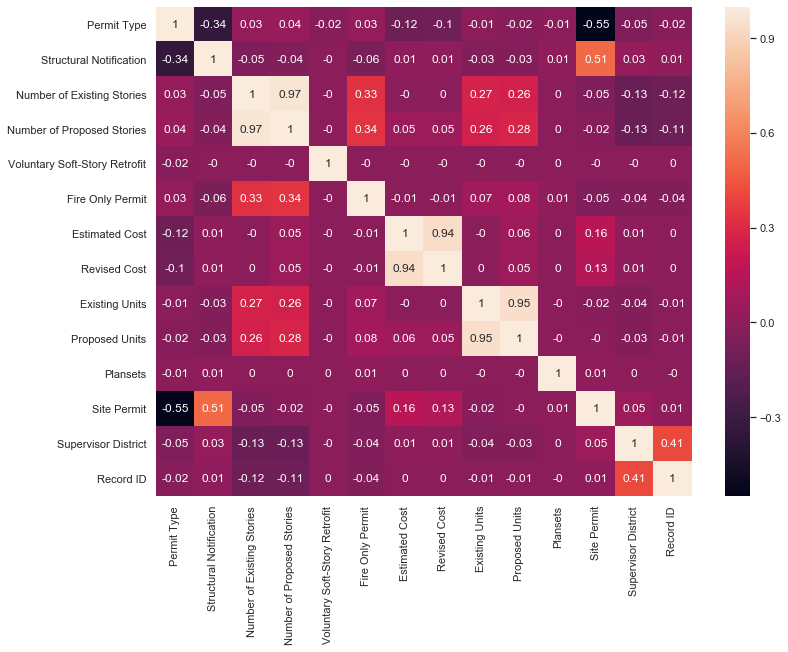

In [19]:
correlation_matrix = sanfrancisco_df.corr().round(2)
sns.set(rc={'figure.figsize':(12, 9)})
sns.heatmap(data=correlation_matrix, annot=True)

# C SF Permits Prediction

### Methoden

In [41]:
def days_between_dates(d1: str, d2: str) -> int:
    """
    Akzeptiert zwei Daten in der Form DD/MM/YYYY und berechnet die Tage zwischen den beiden Daten.
    :param d1: Erstes Datum
    :param d2: Zweites Datum
    :return: Anzahl der Tage zwischen den beiden Daten
    """
    d1 = d1.split("/")
    d2 = d2.split("/")
    if len(d1) != 3 or len(d2) != 3:
        raise ValueError("Date must consist of three numbers divided by '/'")
    d1 = datetime.date(int(d1[2]), int(d1[1]), int(d1[0]))
    d2 = datetime.date(int(d2[2]), int(d2[1]), int(d2[0]))
    return (d2 - d1).days

def days_between_dates_2(series):
    """
    Akzeptiert zwei Daten in der Form DD/MM/YYYY und berechnet die Tage zwischen den beiden Daten.
    :param d1: Erstes Datum
    :param d2: Zweites Datum
    :return: Anzahl der Tage zwischen den beiden Daten
    """
    d1 = series["Filed Date"]
    d2 = series["Issued Date"]
    d1 = d1.split("/")
    d2 = d2.split("/")
    if len(d1) != 3 or len(d2) != 3:
        raise ValueError("Date must consist of three numbers divided by '/'")
    d1 = datetime.date(int(d1[2]), int(d1[0]), int(d1[1]))
    d2 = datetime.date(int(d2[2]), int(d2[0]), int(d2[1]))
    return (d2 - d1).days

In [42]:
sanfrancisco_df.drop("Completed Date", axis=1)
sanfrancisco_df.drop("Permit Creation Date", axis=1)

sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Issued Date"] != "00/00/0000"]
sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Filed Date"] != "00/00/0000"]

sanfrancisco_df["Processing Days"] = sanfrancisco_df.apply(days_between_dates_2, axis=1)

05/06/2015
11/09/2015
04/19/2016
08/03/2017
11/07/2016
07/18/2017
11/28/2016
12/01/2017
06/14/2017
07/06/2017
06/30/2017
06/30/2017
06/30/2017
06/30/2017
07/05/2017
07/05/2017
07/06/2017
07/06/2017
07/06/2017
07/06/2017
07/07/2017
07/07/2017
07/10/2017
07/10/2017
07/26/2017
07/26/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/28/2017
07/28/2017
07/31/2017
07/31/2017
08/07/2017
08/07/2017
08/08/2017
08/08/2017
08/16/2017
08/16/2017
08/18/2017
08/18/2017
08/21/2017
08/21/2017
08/21/2017
08/21/2017
08/22/2017
08/22/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/28/2017
08/28/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
09/07/2017
09/07/2017
09/08/2017
09/08/2017
09/15/2017
09/15/2017
09/19/2017
09/19/2017
09/21/2017
09/21/2017
09/27/2017
09/27/2017
09/28/2017
09/28/2017
10/04/2017
10/04/2017
10/11/2017
10/11/2017
10/11/2017
10/11/2017
10/11/2017
10/11/2017
10/12/2017
10/12/2017
10/13/2017

01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
03/01/2013
01/02/2013
01/08/2013
01/02/2013
02/07/2013
01/02/2013
01/08/2013
01/02/2013
02/07/2013
01/02/2013
02/07/2013
01/02/2013
01/08/2013
01/02/2013
01/02/2013
01/02/2013
02/07/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/15/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/04/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/04/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/04/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013
01/02/2013

01/07/2013
01/07/2013
01/07/2013
01/08/2013
01/07/2013
01/11/2013
01/07/2013
01/07/2013
01/07/2013
02/12/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/07/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/11/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/17/2013
01/08/2013
01/17/2013
01/08/2013
05/07/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/10/2013
01/08/2013
01/14/2013
01/08/2013
01/14/2013
01/08/2013
01/08/2013
01/08/2013
01/14/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/09/2013
01/08/2013
04/09/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/08/2013
01/11/2013
01/08/2013

01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
06/26/2013
01/14/2013
01/14/2013
01/14/2013
01/17/2013
01/14/2013
03/08/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/15/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/22/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
05/31/2013
01/14/2013
01/14/2013
01/14/2013
01/23/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/17/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/24/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013
01/14/2013

01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/25/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/22/2013
01/18/2013
01/22/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/22/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/22/2013
01/18/2013
01/18/2013
01/18/2013
01/22/2013
01/18/2013
03/08/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
06/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/23/2013
01/18/2013
01/23/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
02/14/2013
01/18/2013
01/18/2013
01/18/2013
02/12/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/29/2013
01/18/2013
01/25/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013
01/18/2013

01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/25/2013
01/24/2013
01/25/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/07/2013
01/24/2013
01/24/2013
03/06/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/25/2013
01/24/2013
01/24/2013
01/24/2013
10/02/2014
01/24/2013
01/30/2013
01/24/2013
06/17/2014
01/24/2013
07/10/2013
01/24/2013
02/01/2013
01/24/2013
04/23/2013
01/24/2013
01/24/2013
01/24/2013
02/28/2013
01/24/2013
01/24/2013
01/24/2013
03/04/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
03/04/2013
01/24/2013
01/24/2013
01/24/2013
01/25/2013
01/24/2013
01/25/2013
01/24/2013
01/24/2013
01/24/2013
03/04/2013
01/24/2013
03/04/2013
01/24/2013
01/29/2013
01/24/2013
03/04/2013
01/24/2013
03/04/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013
01/24/2013

01/31/2013
01/31/2013
09/25/2013
01/31/2013
09/25/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
06/09/2014
01/31/2013
03/14/2013
01/31/2013
01/31/2013
01/31/2013
02/13/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
02/01/2013
01/31/2013
02/01/2013
01/31/2013
01/31/2013
01/31/2013
08/29/2013
01/31/2013
02/01/2013
01/31/2013
02/01/2013
01/31/2013
02/01/2013
01/31/2013
01/31/2013
01/31/2013
02/01/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
03/13/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
02/01/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
05/13/2014
01/31/2013
02/12/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
04/19/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/31/2013
01/30/2013
01/31/2013
01/31/2013
01/31/2013

02/11/2013
08/18/2015
02/11/2013
08/18/2015
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/13/2013
02/11/2013
03/13/2013
02/11/2013
02/28/2013
02/11/2013
02/28/2013
02/11/2013
02/28/2013
02/11/2013
03/29/2013
02/11/2013
02/11/2013
01/07/2013
02/15/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
11/01/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
03/14/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/22/2013
02/11/2013
04/05/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/14/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
02/11/2013
03/07/2013
02/11/2013
08/02/2013
02/11/2013
02/14/2013
02/11/2013
02/13/2013
02/11/2013
02/11/2013
02/11/2013
02/20/2013
02/11/2013

02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/22/2013
02/19/2013
02/19/2013
02/19/2013
03/01/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/26/2014
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/20/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/07/2013
02/20/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/19/2013
02/21/2013
02/19/2013

02/22/2013
02/22/2013
02/22/2013
02/26/2013
02/22/2013
03/12/2013
02/25/2013
03/07/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
09/12/2013
02/20/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
03/01/2013
02/25/2013
02/25/2013
02/25/2013
03/27/2013
02/25/2013
03/14/2013
02/25/2013
05/22/2014
02/25/2013
02/25/2013
02/25/2013
02/28/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/26/2013
02/25/2013
03/04/2013
02/25/2013
03/26/2013
02/25/2013
02/25/2013
02/25/2013
04/10/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/26/2013
02/25/2013
03/11/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013
02/25/2013

03/01/2013
05/06/2013
03/01/2013
03/01/2013
03/01/2013
03/15/2013
03/01/2013
03/01/2013
03/01/2013
03/06/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
04/17/2013
03/01/2013
03/01/2013
03/01/2013
03/06/2013
03/01/2013
03/01/2013
03/01/2013
03/04/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/04/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
05/06/2013
03/01/2013
03/01/2013
02/27/2013
03/01/2013
02/27/2013
03/01/2013
03/01/2013
03/04/2013
03/01/2013
12/22/2014
03/01/2013
03/01/2013
03/01/2013
03/26/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/07/2013
03/01/2013
03/07/2013
03/01/2013
03/18/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/01/2013
03/21/2013
03/01/2013
03/21/2013
03/01/2013

03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
04/04/2013
03/08/2013
03/12/2013
03/08/2013
03/08/2013
03/08/2013
06/21/2013
03/08/2013
03/08/2013
03/08/2013
04/05/2013
03/08/2013
03/08/2013
03/08/2013
03/19/2013
03/08/2013
03/08/2013
03/08/2013
05/20/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/11/2013
03/08/2013
03/11/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/12/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/11/2013
03/08/2013
03/11/2013
03/08/2013
03/08/2013
03/05/2013
03/08/2013
03/08/2013
03/11/2013
03/08/2013
03/08/2013
03/08/2013
05/30/2013
03/08/2013
03/20/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013
03/08/2013

03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/22/2013
03/15/2013
03/22/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/21/2013
03/15/2013
03/21/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/29/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/22/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/15/2013
03/25/2013
03/15/2013
03/15/2013
03/15/2013
03/25/2013
03/15/2013
03/15/2013
03/15/2013
03/22/2013
03/15/2013
06/27/2013
03/15/2013
03/15/2013
03/15/2013
03/28/2013
03/15/2013
03/28/2013
03/15/2013
03/15/2013
03/15/2013
03/18/2013
03/15/2013
04/09/2013
03/15/2013
03/15/2013
03/15/2013
03/19/2013
03/15/2013

03/20/2013
03/20/2013
05/15/2013
03/20/2013
03/22/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/28/2013
03/20/2013
03/26/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/29/2013
03/20/2013
03/25/2013
03/20/2013
04/11/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/27/2013
03/20/2013
06/02/2014
03/20/2013
03/21/2013
03/20/2013
03/21/2013
03/20/2013
03/27/2013
03/20/2013
04/12/2013
03/20/2013
12/24/2013
03/20/2013
03/20/2013
03/20/2013
03/29/2013
03/20/2013
03/22/2013
03/20/2013
03/21/2013
03/20/2013
03/20/2013
03/20/2013
03/21/2013
03/20/2013
03/20/2013
03/20/2013
04/01/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013
02/05/2014
03/20/2013
07/30/2013
03/20/2013
03/20/2013
03/20/2013
03/20/2013

03/29/2013
03/29/2013
03/29/2013
06/13/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
06/20/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
04/11/2013
03/29/2013
06/13/2013
03/27/2013
03/29/2013
03/29/2013
07/24/2013
03/29/2013
07/24/2013
03/29/2013
07/24/2013
03/29/2013
03/29/2013
03/29/2013
04/02/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
04/11/2013
03/29/2013
04/03/2013
03/29/2013
04/03/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
06/13/2013
03/29/2013
04/16/2013
03/29/2013
04/01/2013
03/29/2013
01/13/2014
03/29/2013
01/13/2014
03/29/2013
01/23/2014
03/29/2013
05/24/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013
03/29/2013

04/08/2013
04/18/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/11/2013
04/08/2013
04/08/2013
04/08/2013
04/10/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/09/2013
04/08/2013
04/08/2013
04/08/2013
04/25/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/17/2013
04/08/2013
05/01/2013
04/08/2013
05/17/2013
04/08/2013
05/17/2013
04/08/2013
04/08/2013
04/08/2013
04/09/2013
04/08/2013
04/08/2013
04/08/2013
04/09/2013
04/08/2013
04/09/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013
04/08/2013

04/19/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/25/2013
04/12/2013
04/23/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
05/07/2013
04/12/2013
03/17/2014
04/12/2013
04/12/2013
04/12/2013
04/17/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/25/2013
04/12/2013
04/12/2013
04/12/2013
04/15/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/16/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
05/13/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
08/28/2013
04/12/2013
08/28/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
08/15/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013
04/12/2013

04/18/2013
05/09/2013
04/18/2013
05/31/2013
04/18/2013
05/31/2013
04/18/2013
04/19/2013
04/18/2013
04/18/2013
04/18/2013
05/31/2013
04/18/2013
05/31/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/19/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
07/21/2014
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
04/18/2013
05/16/2013
04/18/2013
04/18/2013
04/18/2013
04/19/2013
04/18/2013
04/18/2013
04/08/2013
05/31/2013
04/18/2013

08/23/2013
04/26/2013
04/26/2013
04/26/2013
08/23/2013
04/26/2013
08/23/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
05/02/2013
04/26/2013
05/16/2013
04/26/2013
05/02/2013
04/26/2013
04/29/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/30/2013
04/26/2013
04/26/2013
04/26/2013
05/03/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
11/22/2013
04/26/2013
04/26/2013
04/26/2013
05/17/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
05/10/2013
04/26/2013
05/10/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
04/26/2013
05/24/2013

05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/06/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/15/2013
05/02/2013
05/15/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
07/10/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
07/11/2013
05/02/2013
07/11/2013
05/02/2013
05/03/2013
05/02/2013
05/02/2013
05/02/2013
05/03/2013
05/02/2013
05/02/2013
05/02/2013
05/07/2013
05/02/2013
05/03/2013
05/02/2013
05/10/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
06/10/2013
05/02/2013
06/27/2013
05/02/2013
06/27/2013
05/02/2013
05/02/2013
05/02/2013
05/03/2013
05/02/2013
09/23/2013
05/02/2013
04/19/2016
05/02/2013
06/19/2013
05/01/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/22/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/10/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013
05/02/2013

05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/13/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
07/19/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
06/10/2013
05/10/2013
05/16/2013
05/10/2013
05/22/2013
05/10/2013
05/10/2013
05/10/2013
05/16/2013
05/10/2013
05/13/2013
05/10/2013
05/31/2013
05/10/2013
05/10/2013
05/10/2013
05/22/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/14/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
06/06/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/15/2013
05/10/2013
05/15/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
05/10/2013
06/11/2013

05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/17/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/15/2013
05/17/2013
05/15/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/31/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/18/2015
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/16/2013
05/13/2015
05/16/2013
05/16/2013
05/16/2013
05/20/2013
05/16/2013
05/20/2013
05/16/2013
05/16/2013

05/21/2013
05/21/2013
05/21/2013
09/10/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
09/18/2013
05/21/2013
05/21/2013
05/21/2013
05/29/2013
05/21/2013
05/21/2013
05/21/2013
05/28/2013
05/21/2013
12/09/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/22/2013
05/21/2013
05/22/2013
05/21/2013
05/21/2013
05/21/2013
05/22/2013
05/21/2013
05/22/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
06/21/2013
05/21/2013
05/22/2013
05/21/2013
05/22/2013
05/17/2013
05/22/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/22/2013
05/21/2013
05/31/2013
05/21/2013
05/24/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/28/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/21/2013
05/29/2013
05/21/2013
05/22/2013
05/21/2013
05/22/2013
05/21/2013

05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
06/04/2013
05/30/2013
06/03/2013
05/30/2013
06/20/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
07/15/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/24/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
07/18/2013
05/30/2013
07/29/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
02/21/2014
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
08/07/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
05/30/2013
08/19/2013
05/30/2013
05/30/2013
05/30/2013
08/07/2013
05/30/2013
05/30/2013
05/30/2013
04/16/2014
05/30/2013
05/30/2013
05/30/2013
10/07/2013

06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/12/2013
06/03/2013
06/05/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/04/2013
06/03/2013
06/25/2013
06/03/2013
06/03/2013
06/03/2013
08/12/2014
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/04/2013
06/03/2013
06/06/2013
06/03/2013
06/10/2013
06/03/2013
06/12/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/04/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/04/2013
06/03/2013
06/04/2013
06/03/2013
06/06/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/03/2013
06/04/2013
06/03/2013
06/03/2013
06/03/2013
06/06/2013
06/03/2013
06/04/2013
06/03/2013
06/07/2013
06/03/2013
06/04/2013
06/03/2013
06/04/2013
06/03/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/07/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/04/2013
06/17/2013
06/04/2013
06/04/2013

06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/11/2014
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
07/12/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/11/2013
06/10/2013
06/10/2013
06/10/2013
06/11/2013
06/10/2013
06/10/2013
05/14/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/14/2013
06/10/2013
06/11/2013
06/10/2013
06/10/2013
06/10/2013
06/11/2013
06/10/2013
06/11/2013
06/10/2013
06/10/2013
06/10/2013
06/25/2013
06/10/2013
06/12/2013
06/10/2013
06/10/2013
06/10/2013
06/18/2013
06/10/2013
06/18/2013
06/10/2013
08/28/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013
06/11/2013
06/10/2013
06/10/2013
06/10/2013
08/05/2013
06/10/2013
06/10/2013
06/10/2013
06/10/2013

05/14/2013
06/17/2013
06/14/2013
06/14/2013
06/14/2013
07/18/2013
06/14/2013
07/26/2013
06/14/2013
06/14/2013
06/14/2013
07/19/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/18/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/17/2013
06/14/2013
06/14/2013
06/14/2013
06/17/2013
06/14/2013
06/17/2013
06/14/2013
06/14/2013
06/14/2013
06/17/2013
06/14/2013
08/07/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/14/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/14/2013
06/17/2013
06/17/2013
06/21/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013
06/17/2013

06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
07/24/2013
06/20/2013
07/24/2013
06/20/2013
06/26/2013
06/20/2013
10/23/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
10/16/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
07/24/2015
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
07/19/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
12/18/2013
06/20/2013
07/09/2013
05/23/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/27/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/27/2013
06/20/2013
06/20/2013
06/20/2013
07/08/2013
06/20/2013
06/21/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/20/2013
06/21/2013
06/20/2013
06/21/2013
06/20/2013
06/21/2013
06/20/2013
06/26/2013
06/20/2013

06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/27/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/27/2013
06/27/2013
06/28/2013
05/31/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
06/28/2013
06/27/2013
07/03/2013
06/27/2013
07/26/2013
06/27/2013
07/30/2013
06/27/2013
02/13/2014
06/27/2013
02/13/2014
06/27/2013
11/19/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
11/04/2013
06/27/2013
06/27/2013
06/27/2013
07/01/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
09/04/2013
06/27/2013
12/24/2013
06/27/2013
12/24/2013
06/27/2013
08/28/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
08/01/2013
06/27/2013
06/27/2013
06/27/2013
02/04/2014
06/27/2013
06/27/2013
06/27/2013
06/27/2013
06/27/2013
07/22/2013
06/27/2013

07/03/2013
07/03/2013
07/03/2013
07/24/2013
07/03/2013
07/03/2013
07/03/2013
07/24/2013
07/03/2013
07/10/2013
07/03/2013
07/03/2013
07/03/2013
08/14/2013
07/03/2013
07/03/2013
07/03/2013
07/09/2013
07/03/2013
07/10/2013
07/03/2013
07/17/2013
07/03/2013
05/13/2014
07/03/2013
08/20/2013
07/03/2013
07/09/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/12/2013
07/03/2013
07/12/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
08/12/2013
07/03/2013
08/19/2013
07/03/2013
07/03/2013
07/03/2013
07/05/2013
07/03/2013
07/03/2013
07/03/2013
12/03/2013
07/03/2013
07/03/2013
07/03/2013
07/15/2013
07/03/2013
07/11/2013
05/29/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/16/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/10/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013
07/03/2013

07/10/2013
07/10/2013
07/10/2013
07/10/2013
10/24/2013
07/10/2013
07/10/2013
07/10/2013
07/10/2013
07/10/2013
09/05/2013
07/10/2013
09/03/2013
07/10/2013
09/25/2013
07/10/2013
07/15/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/12/2013
07/11/2013
07/11/2013
07/11/2013
07/19/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/17/2013
07/09/2013
07/11/2013
07/09/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013
07/11/2013

07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
09/24/2013
07/17/2013
07/22/2013
07/17/2013
11/17/2014
07/17/2013
07/17/2013
07/17/2013
09/04/2013
07/17/2013
07/17/2013
07/17/2013
07/18/2013
07/17/2013
09/16/2013
07/17/2013
07/17/2013
07/17/2013
09/03/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/23/2013
07/17/2013
07/23/2013
07/17/2013
07/25/2013
07/17/2013
07/17/2013
07/17/2013
07/31/2013
07/17/2013
07/17/2013
07/17/2013
09/11/2013
07/17/2013
07/17/2013
07/17/2013
07/19/2013
07/17/2013
08/30/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/18/2013
07/17/2013
07/18/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/17/2013
07/18/2013
08/07/2013
07/18/2013
07/18/2013
07/18/2013
07/18/2013
07/18/2013
07/18/2013

07/23/2013
07/25/2013
07/23/2013
07/24/2013
07/23/2013
07/23/2013
07/23/2013
08/07/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/24/2013
07/23/2013
07/24/2013
07/23/2013
07/24/2013
07/23/2013
10/10/2013
07/23/2013
07/23/2013
07/23/2013
07/24/2013
07/23/2013
07/24/2013
07/23/2013
07/23/2013
07/23/2013
07/24/2013
07/23/2013
07/24/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/31/2013
07/23/2013
07/31/2013
07/23/2013
08/07/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2014
07/23/2013
07/23/2013
07/23/2013
07/25/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
08/01/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/23/2013
07/31/2013
07/23/2013
07/31/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/24/2013
07/25/2013
07/24/2013
07/24/2013
07/24/2013

07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
08/06/2013
07/30/2013
08/06/2013
07/30/2013
07/30/2013
07/30/2013
08/06/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
08/01/2013
07/30/2013
02/06/2014
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
08/01/2013
07/30/2013
09/12/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
08/02/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/30/2013
07/31/2013
07/30/2013
07/30/2013
07/30/2013

08/08/2013
08/06/2013
08/06/2013
08/06/2013
08/07/2013
08/06/2013
08/06/2013
08/06/2013
08/22/2013
08/06/2013
08/19/2013
08/06/2013
09/04/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/22/2013
08/06/2013
08/16/2013
08/06/2013
08/06/2013
08/06/2013
08/07/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/07/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/06/2013
08/07/2013
08/06/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/16/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/12/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/16/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/09/2013
08/07/2013
11/05/2013
08/07/2013
08/07/2013
08/07/2013
08/19/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013
08/07/2013

08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/20/2013
08/13/2013
10/08/2014
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/19/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
09/27/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
02/20/2014
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
09/03/2013
08/13/2013
08/15/2013
08/13/2013
08/15/2013
08/13/2013
08/13/2013
08/13/2013
09/26/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/26/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/14/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/13/2013
08/14/2013

08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/28/2013
08/19/2013
08/28/2013
08/19/2013
08/28/2013
08/19/2013
08/20/2013
08/19/2013
08/19/2013
08/19/2013
08/22/2013
08/19/2013
08/19/2013
08/19/2013
04/21/2014
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/19/2013
08/20/2013
08/19/2013
08/19/2013
08/20/2013
08/30/2013
08/20/2013
08/20/2013
08/20/2013
08/26/2013
08/20/2013
09/13/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
08/20/2013
11/03/2014
08/20/2013
08/20/2013
08/20/2013
09/06/2013
08/20/2013
08/20/2013
08/20/2013
08/30/2013
08/20/2013
08/30/2013
08/20/2013
11/03/2014

08/22/2013
09/01/2015
08/22/2013
08/23/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/23/2013
08/22/2013
08/22/2013
08/22/2013
08/29/2013
08/22/2013
09/23/2013
08/22/2013
08/22/2013
08/22/2013
12/03/2014
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
01/29/2014
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/23/2013
08/22/2013
08/23/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
08/22/2013
09/26/2013
08/22/2013
09/04/2014
08/16/2013
09/04/2013
08/23/2013
08/23/2013
08/23/2013
08/29/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/26/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
08/23/2013
10/09/2013
08/23/2013
08/26/2013
08/23/2013
08/23/2013
08/23/2013

08/29/2013
09/16/2013
08/29/2013
08/29/2013
08/29/2013
09/10/2013
08/29/2013
09/10/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
09/09/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/29/2013
08/30/2013
01/31/2013
08/29/2013
08/29/2013
08/29/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
09/16/2013
08/30/2013
09/16/2013
08/30/2013
08/30/2013
08/30/2013
09/13/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/27/2013
08/29/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
09/06/2013
08/30/2013
09/03/2013
08/30/2013
08/30/2013
08/30/2013
09/03/2013
08/30/2013
09/04/2013
08/30/2013
08/30/2013
08/30/2013
09/03/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
08/30/2013
09/16/2013
08/30/2013
09/16/2013
08/30/2013
08/30/2013
08/30/2013

09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
12/04/2013
09/06/2013
09/13/2013
09/06/2013
10/18/2013
09/06/2013
09/06/2013
09/06/2013
09/18/2013
09/06/2013
09/23/2013
09/06/2013
05/10/2016
09/06/2013
09/24/2013
09/06/2013
09/13/2013
09/06/2013
09/06/2013
09/06/2013
09/11/2013
09/06/2013
09/11/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/09/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/11/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/17/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/17/2013
09/06/2013
09/09/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/09/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
10/03/2013
09/06/2013
09/06/2013
09/06/2013
05/06/2014
09/06/2013
10/03/2013
09/06/2013
10/08/2013
09/06/2013
09/09/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013
09/06/2013

09/12/2013
09/13/2013
09/12/2013
09/12/2013
09/12/2013
10/09/2013
09/12/2013
09/12/2013
09/12/2013
09/13/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/13/2013
09/12/2013
09/12/2013
09/12/2013
09/25/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
09/12/2013
02/23/2016
09/12/2013
10/24/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
10/16/2013
09/13/2013
09/27/2013
09/13/2013
09/13/2013
09/13/2013
09/16/2013
09/13/2013
09/13/2013
09/13/2013
09/25/2013
09/13/2013
09/16/2013
09/13/2013
09/16/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/20/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/23/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013
09/13/2013

09/19/2013
09/18/2013
09/19/2013
09/19/2013
04/29/2014
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
04/04/2014
09/19/2013
10/22/2013
09/19/2013
11/04/2013
09/19/2013
11/04/2013
09/19/2013
09/20/2013
09/19/2013
09/25/2013
09/19/2013
09/19/2013
09/19/2013
10/16/2013
09/19/2013
03/07/2014
09/19/2013
09/20/2013
09/19/2013
10/16/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
08/14/2013
09/19/2013
08/14/2013
09/19/2013
09/19/2013
05/14/2014
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
10/17/2013
09/19/2013
09/25/2013
09/19/2013
09/19/2013
09/19/2013
04/15/2014
09/19/2013
10/02/2013
09/19/2013
12/03/2013
09/19/2013
09/25/2013
09/19/2013
10/02/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
09/19/2013
10/10/2013
09/19/2013
09/19/2013

09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
10/22/2013
09/26/2013
10/03/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
10/16/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
04/21/2014
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/30/2013
09/26/2013
09/26/2013
09/26/2013
10/11/2013
09/26/2013
09/26/2013
09/26/2013
09/27/2013
09/26/2013
10/11/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
03/20/2014
09/26/2013
10/16/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
11/07/2013
09/26/2013
09/26/2013
09/16/2013
09/16/2013
09/26/2013
10/04/2013
09/26/2013
11/05/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013
09/26/2013

09/30/2013
10/01/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/01/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/01/2013
09/30/2013
10/01/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/16/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/02/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/28/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/02/2013
09/30/2013
10/01/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
09/30/2013
10/01/2013
10/08/2013
10/01/2013
10/01/2013
09/30/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/02/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013
10/01/2013

10/08/2013
10/07/2013
12/16/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
01/14/2014
10/07/2013
01/14/2014
10/07/2013
10/22/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/08/2013
10/07/2013
10/07/2013
10/07/2013
10/08/2013
10/07/2013
10/07/2013
10/07/2013
10/16/2013
10/07/2013
11/07/2013
10/07/2013
10/08/2013
10/07/2013
10/08/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/08/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
11/04/2013
10/07/2013
10/11/2013
10/07/2013
10/09/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/07/2013
10/10/2013

11/20/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
04/15/2014
10/15/2013
10/24/2013
10/15/2013
10/15/2013
08/09/2013
01/30/2014
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
02/10/2014
10/15/2013
10/17/2013
10/15/2013
01/15/2014
10/15/2013
10/24/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/22/2013
10/15/2013
10/15/2013
10/15/2013
10/17/2013
10/15/2013
10/15/2013
10/15/2013
10/29/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
10/15/2013
11/20/2013
10/15/2013
10/17/2013
10/15/2013
10/23/2013
10/15/2013
01/09/2015
10/15/2013
11/12/2015
10/15/2013
10/30/2013
10/15/2013
10/16/2013
10/15/2013
10/15/2013

10/25/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/22/2013
10/18/2013
10/18/2013
10/18/2013
11/20/2013
10/18/2013
10/18/2013
10/18/2013
03/27/2014
10/18/2013
03/24/2014
10/18/2013
10/21/2013
10/18/2013
03/24/2014
10/18/2013
10/21/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
08/25/2014
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/29/2013
10/18/2013
10/22/2013
10/18/2013
04/04/2014
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
03/19/2014
10/18/2013
10/18/2013
10/18/2013
10/18/2013
10/18/2013
03/19/2014
10/18/2013
10/18/2013
10/18/2013
11/19/2013
10/18/2013
03/24/2014
10/18/2013
10/18/2013
10/18/2013
11/15/2013
10/18/2013
10/18/2013
10/18/2013
03/24/2014
10/18/2013
03/24/2014
10/18/2013
11/14/2013
10/18/2013
10/21/2013
10/18/2013
10/21/2013
10/18/2013
10/18/2013
10/18/2013
10/21/2013
10/18/2013
10/28/2013

10/29/2013
10/28/2013
10/28/2013
10/28/2013
10/28/2013
10/18/2013
10/28/2013
10/28/2013
10/23/2014
10/28/2013
10/31/2013
10/28/2013
10/28/2013
10/28/2013
10/29/2013
10/28/2013
10/29/2013
10/28/2013
10/28/2013
10/28/2013
10/29/2013
10/28/2013
10/28/2013
10/28/2013
10/28/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
05/02/2014
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
12/10/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
11/01/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013
10/29/2013

03/26/2015
11/01/2013
11/01/2013
11/01/2013
03/26/2015
11/01/2013
03/26/2015
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
03/26/2015
11/01/2013
03/27/2014
11/01/2013
09/18/2014
11/01/2013
03/26/2015
11/01/2013
03/26/2015
11/01/2013
03/26/2015
11/01/2013
11/01/2013
11/01/2013
03/26/2015
11/01/2013
11/06/2013
11/01/2013
09/18/2014
11/01/2013
03/26/2015
11/01/2013
03/26/2015
11/01/2013
11/06/2014
11/01/2013
11/06/2014
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/06/2013
11/01/2013
03/24/2015
11/01/2013
11/06/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
11/01/2013
10/31/2013
11/01/2013
11/01/2013
11/08/2013
11/01/2013
11/08/2013
11/01/2013
05/29/2015
11/01/2013
11/05/2013
11/01/2013
11/05/2013
11/01/2013
12/17/2013
11/01/2013
11/01/2013
11/01/2013
11/05/2013
11/01/2013
11/05/2013
11/01/2013
11/06/2013
11/01/2013
11/06/2013

11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/21/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
05/05/2014
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/06/2013
11/07/2013
11/06/2013
12/02/2013
11/06/2013
11/21/2013
11/06/2013
11/06/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/27/2013
11/07/2013
11/26/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
02/14/2014
11/07/2013
12/03/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013
11/07/2013

11/18/2013
11/13/2013
11/13/2013
11/13/2013
11/27/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/15/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/13/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/27/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
02/25/2014
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
03/21/2014
11/14/2013
03/21/2014
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/14/2013
11/15/2013
11/14/2013
11/14/2013
11/14/2013
03/12/2014
11/14/2013
03/12/2014
11/14/2013
11/14/2013
11/14/2013
01/28/2014
11/14/2013
12/10/2013
11/14/2013
11/14/2013

11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
02/19/2014
11/21/2013
08/08/2014
11/21/2013
11/21/2013
11/21/2013
06/09/2014
11/21/2013
12/05/2013
11/21/2013
11/21/2013
11/21/2013
11/25/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
03/12/2015
11/20/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
12/05/2013
11/21/2013
11/21/2013
11/21/2013
01/24/2014
11/21/2013
11/21/2013
11/21/2013
01/28/2014
11/21/2013
11/21/2013
11/21/2013
11/25/2013
11/21/2013
11/26/2013
11/21/2013
11/22/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/25/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/22/2013
11/21/2013
12/02/2013
11/21/2013
08/24/2015
11/21/2013
11/22/2013
11/21/2013
12/10/2013
11/21/2013
11/21/2013
11/21/2013
02/28/2014
11/21/2013
11/21/2013
11/21/2013
11/21/2013
11/21/2013
04/30/2014
11/21/2013
05/13/2015
11/21/2013
11/21/2013
11/21/2013

11/27/2013
11/27/2013
12/12/2013
11/27/2013
02/25/2014
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
03/25/2014
11/27/2013
12/31/2013
11/27/2013
11/27/2013
11/27/2013
12/06/2013
11/27/2013
12/06/2013
11/27/2013
12/10/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
12/16/2013
11/27/2013
11/27/2013
11/27/2013
12/06/2013
11/27/2013
11/27/2013
11/27/2013
03/13/2017
11/27/2013
12/02/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
10/31/2014
11/27/2013
11/27/2013
11/27/2013
12/02/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
12/02/2013
11/27/2013
03/05/2014
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
11/27/2013
01/24/2014
11/27/2013
01/24/2014
11/27/2013
12/13/2013
11/27/2013
11/27/2013
11/27/2013
02/24/2014
11/27/2013
01/14/2015
11/25/2013
11/27/2013
11/27/2013
11/27/2013

12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/13/2013
12/06/2013
12/06/2013
12/06/2013
12/11/2013
12/06/2013
12/10/2013
12/06/2013
12/06/2013
12/06/2013
12/10/2013
12/06/2013
12/06/2013
12/06/2013
12/17/2013
12/06/2013
12/06/2013
12/06/2013
09/18/2015
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
01/15/2014
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
02/19/2014
12/06/2013
12/06/2013
12/06/2013
12/09/2013
12/06/2013
12/09/2013
12/06/2013
12/09/2013
12/06/2013
12/09/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/16/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
11/07/2014
12/06/2013
12/06/2013
12/06/2013
12/13/2013
12/06/2013
12/06/2013
12/06/2013
12/11/2013
12/06/2013
12/11/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/06/2013
12/13/2013
12/06/2013
12/06/2013

12/13/2013
10/29/2014
12/13/2013
12/16/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
04/29/2014
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/16/2013
12/13/2013
12/13/2013
12/13/2013
12/16/2013
12/13/2013
12/13/2013
12/13/2013
12/16/2013
12/13/2013
12/13/2013
12/13/2013
12/19/2013
12/13/2013
12/16/2013
12/13/2013
01/21/2014
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
03/03/2014
12/13/2013
02/20/2014
12/13/2013
01/03/2014
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/20/2013
12/13/2013
12/30/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/18/2013
12/13/2013
12/27/2013
12/13/2013
05/02/2014
12/13/2013
12/17/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013
12/13/2013

12/19/2013
12/19/2013
03/07/2014
12/19/2013
01/06/2014
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
03/07/2014
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/31/2013
12/19/2013
12/20/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
04/01/2014
12/19/2013
01/09/2014
12/19/2013
05/22/2014
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/19/2013
12/20/2013
12/19/2013
03/31/2014
12/19/2013
03/31/2014
12/19/2013
12/23/2013
12/19/2013
12/01/2014
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
04/24/2014
12/20/2013
02/07/2014
12/20/2013
12/20/2013
12/20/2013
02/12/2015
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
02/03/2014
12/20/2013
12/20/2013
12/20/2013
09/01/2015
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/30/2013
12/20/2013
02/27/2015
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
12/20/2013
10/14/2016
12/20/2013
12/20/2013
12/20/2013
12/20/2013

12/30/2013
12/30/2013
12/30/2013
12/30/2013
06/30/2014
12/30/2013
01/15/2014
12/30/2013
01/15/2014
12/30/2013
05/02/2014
12/30/2013
02/10/2015
12/30/2013
12/30/2013
12/30/2013
12/30/2013
12/30/2013
12/30/2013
12/30/2013
12/30/2013
12/30/2013
02/19/2014
12/30/2013
12/30/2013
12/30/2013
04/01/2014
12/30/2013
03/28/2014
12/30/2013
03/28/2014
12/30/2013
02/24/2017
11/27/2013
12/02/2013
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
02/27/2014
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
12/31/2013
12/31/2013
07/18/2014
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
04/23/2014
12/31/2013
04/23/2014
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
12/31/2013
01/06/2014
12/31/2013
04/25/2014
12/31/2013
12/31/2013
12/31/2013
02/04/2014
12/31/2013
12/31/2013
12/31/2013
01/17/2014

01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/08/2014
01/07/2014
01/07/2014
01/07/2014
01/27/2014
01/07/2014
02/25/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/17/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
04/08/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/10/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
08/04/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/16/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/22/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/21/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/14/2014
01/07/2014
01/07/2014
01/07/2014
03/28/2014
01/07/2014
01/08/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/07/2014
01/08/2014

01/15/2014
01/15/2014
01/31/2014
01/15/2014
01/16/2014
01/15/2014
04/01/2014
01/15/2014
04/01/2014
01/15/2014
01/15/2014
01/15/2014
04/02/2014
01/15/2014
02/24/2014
01/15/2014
01/16/2014
01/15/2014
01/15/2014
01/15/2014
02/18/2014
01/15/2014
01/17/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
02/18/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
03/27/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
02/04/2014
01/15/2014
01/15/2014
01/15/2014
01/16/2014
01/15/2014
01/21/2014
01/15/2014
01/15/2014
01/15/2014
01/16/2014
01/15/2014
06/09/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/16/2014
01/15/2014
10/24/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014
01/15/2014

01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/27/2014
01/22/2014
01/24/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
04/15/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
05/21/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/24/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
01/22/2014
06/04/2014
01/22/2014
01/28/2014
01/22/2014
01/22/2014
01/22/2014
03/07/2014
01/22/2014
01/29/2014
01/22/2014
01/22/2014
01/22/2014
01/23/2014
01/22/2014
01/24/2014
01/22/2014

01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
07/03/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/24/2014
01/29/2014
01/29/2014
07/25/2014
01/29/2014
07/25/2014
01/29/2014
01/31/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/30/2014
01/29/2014
02/19/2014
01/29/2014
02/19/2014
01/29/2014
01/29/2014
01/29/2014
02/19/2014
01/29/2014
01/30/2014
01/29/2014
01/31/2014
01/29/2014
08/20/2014
01/29/2014
08/20/2014
01/29/2014
01/29/2014
01/29/2014
01/30/2014
01/27/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
02/14/2014
01/29/2014
01/30/2014
01/29/2014
02/13/2014
01/29/2014
02/03/2014
01/29/2014
05/13/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
09/30/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014
01/29/2014

02/12/2014
02/06/2014
02/21/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/14/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
03/21/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/10/2014
02/06/2014
02/06/2014
02/06/2014
02/11/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
11/18/2013
02/06/2014
02/06/2014
02/06/2014
12/31/2013
02/06/2014
02/06/2014
02/14/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
03/25/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/26/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
02/06/2014
04/01/2014
02/06/2014
02/06/2014

02/13/2014
02/19/2014
02/13/2014
02/19/2014
02/13/2014
02/13/2014
02/13/2014
03/04/2014
02/13/2014
03/04/2014
02/13/2014
05/14/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
03/20/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/27/2014
02/13/2014
02/18/2014
02/13/2014
02/24/2014
02/13/2014
02/24/2014
02/13/2014
02/13/2014
02/13/2014
03/10/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
06/18/2014
02/13/2014
02/13/2014
02/13/2014
03/05/2015
02/13/2014
02/13/2014
02/13/2014
03/17/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/28/2014
02/13/2014
02/13/2014
02/13/2014
02/14/2014
02/13/2014
02/13/2014
02/13/2014
02/28/2014
02/13/2014
07/10/2014
02/13/2014
07/10/2014
02/13/2014
07/10/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014
02/13/2014

02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/26/2014
02/19/2014
02/19/2014
02/19/2014
02/20/2014
02/19/2014
03/17/2014
02/19/2014
02/19/2014
02/19/2014
03/05/2014
02/19/2014
02/26/2014
02/19/2014
04/21/2014
02/19/2014
07/05/2016
02/19/2014
03/28/2014
02/19/2014
02/19/2014
02/19/2014
07/07/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
03/28/2014
02/19/2014
06/02/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/25/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/24/2014
02/19/2014
02/19/2014
02/19/2014
03/03/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/21/2014
02/19/2014
02/24/2014
02/19/2014
02/19/2014
02/19/2014
02/24/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014
02/19/2014

02/26/2014
10/23/2014
02/11/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
07/10/2014
02/26/2014
03/31/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
12/31/2013
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/27/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
03/19/2014
02/26/2014
02/26/2014
02/26/2014
03/25/2014
02/26/2014
02/26/2014
02/26/2014
03/04/2014
02/26/2014
02/26/2014
02/26/2014
02/27/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
06/06/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
03/03/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/27/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
02/26/2014
05/16/2014
02/27/2014
02/27/2014
02/27/2014
02/27/2014
02/27/2014
02/27/2014
02/27/2014

03/05/2014
03/11/2014
03/05/2014
03/05/2014
03/05/2014
03/27/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/06/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
06/07/2017
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/06/2014
03/05/2014
06/07/2017
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/21/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/05/2014
03/07/2014
03/06/2014
03/06/2014
03/06/2014
03/14/2014
03/06/2014
03/14/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/06/2014
03/11/2014
03/06/2014
03/06/2014
03/06/2014
03/10/2014
03/06/2014
03/07/2014
03/06/2014

03/13/2014
03/12/2014
03/13/2014
03/12/2014
03/17/2014
03/12/2014
03/12/2014
03/12/2014
07/11/2014
03/12/2014
04/29/2014
03/12/2014
03/14/2014
03/12/2014
05/09/2014
03/12/2014
06/09/2014
03/12/2014
03/14/2014
03/12/2014
03/25/2014
03/12/2014
03/25/2014
03/12/2014
04/10/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/18/2014
03/12/2014
03/21/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/24/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
03/12/2014
04/01/2014
03/12/2014
03/12/2014
03/12/2014
03/17/2014
03/12/2014
03/31/2014
03/12/2014
03/25/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/12/2014
03/12/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/12/2014
03/14/2014
03/12/2014
03/12/2014
03/12/2014
06/18/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/12/2014
03/17/2014
03/10/2014
03/12/2014

03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/24/2014
03/20/2014
03/21/2014
03/20/2014
03/24/2014
03/20/2014
04/02/2014
03/20/2014
03/27/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
04/11/2014
03/20/2014
04/02/2014
03/20/2014
03/25/2014
03/20/2014
03/21/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/25/2014
03/20/2014
06/27/2014
03/20/2014
03/28/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
06/12/2014
03/20/2014
03/20/2014
03/20/2014
05/13/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
05/05/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
04/21/2014
03/20/2014
03/20/2014
03/20/2014
03/20/2014
08/30/2013
10/06/2014
03/20/2014

04/14/2014
03/26/2014
03/26/2014
03/26/2014
04/08/2014
03/26/2014
03/28/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/27/2014
03/26/2014
03/26/2014
03/26/2014
04/24/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
08/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
06/26/2015
03/26/2014
03/26/2014
03/26/2014
03/26/2014
03/26/2014
04/02/2014
03/26/2014
03/26/2014
03/26/2014
04/24/2014
03/26/2014
06/12/2014
03/26/2014
08/01/2016
03/26/2014
03/26/2014
03/26/2014
06/12/2014
03/26/2014
03/26/2014
03/26/2014
06/12/2014
03/26/2014
03/26/2014
03/26/2014
09/25/2014
03/26/2014
03/27/2014
03/27/2014
04/17/2014
03/27/2014
05/05/2014
03/27/2014
03/27/2014
03/27/2014
04/02/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014
03/27/2014

04/03/2014
04/15/2014
04/03/2014
04/03/2014
04/03/2014
04/09/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/04/2014
04/03/2014
04/03/2014
04/03/2014
04/04/2014
04/03/2014
04/03/2014
04/03/2014
04/09/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/22/2014
04/03/2014
04/22/2014
04/03/2014
04/03/2014
04/03/2014
04/07/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
09/16/2014
04/03/2014
04/03/2014
04/03/2014
02/02/2015
04/03/2014
02/02/2015
04/03/2014
04/03/2014
04/03/2014
04/04/2014
04/03/2014
02/02/2015
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
06/13/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/10/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014
04/03/2014

04/09/2014
04/10/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/17/2014
04/09/2014
04/09/2014
04/09/2014
04/29/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
06/13/2014
04/09/2014
04/09/2014
04/09/2014
05/01/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/30/2014
04/09/2014
04/09/2014
04/09/2014
06/03/2014
04/09/2014
04/16/2014
04/09/2014
04/10/2014
04/09/2014
04/09/2014
04/09/2014
04/29/2014
04/09/2014
04/29/2014
04/09/2014
04/17/2014
04/09/2014
08/18/2014
04/09/2014
04/09/2014
04/09/2014
04/11/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/10/2014
04/09/2014
04/11/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/11/2014
04/09/2014
04/09/2014
04/09/2014
05/07/2014
04/09/2014
04/09/2014
04/09/2014
11/17/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/17/2014
04/09/2014
05/02/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014
04/09/2014

05/06/2014
04/15/2014
05/08/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
05/05/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/18/2014
04/15/2014
06/05/2014
04/15/2014
04/18/2014
04/15/2014
04/18/2014
04/15/2014
04/16/2014
04/15/2014
04/16/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
07/02/2014
04/15/2014
05/12/2014
04/15/2014
04/15/2014
04/15/2014
04/18/2014
04/15/2014
04/15/2014
04/15/2014
04/18/2014
04/15/2014
04/25/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014
05/23/2014
04/15/2014
06/13/2014
04/15/2014
04/15/2014
04/15/2014
04/16/2014
04/15/2014
04/16/2014
04/15/2014
02/19/2015
04/15/2014
05/22/2015
04/15/2014
06/20/2014
04/15/2014
04/15/2014
04/15/2014
04/15/2014

04/18/2014
04/18/2014
04/18/2014
04/18/2014
08/07/2014
04/18/2014
04/18/2014
04/18/2014
07/10/2014
04/18/2014
04/18/2014
04/18/2014
08/07/2014
04/18/2014
04/18/2014
04/18/2014
04/21/2014
04/18/2014
04/24/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
07/31/2014
04/18/2014
05/14/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
07/31/2014
04/18/2014
04/18/2014
04/18/2014
04/25/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/30/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/24/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/21/2014
04/18/2014
05/15/2014
04/18/2014
04/23/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
04/18/2014
05/29/2014
04/18/2014
05/29/2014
04/18/2014
04/18/2014
04/18/2014
05/14/2014

04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
06/13/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
01/13/2015
04/28/2014
04/28/2014
04/28/2014
04/30/2014
04/28/2014
01/16/2015
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
06/24/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
05/15/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/30/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
11/13/2014
04/28/2014
07/26/2016
04/28/2014
09/25/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
07/30/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014
04/28/2014

06/11/2014
05/02/2014
06/13/2014
05/02/2014
05/23/2014
05/02/2014
08/12/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/05/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/06/2014
05/02/2014
05/05/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
10/14/2014
05/02/2014
05/02/2014
05/02/2014
05/06/2014
05/02/2014
05/02/2014
05/02/2014
05/02/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/08/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/14/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/12/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/12/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014
05/05/2014

05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/12/2014
05/09/2014
06/13/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/12/2014
05/09/2014
05/13/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
06/26/2014
05/09/2014
05/13/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/13/2014
05/09/2014
05/09/2014
05/09/2014
06/10/2014
05/09/2014
05/09/2014
05/09/2014
05/12/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
06/03/2014
05/09/2014
06/04/2014
05/09/2014
08/13/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
07/07/2014
05/09/2014
06/06/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/14/2014
05/09/2014
05/16/2014
05/09/2014
05/20/2015
05/09/2014
05/09/2014
05/09/2014
05/09/2014
05/09/2014

05/15/2014
05/15/2014
05/16/2014
05/15/2014
05/15/2014
05/15/2014
05/15/2014
05/15/2014
05/23/2014
05/15/2014
05/16/2014
05/15/2014
05/15/2014
05/15/2014
06/03/2014
05/15/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/19/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
12/19/2014
05/16/2014
05/16/2014
04/28/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/29/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
06/02/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
06/04/2014
05/16/2014
06/26/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/16/2014
05/23/2014
05/16/2014
06/16/2014
05/16/2014
05/16/2014

05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
06/20/2014
05/22/2014
06/03/2014
05/22/2014
05/22/2014
05/22/2014
06/20/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
06/23/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
06/11/2014
05/22/2014
05/22/2014
05/22/2014
05/23/2014
05/22/2014
05/23/2014
05/22/2014
07/16/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/01/2014
06/02/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
02/26/2015
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
05/22/2014
07/30/2014
05/22/2014
08/06/2014
05/22/2014
08/06/2014
05/22/2014
08/06/2014

05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
06/02/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
06/03/2014
05/29/2014
02/16/2016
05/29/2014
02/16/2016
05/29/2014
05/29/2014
05/29/2014
06/03/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
01/27/2015
05/29/2014
07/17/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/30/2014
05/29/2014
05/29/2014
05/29/2014
06/03/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
06/03/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
05/29/2014
06/20/2014
05/29/2014
05/30/2014
05/29/2014
05/29/2014
05/29/2014

06/17/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/27/2014
06/04/2014
03/31/2015
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/27/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/06/2014
06/04/2014
08/01/2016
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
07/30/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/12/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/20/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
06/04/2014
07/14/2014
06/04/2014
06/05/2014
06/04/2014
07/08/2014

06/10/2014
06/10/2014
06/10/2014
07/21/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/12/2014
06/10/2014
06/19/2014
06/10/2014
06/10/2014
06/10/2014
06/25/2014
06/10/2014
06/11/2014
06/10/2014
12/15/2014
06/10/2014
07/22/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/10/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/13/2014
06/11/2014
06/11/2014
06/11/2014
06/18/2014
06/11/2014
06/11/2014
06/11/2014
06/12/2014
06/11/2014
07/24/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/11/2014
06/18/2014
06/11/2014
06/11/2014
06/11/2014
06/20/2014
06/11/2014
06/17/2014
06/11/2014

06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/19/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
08/26/2014
06/16/2014
06/16/2014
06/16/2014
09/16/2014
06/16/2014
06/19/2014
06/16/2014
07/25/2014
06/16/2014
06/16/2014
06/16/2014
07/02/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/19/2014
06/16/2014
06/16/2014
06/16/2014
06/17/2014
06/16/2014
07/02/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
12/16/2015
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/16/2014
06/17/2014
06/16/2014
06/17/2014
06/16/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014
06/17/2014

06/23/2014
06/23/2014
06/23/2014
03/02/2015
06/23/2014
06/23/2014
06/23/2014
06/25/2014
06/23/2014
06/25/2014
06/23/2014
06/23/2014
06/23/2014
06/23/2014
06/23/2014
07/01/2014
06/23/2014
07/01/2014
06/23/2014
07/01/2014
06/23/2014
06/26/2014
06/23/2014
06/23/2014
06/23/2014
06/23/2014
06/23/2014
06/23/2014
06/24/2014
06/24/2014
06/24/2014
06/25/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
07/14/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/23/2015
06/24/2014
06/24/2014
06/24/2014
07/07/2014
06/24/2014
06/24/2014
06/24/2014
06/29/2017
06/24/2014
06/30/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
02/11/2015
06/24/2014
08/08/2014
10/17/2013
08/15/2014
06/24/2014
06/24/2014
06/24/2014
09/12/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
06/24/2014
02/11/2015
06/24/2014
06/24/2014
06/24/2014
06/30/2014
06/24/2014

06/30/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
07/01/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/30/2014
06/27/2014
08/08/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
03/04/2015
06/27/2014
08/18/2014
06/27/2014
06/27/2014
06/27/2014
09/10/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
07/15/2014
06/27/2014
07/18/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
07/01/2014
06/27/2014
06/27/2014
06/27/2014
03/20/2015
06/27/2014
07/15/2014
06/27/2014
07/09/2014
06/27/2014
07/15/2014
06/27/2014
06/30/2014
06/27/2014
06/27/2014
06/27/2014
06/30/2014
06/27/2014
06/27/2014
06/27/2014
07/11/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
07/09/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/27/2014
06/30/2014
06/27/2014
09/15/2014
06/27/2014
06/27/2014

07/02/2014
07/02/2014
07/02/2014
01/07/2015
07/02/2014
07/03/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/03/2014
07/01/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
03/03/2015
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
09/29/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/10/2014
07/02/2014
07/02/2014
07/02/2014
07/11/2014
07/02/2014
07/14/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/03/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/22/2014
07/02/2014
07/03/2014
07/02/2014
07/03/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/03/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014
07/02/2014

07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
10/07/2014
07/10/2014
12/03/2014
07/10/2014
07/14/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
04/30/2015
07/10/2014
07/15/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/11/2014
07/10/2014
12/15/2014
07/10/2014
07/10/2014
07/10/2014
07/21/2014
07/10/2014
07/21/2014
07/10/2014
07/29/2014
07/10/2014
07/10/2014
07/10/2014
07/23/2014
07/10/2014
07/23/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
08/08/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/21/2014
07/10/2014
07/10/2014
07/10/2014
12/12/2014
07/10/2014
07/15/2014
07/10/2014
07/10/2014
07/10/2014
01/06/2015
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
07/10/2014
04/01/2015
07/10/2014
07/16/2014
07/10/2014
07/16/2014
07/10/2014
07/14/2014
07/10/2014
07/11/2014
07/10/2014
07/30/2014
07/10/2014

07/17/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/17/2014
07/16/2014
07/16/2014
07/16/2014
09/03/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/17/2014
07/16/2014
07/30/2014
07/16/2014
07/16/2014
07/16/2014
07/16/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
08/13/2014
07/17/2014
08/13/2014
07/17/2014
08/04/2014
07/17/2014
07/18/2014
07/17/2014
07/25/2014
07/17/2014
07/23/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
08/28/2014
07/17/2014
08/28/2014
07/17/2014
07/18/2014
07/17/2014
07/17/2014
07/17/2014
07/18/2014
07/17/2014
07/18/2014
07/17/2014
07/18/2014
07/17/2014
07/23/2014
07/17/2014
06/23/2016
07/17/2014
06/23/2016
07/17/2014
07/17/2014
07/17/2014
10/02/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014
07/17/2014

07/23/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
07/22/2014
08/01/2014
07/23/2014
07/25/2014
07/23/2014
02/09/2015
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/24/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
03/25/2015
07/23/2014
07/30/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
07/28/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
07/24/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
07/23/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/18/2014
07/23/2014
07/18/2014
07/23/2014
07/23/2014
08/14/2014
07/23/2014
08/14/2014
07/23/2014
08/18/2015

07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/30/2014
07/31/2014
07/30/2014
07/30/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
06/19/2017
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
02/04/2015
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
08/06/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014
07/31/2014

08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/12/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/12/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/12/2014
08/11/2014
08/11/2014
08/11/2014
01/22/2015
08/11/2014
09/16/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/15/2014
08/11/2014
08/15/2014
08/11/2014
08/13/2014
08/11/2014
08/13/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/12/2014
08/11/2014
08/11/2014
08/11/2014
08/19/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/18/2014
08/11/2014
08/18/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/14/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/11/2014
08/15/2014
08/11/2014
08/11/2014
08/11/2014
09/05/2014
08/11/2014
11/06/2014
08/11/2014
11/06/2014
08/11/2014
08/15/2014
08/11/2014
04/20/2015
08/11/2014
08/11/2014
08/11/2014

08/18/2014
08/18/2014
09/05/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
09/15/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
10/03/2014
08/18/2014
08/25/2014
08/18/2014
01/20/2017
08/18/2014
09/17/2014
08/18/2014
08/18/2014
08/18/2014
08/22/2014
08/18/2014
08/18/2014
08/18/2014
11/10/2014
08/18/2014
08/28/2014
08/18/2014
08/18/2014
08/18/2014
11/10/2014
08/18/2014
08/19/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/28/2014
08/18/2014
08/18/2014
08/18/2014
09/16/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
06/27/2014
08/18/2014
08/18/2014
08/27/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014
08/18/2014

08/21/2014
08/29/2014
08/21/2014
08/29/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/27/2014
08/21/2014
08/21/2014
08/21/2014
08/22/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
12/18/2014
08/21/2014
08/22/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
09/29/2014
08/21/2014
08/26/2014
08/21/2014
11/13/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
09/25/2014
08/21/2014
08/21/2014
08/21/2014
11/05/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/26/2014
08/21/2014
08/22/2014
08/21/2014
08/22/2014
08/21/2014
08/21/2014
08/21/2014
10/03/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014
08/21/2014

08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
09/03/2014
08/29/2014
08/29/2014
08/29/2014
11/06/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
05/19/2015
08/29/2014
09/25/2014
08/29/2014
08/29/2014
08/29/2014
09/02/2014
08/28/2014
08/29/2014
08/29/2014
09/02/2015
08/29/2014
08/29/2014
08/29/2014
03/10/2016
08/29/2014
08/29/2014
08/29/2014
09/04/2014
08/29/2014
08/29/2014
08/29/2014
12/17/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
09/05/2014
08/29/2014
08/29/2014
08/29/2014
10/10/2014
08/29/2014
10/09/2014
08/29/2014
09/08/2014
08/29/2014
10/10/2014
08/29/2014
08/29/2014
08/29/2014
01/27/2015
08/29/2014
09/08/2014
08/29/2014
09/04/2014
08/29/2014
11/10/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
08/29/2014
09/02/2014
08/29/2014
08/29/2014
08/29/2014
10/14/2014
08/29/2014

09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
12/17/2014
09/05/2014
10/24/2014
09/05/2014
09/24/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
12/15/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/09/2014
09/05/2014
09/05/2014
09/05/2014
10/31/2014
09/05/2014
09/11/2014
09/05/2014
09/10/2014
09/05/2014
09/05/2014
09/05/2014
11/07/2014
09/05/2014
06/02/2015
09/05/2014
09/05/2014
09/05/2014
09/09/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
10/17/2014
09/05/2014
09/09/2014
09/05/2014
09/08/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/05/2014
09/09/2014
09/05/2014
09/09/2014
09/05/2014
09/10/2014
09/05/2014
09/05/2014
09/05/2014
09/09/2014
09/05/2014
09/05/2014

09/11/2014
09/11/2014
09/17/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/19/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/15/2014
09/11/2014
12/01/2014
09/11/2014
09/15/2014
09/11/2014
09/11/2014
07/08/2015
08/31/2015
09/11/2014
09/11/2014
09/11/2014
09/12/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/15/2014
09/11/2014
11/13/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/19/2014
09/11/2014
09/11/2014
09/11/2014
09/18/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/19/2014
09/11/2014
09/17/2014
09/11/2014
01/15/2015
09/11/2014
09/12/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/30/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
04/17/2015
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/11/2014
09/22/2014
09/11/2014
09/11/2014

09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
05/05/2015
09/18/2014
09/19/2014
09/18/2014
09/18/2014
09/18/2014
09/19/2014
09/18/2014
09/18/2014
09/18/2014
09/24/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/23/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
11/21/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/23/2014
09/18/2014
09/18/2014
09/18/2014
10/27/2014
09/18/2014
01/21/2015
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
10/20/2014
09/18/2014
01/08/2016
09/18/2014
09/23/2014
09/18/2014
09/18/2014
09/18/2014
03/20/2015
09/18/2014
03/20/2015
09/18/2014
09/18/2014
09/18/2014
09/22/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/18/2014
09/24/2014
09/18/2014
09/23/2014
09/18/2014
09/18/2014
09/18/2014
10/07/2014
09/18/2014
09/24/2014
09/18/2014
09/18/2014
09/18/2014

09/24/2014
09/24/2014
10/15/2014
09/24/2014
09/24/2014
09/24/2014
10/15/2014
09/24/2014
10/15/2014
09/24/2014
09/26/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
10/01/2014
09/24/2014
10/08/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
09/24/2014
11/21/2014
09/24/2014
07/01/2015
09/24/2014
06/01/2016
09/24/2014
09/24/2014
09/24/2014
10/22/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/26/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/23/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
10/07/2014
09/25/2014
10/07/2014
09/25/2014
10/07/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014
09/25/2014

10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/10/2014
10/01/2014
10/02/2014
10/01/2014
10/03/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/28/2014
10/01/2014
12/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
01/05/2015
10/01/2014
10/01/2014
10/01/2014
05/21/2015
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/03/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/09/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/10/2014
10/01/2014
10/02/2014
10/01/2014
10/02/2014
10/01/2014
11/12/2014
10/01/2014
10/06/2014
10/01/2014
11/06/2014
10/01/2014
10/06/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014
10/01/2014

10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
11/26/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
09/12/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
09/02/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/24/2014
10/07/2014
10/07/2014
10/07/2014
10/08/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
11/04/2014
10/07/2014
10/07/2014
10/07/2014
10/16/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/21/2014
10/07/2014
10/07/2014
10/07/2014
10/21/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/10/2014
10/07/2014
10/07/2014
10/07/2014
10/08/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/07/2014
10/08/2014
10/08/2014
10/08/2014

10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/16/2014
10/15/2014
10/16/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/24/2014
08/28/2014
09/10/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/17/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
11/12/2014
10/15/2014
10/15/2014
10/15/2014
10/23/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/17/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
11/13/2014
10/15/2014
10/16/2014
10/15/2014
02/05/2015
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/07/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014
10/15/2014

10/21/2014
10/21/2014
11/24/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
11/12/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/29/2014
10/21/2014
10/21/2014
10/21/2014
11/20/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
08/10/2016
10/21/2014
11/07/2014
10/21/2014
10/23/2014
10/21/2014
10/21/2014
10/21/2014
10/22/2014
10/21/2014
10/21/2014
10/21/2014
11/06/2014
10/21/2014
11/26/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
11/13/2014
10/21/2014
11/05/2014
10/21/2014
11/05/2014
10/21/2014
12/10/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/21/2014
10/22/2014
10/21/2014
03/17/2017
10/22/2014
10/22/2014
10/22/2014
10/22/2014

10/28/2014
10/31/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
12/21/2016
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/29/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
12/18/2014
10/28/2014
10/28/2014
10/28/2014
11/18/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
10/28/2014
04/14/2015
10/28/2014
10/28/2014
10/28/2014
10/16/2015
08/31/2015
09/18/2015
10/28/2014
11/10/2014
10/28/2014
12/11/2014
10/28/2014
10/28/2014
10/28/2014
06/17/2015
10/28/2014

11/10/2014
10/31/2014
10/31/2014
10/31/2014
01/16/2015
10/31/2014
11/10/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
03/23/2015
10/31/2014
03/23/2015
10/31/2014
03/23/2015
10/31/2014
03/23/2015
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
11/05/2014
10/31/2014
10/31/2014
10/31/2014
11/05/2014
10/31/2014
11/12/2014
10/31/2014
11/07/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
03/20/2015
10/31/2014
11/05/2014
10/20/2014
10/31/2014
10/20/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
11/05/2014
10/31/2014
08/20/2015
10/31/2014
10/31/2014
10/31/2014
08/20/2015
10/31/2014
11/10/2014
10/31/2014
10/31/2014
10/31/2014
12/17/2014
10/31/2014
08/20/2015
10/31/2014
12/17/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
10/31/2014
11/21/2014
10/31/2014
11/03/2014

11/10/2014
11/17/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
02/10/2015
11/10/2014
11/24/2014
11/10/2014
11/10/2014
11/10/2014
11/12/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
12/02/2014
11/10/2014
11/18/2014
11/10/2014
11/10/2014
11/10/2014
09/17/2015
11/10/2014
12/09/2014
11/10/2014
12/09/2014
11/10/2014
11/13/2014
11/10/2014
11/13/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/13/2014
11/06/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
12/18/2014
11/10/2014
11/10/2014
11/10/2014
12/21/2016
11/10/2014
11/14/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/07/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
12/09/2014
11/10/2014
12/09/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/10/2014
11/21/2014
11/10/2014

02/05/2015
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
12/15/2014
11/17/2014
11/17/2014
11/17/2014
08/21/2015
11/17/2014
11/17/2014
11/17/2014
07/15/2015
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
12/08/2014
11/17/2014
07/15/2015
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
01/13/2015
11/17/2014
01/13/2015
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
11/24/2014
11/17/2014
11/24/2014
11/17/2014
11/24/2014
11/17/2014
11/21/2014
11/17/2014
10/20/2015
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
10/20/2015
11/17/2014
11/09/2015
11/17/2014
11/21/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
11/17/2014
11/17/2014
11/21/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
11/17/2014
05/01/2015

11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/26/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
12/03/2014
11/24/2014
12/01/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
12/17/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
12/02/2014
11/24/2014
11/24/2014
11/24/2014
12/01/2014
11/24/2014
12/01/2014
11/24/2014
11/25/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
12/10/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
02/25/2015
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
01/13/2015
11/24/2014
02/05/2015
11/24/2014
11/24/2014
11/24/2014
12/05/2014
11/24/2014
11/24/2014
11/24/2014
12/04/2014
11/24/2014
12/04/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/24/2014
11/25/2014
11/24/2014
11/24/2014
11/24/2014
12/01/2015
11/24/2014
11/24/2014

12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
01/30/2015
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/17/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/10/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
08/17/2015
12/02/2014
12/02/2014
12/02/2014
07/07/2015
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/02/2014
12/10/2014
12/02/2014
12/02/2014
12/02/2014
12/28/2016
12/02/2014
12/03/2014
12/02/2014
12/15/2014
12/02/2014
12/02/2014
12/02/2014
08/19/2015
12/02/2014
01/22/2015
12/02/2014
12/03/2014
12/02/2014
12/02/2014
12/02/2014
12/03/2014
12/02/2014
12/04/2014
12/02/2014
12/02/2014
12/02/2014
12/29/2014
12/02/2014
12/03/2014
12/02/2014
12/03/2014
12/02/2014
12/02/2014
12/02/2014

12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
02/06/2015
12/09/2014
01/21/2015
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
06/11/2015
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/10/2014
12/09/2014
12/10/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
02/03/2015
12/09/2014
02/03/2015
12/09/2014
12/19/2014
12/09/2014
12/12/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
02/11/2015
12/09/2014
12/09/2014
12/09/2014
12/18/2014
12/09/2014
12/10/2014
12/09/2014
05/27/2015
12/09/2014
12/10/2014
12/05/2014
12/09/2014
12/09/2014
12/09/2015
12/09/2014
12/09/2014
12/09/2014
12/15/2014
12/09/2014
09/02/2016
12/09/2014
12/15/2014
12/09/2014
04/28/2016
12/09/2014
12/12/2014
11/17/2014
12/17/2014
12/09/2014
12/24/2014
12/09/2014
12/24/2014
11/17/2014
12/17/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014
12/09/2014

02/23/2016
12/18/2014
12/24/2014
12/18/2014
12/18/2014
12/18/2014
12/19/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/19/2014
12/18/2014
12/18/2014
12/18/2014
01/09/2015
12/18/2014
12/18/2014
12/18/2014
01/13/2015
12/03/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/29/2014
12/17/2014
12/18/2014
12/18/2014
12/29/2014
12/18/2014
05/28/2015
12/18/2014
12/30/2014
12/18/2014
12/18/2014
12/18/2014
02/26/2015
12/18/2014
01/22/2015
12/18/2014
12/18/2014
12/18/2014
04/09/2015
12/18/2014
12/18/2014
12/18/2014
02/19/2015
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
02/24/2015
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/22/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
12/18/2014
07/17/2015
12/18/2014
09/28/2015
12/18/2014
09/28/2015
12/18/2014
01/05/2015
12/18/2014
12/18/2014
12/18/2014
01/15/2015
12/18/2014
12/18/2014

12/26/2014
12/24/2014
12/24/2014
12/24/2014
03/06/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/31/2014
12/24/2014
01/06/2015
12/24/2014
12/24/2014
12/22/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
01/05/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/26/2014
12/24/2014
01/26/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
01/30/2015
12/24/2014
01/30/2015
12/24/2014
12/24/2014
12/24/2014
01/30/2015
12/24/2014
02/11/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
01/12/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
05/11/2015
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/24/2014
12/19/2014
12/24/2014
12/24/2014
01/20/2015
12/24/2014
01/09/2015
12/24/2014
01/09/2015
12/24/2014
04/08/2015
12/24/2014
01/07/2015
12/24/2014
12/24/2014
12/22/2014
12/24/2014

01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/08/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
03/18/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/14/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/27/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/09/2015
01/05/2015
04/22/2015
01/05/2015
04/22/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/09/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/08/2015
01/05/2015
01/06/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/05/2015
01/06/2015
01/05/2015
01/06/2015
01/05/2015
01/05/2015
01/05/2015

01/13/2015
01/12/2015
07/22/2015
01/12/2015
01/14/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
04/23/2015
01/12/2015
01/12/2015
01/12/2015
01/16/2015
01/12/2015
01/12/2015
01/12/2015
02/11/2015
01/12/2015
01/12/2015
01/12/2015
03/10/2015
01/12/2015
01/12/2015
01/12/2015
02/10/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/22/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/13/2015
01/12/2015
01/12/2015
01/12/2015
02/13/2015
01/12/2015
01/21/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
04/02/2015
01/12/2015
01/29/2015
01/09/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/12/2015
01/13/2015
01/12/2015
01/13/2015
08/29/2014
11/10/2014
01/12/2015
08/20/2015
01/12/2015
08/20/2015
01/13/2015
01/13/2015
01/13/2015
01/13/2015

01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
02/05/2015
01/20/2015
01/22/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/21/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/21/2015
01/20/2015
01/20/2015
01/20/2015
02/26/2015
01/20/2015
05/19/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
02/04/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/13/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
01/20/2015
06/03/2015
01/20/2015
08/10/2015
01/20/2015
01/20/2015
01/20/2015
01/27/2015
01/20/2015
01/20/2015
01/20/2015
01/30/2015
01/20/2015
01/30/2015
01/20/2015
01/20/2015
01/20/2015
07/07/2015
01/20/2015

01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
02/06/2015
01/23/2015
02/06/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
03/17/2015
01/23/2015
02/10/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/26/2015
01/23/2015
01/27/2015
01/23/2015
02/04/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/06/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/26/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/22/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015
01/27/2015
01/23/2015
01/27/2015
01/23/2015
01/26/2015
01/23/2015
01/23/2015
01/23/2015
01/26/2015
01/23/2015
01/23/2015
01/23/2015
01/26/2015
01/23/2015
01/23/2015
01/23/2015
01/23/2015

01/30/2015
02/09/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
03/19/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
02/13/2015
01/30/2015
05/01/2015
01/30/2015
05/01/2015
01/30/2015
04/13/2015
01/30/2015
01/30/2015
01/30/2015
11/03/2016
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
03/25/2015
01/30/2015
03/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
06/03/2015
01/30/2015
02/03/2015
01/30/2015
02/02/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
02/12/2015
01/30/2015
02/12/2015
01/30/2015
02/02/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
01/30/2015
02/02/2015
02/02/2015
02/02/2015
02/02/2015
02/02/2015
02/02/2015
01/22/2015
02/02/2015
01/22/2015
02/02/2015
01/22/2015

02/06/2015
02/11/2015
02/09/2015
02/19/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
03/05/2015
02/09/2015
02/10/2015
02/04/2015
02/04/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/10/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/04/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/27/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/12/2015
02/09/2015
03/17/2015
02/09/2015
02/10/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/19/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015
02/09/2015

02/12/2015
02/12/2015
02/12/2015
02/23/2015
02/12/2015
04/22/2015
02/12/2015
02/13/2015
02/12/2015
02/23/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/17/2015
02/12/2015
02/18/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/19/2015
02/12/2015
02/24/2015
02/12/2015
02/19/2015
02/12/2015
02/12/2015
02/12/2015
03/04/2015
02/12/2015
03/30/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/25/2015
02/12/2015
12/22/2015
02/12/2015
12/22/2015
02/12/2015
03/26/2015
02/12/2015
04/15/2015
09/08/2014
02/12/2015
02/12/2015
12/17/2015
02/12/2015
02/17/2015
02/12/2015
03/19/2015
02/12/2015
03/20/2015
02/12/2015
04/22/2015
02/12/2015
04/22/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
06/04/2015
02/12/2015
02/12/2015
02/12/2015
01/08/2016
02/10/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
02/12/2015
01/08/2016
02/12/2015
02/12/2015
02/12/2015
02/26/2015
02/12/2015

02/19/2015
05/20/2015
02/19/2015
03/05/2015
12/12/2013
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
03/10/2015
02/19/2015
02/19/2015
02/19/2015
03/10/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
02/19/2015
01/27/2016
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/26/2015
02/20/2015
02/20/2015
02/20/2015
03/04/2015
02/20/2015
02/20/2015
02/20/2015
05/18/2015
02/20/2015
03/26/2015
02/20/2015
02/26/2015
02/20/2015
08/21/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
03/06/2015
02/20/2015
02/20/2015
02/20/2015
01/27/2016
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
06/08/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/20/2015
02/23/2015
02/20/2015

02/25/2015
02/25/2015
11/01/2016
02/25/2015
03/04/2015
02/25/2015
02/25/2015
02/25/2015
11/01/2016
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
03/24/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
03/04/2015
02/25/2015
02/25/2015
02/25/2015
03/10/2015
02/25/2015
02/25/2015
02/25/2015
03/10/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/11/2015
02/25/2015
02/25/2015
03/18/2015
02/25/2015
02/25/2015
02/25/2015
02/26/2015
02/25/2015
02/26/2015
02/25/2015
06/10/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/20/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/27/2015
02/25/2015
06/25/2015
02/25/2015
06/25/2015
02/25/2015
03/11/2015
02/25/2015
04/20/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
04/13/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015
02/25/2015

03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
06/16/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/09/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
04/30/2015
03/04/2015
04/17/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/06/2015
03/04/2015
03/04/2015
03/04/2015
03/17/2015
03/04/2015
08/27/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
11/02/2015
03/04/2015
03/05/2015
03/04/2015
03/05/2015
03/04/2015
04/15/2015
03/04/2015
04/23/2015
03/04/2015
03/04/2015
03/04/2015
04/15/2015
03/04/2015
04/16/2015
03/04/2015
04/21/2015
03/04/2015
03/30/2015
03/04/2015
03/04/2015
03/04/2015
06/01/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/04/2015
03/09/2015

03/12/2015
03/12/2015
03/12/2015
04/29/2015
03/12/2015
03/18/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
04/16/2015
03/12/2015
04/29/2015
03/12/2015
03/17/2015
03/12/2015
03/12/2015
03/11/2015
03/11/2015
03/12/2015
09/03/2015
03/12/2015
09/03/2015
03/12/2015
04/21/2015
03/12/2015
03/12/2015
03/12/2015
08/12/2016
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
02/09/2016
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
04/02/2015
03/12/2015
03/24/2015
03/12/2015
03/12/2015
03/12/2015
03/17/2015
03/12/2015
05/11/2015
03/12/2015
03/12/2015
03/12/2015
03/17/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/25/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/12/2015
03/13/2015
03/12/2015
03/12/2015
03/12/2015

03/18/2015
03/19/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/25/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/24/2015
03/18/2015
04/23/2015
03/18/2015
03/18/2015
03/18/2015
04/23/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
02/28/2014
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/20/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
08/06/2015
03/18/2015
03/18/2015
03/18/2015
08/06/2015
03/18/2015
03/24/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/27/2015
03/18/2015
03/25/2015
03/18/2015
03/18/2015
03/18/2015
03/18/2015
03/19/2015
03/23/2015
03/19/2015
03/23/2015
03/19/2015
03/23/2015
03/19/2015

03/24/2015
03/24/2015
03/24/2015
05/04/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
04/10/2015
03/24/2015
05/01/2015
03/24/2015
03/24/2015
03/24/2015
04/10/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/27/2015
03/24/2015
04/09/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/30/2015
03/23/2015
03/24/2015
03/24/2015
03/26/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
04/08/2015
03/24/2015
04/01/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
04/22/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
04/06/2015
03/24/2015
05/06/2015
03/24/2015
04/02/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
04/06/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/24/2015
03/27/2015
03/24/2015

03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/31/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
05/11/2015
03/30/2015
03/30/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/31/2015
03/30/2015
04/20/2015
03/13/2015
03/30/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
06/22/2015
03/30/2015
12/18/2015
03/30/2015
04/08/2015
03/30/2015
05/15/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
03/30/2015
04/03/2015
03/30/2015
03/30/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
12/18/2015
03/30/2015
03/30/2015
03/30/2015
12/18/2015
03/30/2015
03/30/2015
03/30/2015
02/23/2016
03/30/2015
04/02/2015

04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
07/24/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/09/2015
04/03/2015
09/18/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
03/03/2017
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/08/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/08/2015
04/03/2015
04/08/2015
04/03/2015
04/17/2015
04/03/2015
06/16/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/10/2015
04/03/2015
04/22/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/03/2015
04/17/2015
04/03/2015

04/09/2015
04/22/2015
04/09/2015
04/09/2015
04/09/2015
04/10/2015
04/09/2015
06/10/2015
04/09/2015
06/10/2015
04/09/2015
06/10/2015
04/09/2015
06/10/2015
04/09/2015
06/10/2015
04/09/2015
06/10/2015
04/09/2015
07/22/2015
04/07/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/23/2015
04/06/2015
04/10/2015
04/09/2015
04/09/2015
04/09/2015
04/13/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/10/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/14/2015
04/09/2015
04/10/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
04/09/2015
06/30/2015
04/09/2015
04/09/2015
04/09/2015
04/24/2015
04/09/2015
04/09/2015
04/09/2015

04/15/2015
04/23/2015
04/15/2015
04/22/2015
04/15/2015
05/01/2015
04/15/2015
04/23/2015
04/15/2015
04/23/2015
04/15/2015
04/15/2015
04/15/2015
04/23/2015
04/15/2015
04/15/2015
04/15/2015
04/23/2015
04/15/2015
04/23/2015
04/15/2015
06/02/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/16/2015
04/15/2015
07/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/16/2015
04/15/2015
04/15/2015
04/15/2015
05/05/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
10/06/2016
04/15/2015
04/16/2015
04/15/2015
04/16/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
02/20/2015
04/15/2015
04/15/2015
04/29/2015
04/15/2015
04/17/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
04/15/2015
05/13/2015
04/15/2015
06/26/2015
04/15/2015
04/15/2015
04/15/2015
07/16/2015
04/15/2015
04/15/2015
04/15/2015
04/16/2015
04/15/2015
04/16/2015
04/15/2015
04/17/2015
04/16/2015

04/22/2015
05/15/2015
04/22/2015
05/15/2015
04/22/2015
05/08/2015
04/22/2015
04/22/2015
04/22/2015
04/27/2015
04/22/2015
04/22/2015
04/22/2015
04/28/2015
04/22/2015
10/07/2015
04/22/2015
05/05/2015
04/22/2015
05/05/2015
04/22/2015
04/23/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/22/2015
04/15/2015
04/22/2015
04/22/2015
04/23/2015
04/22/2015
04/23/2015
04/22/2015
04/27/2015
04/22/2015
09/09/2015
04/22/2015
08/27/2015
04/22/2015
08/27/2015
04/22/2015
04/22/2015
04/22/2015
07/24/2015
04/22/2015
05/01/2015
04/22/2015
05/06/2015
04/22/2015
05/01/2015
04/22/2015
05/13/2015
04/22/2015
05/13/2015
04/22/2015
05/28/2015
04/22/2015
04/23/2015
04/22/2015
04/24/2015
04/22/2015
04/24/2015
04/22/2015
05/07/2015
04/22/2015
07/15/2015
04/22/2015
05/01/2015
04/22/2015
04/22/2015
04/22/2015
07/13/2016
04/22/2015
05/21/2015
04/22/2015
05/01/2015
04/22/2015
04/22/2015
04/22/2015
04/24/2015
04/22/2015
06/22/2015
04/22/2015

04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
05/11/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
06/10/2015
04/29/2015
04/30/2015
04/29/2015
05/13/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
05/11/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
11/04/2015
04/29/2015
04/30/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/30/2015
04/29/2015
06/05/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015
05/28/2015
04/29/2015
04/29/2015
04/29/2015
05/04/2015
04/29/2015
11/28/2016
04/29/2015
11/28/2016
04/29/2015
04/29/2015
04/29/2015
04/29/2015
04/29/2015

05/06/2015
05/06/2015
05/06/2015
05/06/2015
06/01/2015
05/06/2015
05/07/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/07/2015
05/01/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
09/21/2016
05/06/2015
09/21/2016
05/06/2015
05/07/2015
05/06/2015
05/06/2015
05/06/2015
05/21/2015
05/06/2015
05/06/2015
05/06/2015
06/15/2015
05/06/2015
06/10/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/22/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/12/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/07/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
08/12/2015
05/06/2015
06/30/2015
05/06/2015
05/06/2015
05/06/2015
05/08/2015
05/06/2015
05/19/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015
05/18/2015
05/06/2015
05/06/2015
05/06/2015
05/06/2015

05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
07/19/2016
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/18/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/15/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/14/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
06/25/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/13/2015
05/28/2015
05/13/2015
05/20/2015
05/13/2015
06/17/2015
05/13/2015
06/17/2015
05/13/2015
05/13/2015
05/13/2015

06/11/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
06/09/2015
05/18/2015
05/19/2015
05/18/2015
05/20/2015
05/18/2015
05/20/2015
05/18/2015
05/18/2015
05/18/2015
06/25/2015
05/18/2015
05/18/2015
05/18/2015
05/27/2015
05/18/2015
05/19/2015
05/18/2015
05/18/2015
05/18/2015
06/30/2015
05/18/2015
05/18/2015
05/18/2015
06/02/2015
05/18/2015
05/19/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
05/18/2015
08/14/2015
05/18/2015
05/18/2015
05/18/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
06/25/2015
05/19/2015
06/11/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
07/06/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015
05/19/2015

05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
06/10/2015
05/27/2015
05/27/2015
05/27/2015
06/19/2015
05/20/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
06/25/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/28/2015
05/27/2015
05/27/2015
05/27/2015
06/03/2015
05/27/2015
06/04/2015
05/27/2015
07/17/2015
05/27/2015
07/17/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/28/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015
02/12/2015
05/27/2015
02/12/2015
05/27/2015
05/27/2015
05/27/2015
05/27/2015

06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
07/09/2015
06/01/2015
06/26/2015
06/01/2015
06/01/2015
06/01/2015
06/05/2015
06/01/2015
06/01/2015
06/01/2015
06/15/2015
06/01/2015
06/24/2015
06/01/2015
06/24/2015
06/01/2015
06/05/2015
06/01/2015
06/09/2015
06/01/2015
06/01/2015
06/01/2015
03/02/2016
06/01/2015
06/04/2015
06/01/2015
06/09/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
04/14/2015
06/01/2015
06/01/2015
08/04/2015
06/01/2015
06/01/2015
06/01/2015
06/03/2015
06/01/2015
06/01/2015
06/01/2015
06/16/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/02/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/03/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
07/02/2015
06/01/2015
06/01/2015
06/01/2015
06/12/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/01/2015
06/02/2015
06/02/2015
06/02/2015

06/05/2015
06/11/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/08/2015
06/05/2015
06/08/2015
06/05/2015
06/08/2015
06/05/2015
07/13/2015
06/05/2015
06/05/2015
06/05/2015
06/19/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/05/2015
06/08/2015
06/05/2015
06/12/2015
06/08/2015
06/08/2015
06/05/2015
09/28/2015
06/05/2015
09/28/2015
06/08/2015
06/08/2015
06/08/2015
06/08/2015
06/08/2015
06/08/2015
06/08/2015
12/04/2015
06/08/2015
06/08/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/08/2015
06/08/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/04/2015
06/09/2015
06/08/2015
06/15/2015
06/08/2015

06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
10/23/2015
06/12/2015
06/15/2015
06/12/2015
06/17/2015
06/12/2015
06/12/2015
06/12/2015
06/15/2015
06/12/2015
06/16/2015
06/12/2015
06/15/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/19/2015
06/12/2015
11/10/2016
06/12/2015
06/22/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/22/2015
06/12/2015
06/15/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
08/24/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/12/2015
06/17/2015
06/12/2015
06/12/2015
06/12/2015
06/15/2015
06/11/2015
06/12/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015
06/15/2015

06/19/2015
10/14/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
09/10/2015
06/19/2015
10/14/2015
06/19/2015
06/19/2015
06/19/2015
06/22/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/24/2015
04/10/2015
06/19/2015
06/19/2015
07/07/2015
06/19/2015
07/07/2015
06/19/2015
06/24/2015
06/19/2015
06/19/2015
06/19/2015
06/22/2015
06/19/2015
06/19/2015
06/19/2015
06/23/2015
06/19/2015
06/19/2015
06/19/2015
08/05/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
07/01/2015
06/19/2015
06/19/2015
06/19/2015
02/03/2016
06/19/2015
08/07/2015
06/19/2015
06/19/2015
06/19/2015
07/07/2015
06/19/2015
06/22/2015
06/19/2015
06/24/2015
06/19/2015
06/24/2015
06/19/2015
06/19/2015
06/19/2015
06/24/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
06/19/2015
07/10/2015
06/19/2015
03/09/2016
06/19/2015

06/25/2015
06/29/2015
06/25/2015
06/25/2015
06/25/2015
07/29/2015
06/25/2015
07/29/2015
06/25/2015
06/26/2015
06/25/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
03/17/2016
06/26/2015
12/10/2015
06/26/2015
03/17/2016
06/26/2015
03/17/2016
06/26/2015
08/03/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/29/2015
06/26/2015
06/26/2015
06/25/2015
06/25/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
07/02/2015
06/26/2015
05/03/2016
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
04/04/2017
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/29/2015
06/26/2015
06/26/2015
06/26/2015
06/29/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
06/26/2015
07/03/2015
06/26/2015
06/26/2015
06/26/2015

07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/17/2015
07/02/2015
07/02/2015
07/02/2015
01/15/2016
07/02/2015
07/02/2015
07/02/2015
09/28/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
08/12/2016
07/02/2015
07/02/2015
07/02/2015
07/08/2015
07/02/2015
07/02/2015
07/02/2015
07/08/2015
07/02/2015
07/06/2015
07/02/2015
07/02/2015
07/02/2015
07/03/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/21/2015
07/01/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/17/2015
07/02/2015
07/02/2015
07/02/2015
07/24/2015
07/02/2015
07/02/2015
07/02/2015
07/13/2016
07/02/2015
07/13/2016
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/30/2015
07/02/2015
07/30/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015
07/02/2015

07/09/2015
07/09/2015
07/09/2015
07/09/2015
10/13/2015
07/09/2015
07/09/2015
07/09/2015
07/15/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/22/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/15/2015
07/09/2015
07/09/2015
07/09/2015
08/11/2015
07/09/2015
07/21/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
08/19/2015
07/09/2015
07/10/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
03/02/2016
07/09/2015
07/13/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
01/27/2016
07/09/2015
07/09/2015
07/09/2015
07/15/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015
09/30/2015
07/09/2015
07/09/2015
07/09/2015
07/09/2015

07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/22/2015
07/15/2015
07/21/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
05/28/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/31/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
10/28/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/29/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
09/23/2015
07/15/2015
03/21/2016
07/15/2015
09/01/2015
07/15/2015
08/05/2015
07/15/2015
07/15/2015
07/15/2015
07/16/2015
07/15/2015
07/15/2015
07/15/2015
07/24/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/17/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/22/2015
07/15/2015
06/07/2016
07/15/2015
07/15/2015
07/15/2015
07/15/2015
07/15/2015

07/22/2015
07/24/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/27/2015
07/22/2015
02/23/2016
07/22/2015
07/22/2015
07/22/2015
07/28/2015
07/22/2015
09/01/2015
07/22/2015
07/28/2015
07/22/2015
09/25/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/24/2015
07/22/2015
07/23/2015
07/22/2015
07/28/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
08/13/2015
07/22/2015
08/31/2015
07/22/2015
07/23/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/29/2015
07/22/2015
08/03/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/30/2015
07/22/2015
08/04/2016
07/22/2015
08/17/2015
07/22/2015
07/24/2015
07/22/2015
07/22/2015
07/22/2015
07/24/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015
07/22/2015

07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/29/2015
07/28/2015
07/29/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
08/03/2016
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
08/03/2015
07/28/2015
07/28/2015
07/28/2015
07/29/2015
07/28/2015
08/25/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
08/24/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/30/2015
07/28/2015
08/06/2015
07/28/2015
07/28/2015
07/28/2015
10/15/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
07/28/2015
06/09/2016
07/28/2015
07/28/2015
07/28/2015
06/09/2016

08/04/2015
08/04/2015
08/04/2015
11/04/2015
08/04/2015
08/04/2015
08/04/2015
03/09/2016
08/04/2015
08/10/2015
08/04/2015
11/05/2015
08/04/2015
08/04/2015
08/04/2015
08/13/2015
08/04/2015
08/06/2015
08/04/2015
08/11/2015
08/04/2015
08/04/2015
08/04/2015
08/05/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/11/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/25/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
12/30/2015
08/04/2015
12/30/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/05/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/04/2015
08/10/2015
08/04/2015
08/25/2015
08/04/2015
08/19/2015
08/04/2015
08/25/2015
08/04/2015

09/28/2015
08/10/2015
08/10/2015
08/10/2015
09/09/2015
08/10/2015
10/22/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/12/2015
08/10/2015
08/13/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
09/23/2015
08/10/2015
08/26/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/20/2015
08/10/2015
08/10/2015
08/10/2015
08/25/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/13/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/11/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
08/10/2015
04/14/2016
08/10/2015
08/21/2015

08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
02/12/2016
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/19/2015
08/14/2015
03/04/2016
08/14/2015
03/04/2016
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
05/20/2016
08/14/2015
08/14/2015
08/14/2015
03/03/2016
08/14/2015
09/04/2015
08/14/2015
08/24/2015
08/14/2015
12/04/2015
08/14/2015
12/14/2016
08/14/2015
08/14/2015
08/14/2015
08/25/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/18/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/17/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/19/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/21/2015
08/14/2015
10/05/2015
08/14/2015
08/17/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/18/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015
08/14/2015

08/21/2015
09/08/2015
08/21/2015
09/08/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
01/12/2017
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
09/22/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/28/2015
08/21/2015
08/21/2015
08/21/2015
09/02/2015
08/21/2015
08/24/2015
08/21/2015
08/25/2015
08/21/2015
08/24/2015
08/21/2015
08/21/2015
08/21/2015
08/24/2015
08/21/2015
08/24/2015
08/21/2015
08/21/2015
08/21/2015
10/13/2015
08/21/2015
08/21/2015
08/21/2015
09/15/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
03/29/2016
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/25/2015
08/21/2015
09/04/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/27/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/25/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
08/21/2015
10/14/2015
08/21/2015

08/27/2015
08/28/2015
08/27/2015
08/27/2015
08/27/2015
08/31/2015
08/27/2015
08/27/2015
08/27/2015
09/03/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/27/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
07/30/2015
09/04/2015
08/28/2015
08/28/2015
08/28/2015
09/02/2015
08/28/2015
11/30/2015
08/28/2015
09/11/2015
08/28/2015
09/01/2015
08/28/2015
08/28/2015
08/28/2015
08/31/2015
08/28/2015
08/28/2015
08/28/2015
09/25/2015
08/28/2015
08/28/2015
08/03/2015
08/28/2015
08/28/2015
08/28/2015
08/04/2015
08/28/2015
08/04/2015
08/28/2015
08/28/2015
09/09/2015
08/28/2015
09/08/2015
08/28/2015
01/26/2017
08/28/2015
09/08/2015
08/28/2015
08/28/2015
08/28/2015
09/02/2015
08/28/2015
09/02/2015
08/28/2015
08/28/2015
08/28/2015
10/15/2015
08/28/2015
11/07/2016
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
09/01/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015
08/28/2015

09/03/2015
09/30/2015
09/03/2015
10/13/2015
09/03/2015
09/04/2015
09/03/2015
09/04/2015
09/03/2015
09/09/2015
09/03/2015
09/28/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/15/2015
09/03/2015
09/03/2015
09/03/2015
02/01/2016
09/03/2015
09/03/2015
09/03/2015
09/18/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/04/2015
09/03/2015
09/03/2015
09/03/2015
02/02/2016
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/14/2015
09/03/2015
09/14/2015
09/03/2015
09/10/2015
09/03/2015
09/14/2015
12/09/2016
12/09/2016
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
10/14/2016
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/01/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015
09/03/2015

09/09/2015
09/09/2015
09/09/2015
09/09/2015
09/09/2015
09/10/2015
09/09/2015
09/09/2015
09/09/2015
06/28/2016
09/09/2015
09/10/2015
09/09/2015
10/23/2015
09/10/2015
10/06/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
11/20/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/22/2015
09/10/2015
02/03/2016
09/10/2015
02/03/2016
09/10/2015
10/16/2015
09/10/2015
10/16/2015
09/10/2015
09/10/2015
09/10/2015
12/16/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
12/09/2015
09/10/2015
01/11/2016
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
12/01/2016
09/10/2015
09/17/2015
09/10/2015
12/01/2016
09/10/2015
12/01/2016
09/10/2015
09/10/2015
09/10/2015
09/24/2015
09/10/2015
09/10/2015
09/10/2015
09/11/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/23/2015
09/10/2015
09/10/2015
09/10/2015
01/12/2017
09/10/2015
09/10/2015
09/10/2015
09/10/2015
09/10/2015
02/18/2016
09/10/2015
09/14/2015
09/10/2015

09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/18/2015
09/16/2015
09/17/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
10/05/2015
09/16/2015
10/26/2015
09/16/2015
02/22/2016
09/16/2015
12/04/2015
09/16/2015
10/05/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
02/10/2016
09/16/2015
09/16/2015
09/16/2015
09/18/2015
09/16/2015
09/30/2015
09/16/2015
01/06/2016
09/16/2015
09/16/2015
09/16/2015
09/18/2015
09/16/2015
10/29/2015
09/16/2015
10/07/2015
09/16/2015
09/21/2015
09/16/2015
10/29/2015
09/16/2015
09/18/2015
09/16/2015
09/16/2015
09/16/2015
10/29/2015
09/16/2015
10/29/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
10/05/2015
09/16/2015
09/16/2015
09/16/2015
09/17/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015
09/16/2015

09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
11/04/2015
09/23/2015
09/23/2015
09/23/2015
09/25/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/25/2015
09/23/2015
09/23/2015
12/09/2016
12/09/2016
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
10/19/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
10/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/29/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
04/04/2016
09/23/2015
09/23/2015
09/23/2015
12/08/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/23/2015
09/24/2015
09/23/2015
09/23/2015

09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
10/13/2015
09/29/2015
10/01/2015
09/29/2015
09/29/2015
09/29/2015
10/23/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
10/15/2015
09/29/2015
10/05/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
12/09/2016
12/09/2016
09/29/2015
10/05/2016
09/29/2015
11/16/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
10/26/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
12/09/2016
12/09/2016
09/29/2015
01/04/2016
09/29/2015
09/29/2015
09/29/2015
09/30/2015
09/29/2015
10/01/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
10/02/2015
09/29/2015
10/09/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
09/29/2015
10/19/2015
09/29/2015

10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/07/2015
10/06/2015
01/27/2016
10/06/2015
10/07/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/13/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
01/29/2016
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
06/17/2016
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/07/2015
10/06/2015
10/08/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/09/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/13/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/06/2015
10/07/2015
10/06/2015
10/08/2015
10/06/2015
10/08/2015
10/06/2015
10/06/2015
10/06/2015
05/04/2016
10/06/2015

10/13/2015
10/13/2015
09/24/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/16/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
07/08/2016
10/13/2015
10/13/2015
10/13/2015
07/05/2016
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
11/03/2015
10/13/2015
12/09/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
11/03/2015
10/13/2015
10/13/2015
10/13/2015
11/03/2015
10/13/2015
10/16/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
03/16/2016
10/13/2015
10/16/2015
10/13/2015
10/13/2015
10/13/2015
10/16/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/15/2015
10/13/2015
10/30/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/16/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015
10/13/2015

02/12/2016
10/16/2015
10/29/2015
10/16/2015
11/10/2015
10/16/2015
12/10/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
05/10/2017
10/16/2015
05/10/2017
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/26/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/27/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/27/2015
10/16/2015
11/13/2015
10/16/2015
10/21/2015
10/16/2015
08/08/2016
10/16/2015
11/10/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/27/2015
10/16/2015
10/19/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/16/2015
10/30/2015
10/16/2015
11/06/2015
10/16/2015
05/11/2016
10/16/2015
10/23/2015
10/19/2015
10/19/2015
10/19/2015
10/23/2015
10/19/2015
10/19/2015
10/19/2015
11/16/2015
10/19/2015
10/19/2015
10/19/2015
10/19/2015
10/19/2015
10/19/2015
10/19/2015
11/13/2015
10/19/2015
10/19/2015

10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
12/18/2015
10/22/2015
10/22/2015
10/22/2015
11/20/2015
10/22/2015
12/18/2015
10/22/2015
10/22/2015
10/22/2015
11/03/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
11/20/2015
10/22/2015
10/22/2015
10/22/2015
04/25/2016
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
11/10/2016
10/22/2015
10/23/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/23/2015
10/22/2015
10/22/2015
10/22/2015
12/23/2015
10/22/2015
10/28/2015
10/22/2015
03/14/2016
10/22/2015
03/03/2016
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/29/2015
10/22/2015
10/23/2015
10/22/2015
10/22/2015
10/22/2015
10/28/2015
10/22/2015
10/22/2015
10/22/2015
10/23/2015
10/22/2015
10/22/2015
10/22/2015
09/15/2016
10/22/2015
09/15/2016
10/22/2015
11/24/2015
10/22/2015
10/29/2015
10/22/2015
10/22/2015
10/22/2015
10/23/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015
10/22/2015

11/02/2015
10/28/2015
11/16/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
01/14/2016
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/29/2015
10/28/2015
10/30/2015
10/28/2015
11/02/2015
10/28/2015
10/29/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/28/2015
10/29/2015
10/28/2015
02/19/2016
10/28/2015
11/02/2015
10/28/2015
10/29/2015
10/28/2015
11/24/2015
10/29/2015
10/29/2015
10/29/2015
12/22/2015
10/29/2015
12/22/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/30/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
11/04/2015
10/29/2015
11/05/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
12/22/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015
10/29/2015

11/04/2015
11/10/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
12/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
12/03/2015
11/04/2015
11/04/2015
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/04/2015
11/04/2015
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/04/2015
06/24/2016
11/04/2015
11/04/2015
11/04/2015
11/06/2015
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/04/2015
11/04/2015
11/04/2015
11/04/2015
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015
06/15/2016
11/03/2015

11/12/2015
11/09/2015
11/10/2015
11/09/2015
11/09/2015
11/09/2015
11/10/2015
11/09/2015
11/12/2015
11/09/2015
11/10/2015
11/09/2015
11/12/2015
11/09/2015
11/10/2015
11/09/2015
11/09/2015
11/09/2015
11/10/2015
11/09/2015
01/26/2016
11/09/2015
11/09/2015
11/09/2015
12/03/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/06/2015
11/09/2015
11/06/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/16/2015
11/09/2015
11/09/2015
11/09/2015
11/10/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
12/08/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/09/2015
11/13/2015
11/09/2015
11/10/2015
11/09/2015
11/12/2015
11/09/2015
11/10/2015
11/09/2015
11/09/2015
11/09/2015
11/10/2015
11/10/2015
11/13/2015
11/10/2015
11/10/2015
11/10/2015
12/22/2015
11/10/2015
12/22/2015
11/10/2015
09/19/2016

11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
03/03/2016
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/24/2015
11/13/2015
11/13/2015
11/13/2015
11/24/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/16/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/17/2015
11/13/2015
12/22/2016
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
12/09/2016
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
11/13/2015
12/04/2015
11/13/2015

11/20/2015
01/15/2016
11/20/2015
11/30/2015
11/20/2015
10/04/2016
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/23/2015
11/20/2015
11/20/2015
11/20/2015
12/07/2015
11/20/2015
11/20/2015
11/20/2015
11/30/2015
11/20/2015
11/24/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
01/26/2016
11/20/2015
11/20/2015
11/20/2015
03/07/2016
11/20/2015
11/23/2015
11/20/2015
12/30/2015
11/20/2015
11/20/2015
11/20/2015
06/26/2017
11/20/2015
12/17/2015
11/20/2015
01/12/2016
11/20/2015
11/20/2015
11/20/2015
11/25/2015
11/20/2015
11/20/2015
11/20/2015
11/25/2015
11/20/2015
11/20/2015
11/20/2015
11/23/2015
11/20/2015
11/20/2015
11/20/2015
05/26/2016
11/20/2015
10/24/2016
11/20/2015
11/20/2015
11/20/2015
06/06/2016
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015
11/20/2015

12/01/2015
12/01/2015
12/01/2015
12/04/2015
12/01/2015
05/27/2016
12/01/2015
12/01/2015
12/01/2015
04/21/2016
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/02/2015
12/01/2015
12/02/2015
12/01/2015
12/01/2015
12/01/2015
12/02/2015
12/01/2015
12/01/2015
12/01/2015
12/02/2015
12/01/2015
12/01/2015
12/01/2015
01/14/2016
12/01/2015
12/22/2015
12/01/2015
12/07/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/04/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/09/2015
12/01/2015
12/10/2015
12/01/2015
12/01/2015
12/01/2015
12/21/2015
12/01/2015
12/01/2015
12/01/2015
02/19/2016
12/01/2015
12/28/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/21/2015
12/01/2015
12/04/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/04/2015
12/01/2015
12/04/2015
12/01/2015
01/14/2016
12/01/2015
12/01/2015
12/01/2015
12/01/2015
12/01/2015

12/07/2015
12/07/2015
12/07/2015
12/24/2015
12/07/2015
12/07/2015
12/07/2015
02/05/2016
12/07/2015
12/07/2015
12/07/2015
12/08/2015
12/07/2015
12/07/2015
12/07/2015
02/08/2016
12/07/2015
12/15/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/08/2015
12/07/2015
10/11/2016
12/07/2015
12/15/2015
12/07/2015
11/29/2016
12/07/2015
12/31/2015
12/07/2015
12/07/2015
12/07/2015
12/08/2015
12/07/2015
12/08/2015
12/07/2015
01/06/2016
12/07/2015
12/08/2015
12/07/2015
11/30/2016
12/07/2015
01/06/2016
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
03/11/2016
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/15/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
02/01/2016
12/07/2015
12/07/2015
12/07/2015
12/08/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/08/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015
12/07/2015

08/24/2016
12/11/2015
01/06/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
01/26/2016
12/11/2015
12/18/2015
12/10/2015
12/11/2015
12/11/2015
08/09/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/16/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
01/25/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/18/2015
12/11/2015
01/05/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
10/31/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
06/30/2017
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/22/2015
12/11/2015
09/01/2016
12/11/2015
09/01/2016
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/15/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/11/2015
12/14/2015
03/16/2016
12/14/2015
12/14/2015

02/16/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
10/27/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/18/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
02/24/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
01/25/2016
12/17/2015
05/17/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/21/2015
12/17/2015
01/23/2017
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/22/2015
12/17/2015
01/27/2017
12/17/2015
01/25/2016
12/17/2015
01/15/2016
12/17/2015
05/20/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
03/04/2016
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
12/17/2015
01/06/2016
12/17/2015
01/06/2016
12/17/2015
01/06/2016
12/17/2015
12/30/2015
12/17/2015
12/17/2015

01/07/2016
12/29/2015
01/07/2016
12/29/2015
01/06/2016
12/29/2015
01/05/2016
12/29/2015
12/29/2015
12/29/2015
01/29/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
01/11/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
03/03/2016
12/29/2015
01/12/2016
12/29/2015
12/29/2015
12/29/2015
01/29/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
04/01/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
02/04/2016
12/29/2015
01/14/2016
12/29/2015
12/29/2015
12/29/2015
01/08/2016
12/29/2015
01/08/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/31/2015
12/29/2015
01/07/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
01/22/2016
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
12/29/2015
01/07/2016
12/29/2015
01/08/2016
12/29/2015
12/29/2015

01/07/2016
01/07/2016
01/13/2016
01/07/2016
01/07/2016
01/07/2016
01/07/2016
01/07/2016
02/04/2016
01/07/2016
02/04/2016
01/07/2016
01/07/2016
01/07/2016
01/07/2016
01/07/2016
01/07/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
02/29/2016
01/08/2016
01/11/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/11/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/26/2016
01/08/2016
01/26/2016
01/08/2016
02/17/2016
01/08/2016
01/14/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
03/04/2016
01/08/2016
01/13/2016
01/08/2016
12/05/2016
01/08/2016
12/05/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
03/04/2016
01/08/2016
03/04/2016
01/08/2016
01/08/2016
01/08/2016
01/13/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016
01/08/2016

01/21/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/22/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/27/2016
01/15/2016
01/27/2016
01/15/2016
01/15/2016
01/15/2016
04/21/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
03/31/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/20/2016
01/15/2016
01/20/2016
01/15/2016
01/15/2016
01/15/2016
01/19/2016
01/15/2016
01/15/2016
01/15/2016
01/19/2016
01/15/2016
03/04/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/28/2016
01/15/2016
12/20/2016
01/15/2016
12/20/2016
01/15/2016
12/20/2016
01/15/2016
01/22/2016
01/15/2016
01/19/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/26/2016
01/15/2016
01/19/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016
01/15/2016

01/25/2016
01/25/2016
01/25/2016
02/04/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/27/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/25/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
04/08/2016
01/26/2016
01/26/2016
01/26/2016
03/31/2016
01/26/2016
01/27/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
09/20/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
02/09/2016
01/26/2016
02/09/2016
01/26/2016
02/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016
01/26/2016

02/02/2016
01/29/2016
02/02/2016
01/29/2016
01/29/2016
01/29/2016
02/05/2016
01/29/2016
01/29/2016
01/29/2016
05/01/2017
01/29/2016
01/29/2016
01/29/2016
01/29/2016
01/29/2016
02/01/2016
01/29/2016
02/02/2016
01/29/2016
02/02/2016
01/29/2016
02/04/2016
02/01/2016
03/02/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/03/2017
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
01/29/2016
02/02/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/03/2016
02/01/2016
02/01/2016
01/29/2016
02/02/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
01/29/2016
02/02/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
01/29/2016
02/01/2016
01/29/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
03/03/2016
02/01/2016
02/04/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
03/13/2017
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/01/2016
02/05/2016

02/05/2016
02/05/2016
02/05/2016
02/05/2016
03/25/2016
02/05/2016
02/09/2016
02/05/2016
02/10/2016
02/05/2016
02/16/2016
02/05/2016
02/09/2016
02/05/2016
02/16/2016
02/05/2016
02/09/2016
02/05/2016
02/09/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/11/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/09/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/29/2016
02/05/2016
02/16/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/12/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
12/02/2016
02/05/2016
12/02/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016
02/08/2016
02/05/2016
02/05/2016
02/05/2016
02/05/2016

02/12/2016
02/17/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
12/30/2016
02/12/2016
02/12/2016
02/12/2016
02/17/2016
02/12/2016
02/17/2016
02/12/2016
03/24/2016
02/12/2016
04/22/2016
12/29/2015
02/12/2016
02/12/2016
04/14/2016
02/12/2016
02/12/2016
02/12/2016
02/22/2016
02/12/2016
02/12/2016
02/12/2016
02/16/2016
02/12/2016
03/14/2016
02/12/2016
02/12/2016
02/12/2016
05/31/2017
02/12/2016
05/31/2017
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/24/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/16/2016
02/12/2016
02/12/2016
02/12/2016
12/20/2016
02/12/2016
02/12/2016
02/12/2016
06/02/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
11/01/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/12/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016
02/16/2016

02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
02/18/2016
03/10/2016
02/18/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/22/2016
02/19/2016
02/23/2016
02/19/2016
03/03/2016
02/19/2016
05/27/2016
02/19/2016
02/22/2016
02/19/2016
04/18/2016
02/19/2016
03/16/2016
02/19/2016
05/10/2016
02/19/2016
02/24/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/22/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
04/18/2016
02/19/2016
04/04/2016
02/19/2016
02/29/2016
02/19/2016
08/19/2016
02/19/2016
02/19/2016
02/19/2016
02/29/2016
02/19/2016
03/09/2016
02/19/2016
04/04/2016
02/19/2016
02/23/2016
02/19/2016
02/19/2016
02/18/2016
02/19/2016
02/19/2016
09/16/2016
02/19/2016
03/08/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016
03/08/2016
02/19/2016
03/29/2016
02/19/2016
02/22/2016
02/19/2016
02/19/2016
02/19/2016
02/19/2016

03/23/2017
02/26/2016
03/23/2017
02/26/2016
02/29/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
07/14/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
03/23/2016
02/26/2016
02/29/2016
02/26/2016
02/26/2016
02/26/2016
05/27/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
03/17/2016
02/26/2016
02/29/2016
02/26/2016
02/29/2016
02/26/2016
03/07/2016
02/26/2016
04/28/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
02/26/2016
03/04/2016
02/29/2016
02/29/2016
02/29/2016
03/02/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
03/02/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
02/29/2016
03/02/2016

03/04/2016
06/30/2016
03/04/2016
03/28/2016
03/04/2016
03/07/2016
03/04/2016
03/04/2016
03/04/2016
03/07/2016
03/04/2016
03/07/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/10/2016
03/04/2016
03/10/2016
03/04/2016
03/04/2016
03/04/2016
03/14/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/07/2016
03/04/2016
03/04/2016
03/04/2016
03/17/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/04/2016
03/10/2016
03/02/2016
03/02/2016
03/04/2016
04/12/2016
03/04/2016
04/12/2016
03/04/2016
03/08/2016
03/04/2016
06/13/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/24/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/07/2016
03/04/2016
08/11/2017
03/07/2016
03/07/2016
03/07/2016

03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/23/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/14/2016
03/11/2016
10/13/2016
03/11/2016
04/26/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/29/2016
03/11/2016
03/29/2016
03/11/2016
03/11/2016
03/11/2016
03/18/2016
03/11/2016
09/06/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
04/14/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/29/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/21/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/17/2016
03/11/2016
03/11/2016
03/11/2016
10/28/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/11/2016
03/18/2016
03/11/2016
03/11/2016
03/11/2016
06/21/2016
03/11/2016
03/30/2016
03/11/2016
03/11/2016

03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
05/10/2016
03/18/2016
03/18/2016
03/18/2016
04/04/2016
03/18/2016
04/03/2017
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
05/12/2016
03/18/2016
05/12/2016
03/18/2016
05/12/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
06/17/2016
03/18/2016
06/17/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
05/17/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
05/17/2016
03/18/2016
03/18/2016
03/18/2016
05/12/2016
03/18/2016
03/18/2016
03/18/2016
04/06/2016
03/18/2016
03/29/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/30/2016
03/18/2016
03/18/2016
03/18/2016
03/25/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
04/04/2016
03/18/2016
03/22/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016
03/18/2016

03/25/2016
03/25/2016
03/28/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
10/19/2016
03/25/2016
07/27/2016
03/25/2016
06/03/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
04/04/2016
03/25/2016
04/12/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/29/2016
03/25/2016
03/25/2016
03/25/2016
04/18/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
12/12/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/28/2016
03/25/2016
04/26/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
07/27/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016
07/05/2016
03/25/2016
03/25/2016
03/25/2016
03/25/2016

03/31/2016
03/31/2016
04/22/2016
03/31/2016
04/22/2016
03/31/2016
03/31/2016
03/31/2016
03/31/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/04/2016
04/01/2016
04/04/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
06/03/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/14/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
05/23/2016
04/01/2016
04/01/2016
04/01/2016
05/23/2016
04/01/2016
04/01/2016
04/01/2016
04/07/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/04/2016
04/01/2016
04/15/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/04/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/01/2016
04/04/2016

04/11/2016
04/07/2016
04/08/2016
04/07/2016
04/12/2016
04/07/2016
04/07/2016
04/07/2016
04/12/2016
04/07/2016
04/25/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/29/2016
04/07/2016
04/07/2016
04/07/2016
04/11/2016
04/07/2016
06/02/2016
04/07/2016
04/07/2016
04/07/2016
04/14/2016
04/07/2016
04/07/2016
04/07/2016
04/14/2016
04/07/2016
04/13/2016
04/07/2016
02/08/2017
04/07/2016
02/08/2017
04/07/2016
04/18/2016
04/07/2016
05/03/2016
04/07/2016
09/14/2016
04/07/2016
09/14/2016
04/07/2016
09/14/2016
04/07/2016
05/23/2016
04/07/2016
05/23/2016
04/07/2016
05/23/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/07/2016
04/11/2016
04/07/2016
04/07/2016
04/07/2016
04/15/2016
04/07/2016
04/08/2016
04/07/2016
04/07/2016
04/07/2016
05/25/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/19/2016
04/08/2016
04/08/2016
04/08/2016
04/11/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016
04/08/2016

04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
06/07/2016
04/14/2016
04/14/2016
04/14/2016
04/25/2016
04/14/2016
04/15/2016
04/11/2016
04/14/2016
04/14/2016
04/15/2016
03/29/2016
04/14/2016
04/14/2016
06/14/2016
04/14/2016
04/14/2016
04/14/2016
04/25/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/18/2016
04/14/2016
05/11/2016
04/14/2016
04/14/2016
04/14/2016
04/25/2016
04/14/2016
04/14/2016
04/14/2016
06/06/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/20/2016
04/14/2016
04/15/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/15/2016
04/14/2016
10/13/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
04/14/2016
06/02/2016
04/14/2016
06/02/2016
04/14/2016
04/22/2016

04/21/2016
04/21/2016
04/28/2016
04/21/2016
06/24/2016
04/21/2016
04/21/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/21/2016
05/06/2016
04/20/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
05/12/2016
04/21/2016
05/24/2016
04/21/2016
04/28/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
04/27/2016
04/21/2016
04/25/2016
04/21/2016
04/21/2016
04/21/2016
04/21/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/25/2016
04/22/2016
07/12/2016
04/22/2016
07/12/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/26/2016
04/22/2016
06/07/2016
04/22/2016
04/27/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/22/2016
04/25/2016
04/22/2016
04/22/2016
04/22/2016
05/26/2016
04/22/2016
04/22/2016
04/22/2016
04/27/2016
04/22/2016
04/27/2016
04/22/2016
04/22/2016

04/28/2016
04/28/2016
04/28/2016
04/29/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
07/27/2016
04/28/2016
04/28/2016
04/28/2016
05/05/2016
04/28/2016
04/28/2016
04/28/2016
09/02/2016
04/28/2016
04/29/2016
04/28/2016
04/28/2016
04/28/2016
07/01/2016
04/28/2016
05/18/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
05/10/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
06/21/2016
04/28/2016
06/21/2016
04/28/2016
05/02/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
06/24/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
04/28/2016
05/05/2016
04/28/2016

05/19/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
09/14/2016
05/05/2016
09/14/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/06/2016
05/05/2016
05/05/2016
05/05/2016
07/08/2016
05/05/2016
05/06/2016
05/05/2016
05/16/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/11/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
09/14/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
07/14/2016
05/05/2016
05/05/2016
05/05/2016
05/12/2016
05/05/2016
05/18/2016
05/05/2016
05/18/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/05/2016
05/18/2016
05/05/2016
05/18/2016
05/05/2016
05/18/2016

05/11/2016
05/12/2016
05/11/2016
05/11/2016
05/11/2016
05/11/2016
05/11/2016
05/11/2016
05/11/2016
05/13/2016
05/11/2016
05/12/2016
05/11/2016
05/11/2016
05/11/2016
05/11/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/19/2016
05/12/2016
05/12/2016
05/12/2016
05/19/2016
05/12/2016
05/13/2016
05/12/2016
05/12/2016
05/12/2016
05/13/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
06/15/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
06/13/2016
05/12/2016
05/31/2016
05/12/2016
06/15/2016
05/12/2016
05/12/2016
05/12/2016
06/15/2016
05/12/2016
05/18/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
05/12/2016
02/02/2017
05/12/2016
05/12/2016
05/12/2016
07/01/2016
05/12/2016
07/07/2016
05/12/2016
05/12/2016
05/12/2016
05/18/2016
05/12/2016
06/08/2016
05/12/2016
05/12/2016
05/12/2016
08/26/2016
05/12/2016
05/12/2016
05/12/2016
08/26/2016
05/12/2016

05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
08/23/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/19/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
08/02/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
09/30/2016
05/17/2016
05/17/2016
05/17/2016
09/30/2016
05/17/2016
02/02/2017
05/17/2016
10/12/2016
05/17/2016
05/18/2016
05/17/2016
05/18/2016
05/17/2016
11/08/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/18/2016
05/17/2016
05/18/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/17/2016
05/26/2016
05/17/2016

05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
06/06/2016
05/23/2016
05/23/2016
05/23/2016
06/06/2016
05/23/2016
06/06/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
06/08/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/26/2016
05/23/2016
05/23/2016
05/23/2016
07/11/2016
05/23/2016
08/31/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
08/09/2016
05/23/2016
05/23/2016
05/23/2016
06/10/2016
05/23/2016
05/23/2016
05/23/2016
06/23/2016
05/23/2016
06/02/2016
05/23/2016
05/26/2016
05/23/2016
05/23/2016
05/23/2016
06/15/2016
05/23/2016
05/23/2016
05/23/2016
06/16/2016
05/23/2016
06/03/2016
05/23/2016
05/25/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/23/2016
05/24/2016
05/23/2016
03/06/2017
05/23/2016
03/06/2017
05/23/2016
05/23/2016
05/23/2016
05/27/2016
05/23/2016
05/23/2016
05/23/2016
07/14/2016
05/23/2016

05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
06/03/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/26/2016
05/27/2016
05/27/2016
05/31/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/31/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
06/06/2016
05/27/2016
05/27/2016
05/27/2016
06/22/2016
05/27/2016
06/02/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
06/17/2016
05/27/2016
05/27/2016
05/05/2016
05/27/2016
05/27/2016
07/07/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
05/27/2016
06/10/2016
05/27/2016
05/27/2016
05/31/2016
06/07/2016
05/31/2016
05/31/2016
05/31/2016
05/31/2016

06/09/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/09/2016
06/07/2016
06/07/2016
06/07/2016
06/22/2016
06/07/2016
06/07/2016
06/07/2016
06/22/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
05/23/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/08/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
08/12/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
12/14/2016
06/07/2016
07/14/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
07/12/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
06/07/2016
09/09/2016
06/07/2016
06/07/2016
06/07/2016
07/20/2016
06/07/2016
06/09/2016
06/07/2016
09/02/2016
06/07/2016
07/21/2016

06/14/2016
06/14/2016
06/14/2016
06/21/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/30/2016
06/14/2016
06/15/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/21/2016
06/14/2016
06/14/2016
06/14/2016
06/21/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/21/2016
06/14/2016
07/01/2016
06/14/2016
06/24/2016
06/14/2016
07/06/2016
06/14/2016
07/06/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/17/2016
06/14/2016
07/13/2016
06/14/2016
06/24/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/16/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/20/2016
06/14/2016
07/06/2016
06/14/2016
06/20/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016
06/14/2016

06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
07/08/2016
06/20/2016
06/21/2016
06/20/2016
07/13/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
07/25/2016
06/20/2016
11/15/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
07/14/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/23/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/24/2016
06/20/2016
07/15/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016
06/20/2016

06/24/2016
06/24/2016
06/29/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/24/2016
06/27/2016
06/27/2016
06/27/2016
06/28/2016
06/27/2016
06/28/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/29/2016
06/27/2016
07/11/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
08/02/2016
06/27/2016
07/20/2016
06/27/2016
07/20/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
07/18/2016
06/27/2016
06/27/2016
06/27/2016
07/07/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016
06/27/2016

07/01/2016
07/01/2016
07/01/2016
07/05/2016
07/05/2016
07/14/2016
07/05/2016
07/05/2016
07/05/2016
07/06/2016
07/05/2016
07/06/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
08/24/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/14/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
10/24/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016
03/30/2017
07/05/2016
07/05/2016
07/05/2016
07/05/2016
07/05/2016

07/12/2016
07/12/2016
07/07/2016
07/12/2016
07/12/2016
07/12/2016
07/12/2016
07/20/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/15/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
08/08/2016
07/13/2016
07/13/2016
07/13/2016
04/10/2017
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
09/13/2016
07/13/2016
07/15/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/18/2016
07/13/2016
08/11/2016
07/13/2016
07/13/2016
07/13/2016
08/04/2016
07/13/2016
07/13/2016
07/13/2016
07/25/2016
07/13/2016
07/25/2016
07/13/2016
07/13/2016
07/13/2016
10/17/2016
07/13/2016
09/26/2016
07/13/2016
07/13/2016
07/13/2016
09/26/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/13/2016
07/20/2016
07/13/2016
07/13/2016
07/13/2016
08/09/2016
07/13/2016
07/13/2016
07/13/2016

07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/19/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/21/2016
07/20/2016
08/04/2016
07/20/2016
08/04/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/21/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/25/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/22/2016
07/20/2016
07/26/2016
07/20/2016
07/26/2016
07/20/2016
07/20/2016
07/20/2016
07/22/2016
07/20/2016
07/20/2016
07/20/2016

07/26/2016
07/25/2016
07/28/2017
07/26/2016
07/26/2016
07/26/2016
08/10/2016
07/26/2016
07/27/2016
07/25/2016
09/14/2017
07/26/2016
07/26/2016
07/26/2016
07/28/2016
07/26/2016
07/28/2016
07/26/2016
07/26/2016
07/26/2016
08/02/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/27/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/27/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/28/2016
07/26/2016
07/26/2016
07/26/2016
08/10/2016
07/26/2016
07/26/2016
07/26/2016
08/10/2016
07/26/2016
07/26/2016
07/26/2016
08/30/2016
07/26/2016
07/26/2016
07/26/2016
08/15/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/28/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/28/2016
07/26/2016
07/28/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016

09/02/2016
07/29/2016
09/02/2016
07/29/2016
09/02/2016
08/01/2016
08/01/2016
08/01/2016
08/15/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/02/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
10/26/2016
08/01/2016
08/15/2016
08/01/2016
12/01/2016
08/01/2016
08/11/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
02/06/2017
08/01/2016
08/18/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/12/2016
08/01/2016
08/01/2016
08/01/2016
08/08/2016
08/01/2016
08/01/2016
08/01/2016
11/03/2016
08/01/2016
06/28/2017
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016
08/03/2016
08/01/2016
10/18/2016
08/01/2016
08/01/2016
08/01/2016
08/01/2016

10/05/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/15/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
09/21/2016
08/08/2016
08/08/2016
08/08/2016
08/15/2016
08/08/2016
10/14/2016
08/08/2016
08/18/2016
08/08/2016
08/10/2016
08/08/2016
12/20/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/16/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/10/2016
08/08/2016
05/11/2017
08/08/2016
08/16/2016
08/08/2016
09/09/2016
08/08/2016
08/17/2016
08/08/2016
08/08/2016
08/08/2016
08/10/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/17/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/08/2016
08/10/2016
08/08/2016
08/09/2016
08/08/2016
09/01/2016
08/05/2016
08/08/2016

08/15/2016
07/05/2017
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/26/2016
08/15/2016
10/12/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/24/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/22/2016
08/15/2016
08/15/2016
08/15/2016
08/17/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/17/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
09/19/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
10/12/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/15/2016
08/22/2016
08/15/2016
08/15/2016
08/15/2016

08/19/2016
05/08/2017
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
09/08/2016
08/19/2016
08/23/2016
08/19/2016
08/30/2016
08/19/2016
09/29/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/30/2016
08/19/2016
08/30/2016
08/19/2016
08/19/2016
08/19/2016
08/30/2016
08/19/2016
08/30/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/31/2016
08/19/2016
09/09/2016
08/19/2016
08/19/2016
08/19/2016
08/31/2016
08/19/2016
09/02/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
09/02/2016
08/19/2016
05/31/2017
08/19/2016
08/22/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016
08/19/2016

08/26/2016
08/26/2016
08/26/2016
09/06/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/31/2016
08/26/2016
08/26/2016
08/26/2016
08/31/2016
08/26/2016
08/26/2016
08/26/2016
08/31/2016
08/26/2016
08/31/2016
08/26/2016
09/12/2016
08/26/2016
08/30/2016
08/26/2016
01/20/2017
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
10/14/2016
08/26/2016
08/26/2016
08/26/2016
08/26/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
09/01/2016
08/26/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
09/16/2016
08/29/2016
09/16/2016
08/29/2016
08/29/2016
08/29/2016
09/16/2016
08/29/2016
10/03/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/31/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016
08/29/2016

09/02/2016
09/02/2016
11/29/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
10/19/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/14/2016
09/02/2016
10/21/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
11/03/2016
09/02/2016
09/08/2016
09/02/2016
09/27/2016
09/02/2016
09/21/2016
09/02/2016
09/21/2016
09/02/2016
09/27/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/19/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
10/20/2016
09/02/2016
09/02/2016
09/02/2016
10/07/2016
09/02/2016
10/18/2016
09/02/2016
09/09/2016
09/02/2016
09/02/2016
09/02/2016
09/08/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/19/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
08/09/2016
09/02/2016
08/09/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016
09/02/2016

10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
09/15/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
12/22/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
09/09/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
10/06/2016
09/09/2016
09/09/2016
09/09/2016
09/09/2016
09/09/2016
09/12/2016
09/09/2016
09/09/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
09/12/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
09/09/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016
09/09/2016
10/05/2016

09/16/2016
09/16/2016
09/16/2016
09/15/2016
10/19/2016
09/16/2016
09/16/2016
09/16/2016
09/22/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/19/2016
09/16/2016
09/19/2016
09/16/2016
10/03/2016
09/16/2016
12/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/19/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
01/23/2017
09/16/2016
09/16/2016
09/16/2016
01/17/2017
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/19/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
02/13/2017
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/16/2016
09/23/2016
09/16/2016
09/16/2016
09/16/2016
10/03/2016
08/15/2016
09/26/2016

09/23/2016
11/10/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
10/07/2016
09/23/2016
09/23/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/03/2016
09/23/2016
10/03/2016
09/23/2016
12/12/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
09/23/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
09/23/2016
09/23/2016
09/29/2016
09/23/2016
09/29/2016
09/23/2016
09/29/2016
09/23/2016
09/23/2016
09/23/2016
10/07/2016
09/23/2016
03/17/2017
09/23/2016
03/17/2017
09/23/2016
03/17/2017
09/23/2016
10/07/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
10/07/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016
09/23/2016

09/29/2016
02/14/2017
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/30/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/30/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
10/05/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/30/2016
09/29/2016
09/29/2016
09/29/2016
12/13/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
10/31/2016
09/29/2016
12/13/2016
09/29/2016
09/29/2016
09/29/2016
10/17/2016
09/29/2016
09/29/2016
09/29/2016
09/30/2016
09/29/2016
10/17/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
10/03/2016
09/29/2016
09/29/2016
09/29/2016
03/10/2017
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
10/19/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
09/29/2016
12/28/2016
09/29/2016
12/28/2016
09/29/2016

10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/18/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/14/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/11/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
01/24/2017
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/18/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/11/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/18/2016
10/07/2016
10/18/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/28/2016
10/07/2016
10/28/2016
10/07/2016
10/12/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
03/02/2017
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016
10/07/2016

10/13/2016
10/13/2016
10/13/2016
10/13/2016
10/13/2016
11/04/2016
10/13/2016
10/14/2016
10/13/2016
10/13/2016
10/13/2016
05/15/2017
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/17/2016
10/14/2016
10/17/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
11/09/2016
10/14/2016
11/09/2016
10/14/2016
10/14/2016
10/14/2016
10/27/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
11/04/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/21/2016
10/14/2016
10/14/2016
10/14/2016
11/01/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
11/16/2016
10/14/2016
10/19/2016
10/14/2016
11/02/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016
10/14/2016

10/19/2016
10/19/2016
10/19/2016
10/19/2016
10/19/2016
10/20/2016
10/19/2016
10/20/2016
10/19/2016
10/24/2016
10/19/2016
10/26/2016
10/20/2016
10/20/2016
10/20/2016
11/02/2016
10/20/2016
10/21/2016
10/20/2016
11/09/2016
10/20/2016
10/21/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/25/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
11/16/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
11/03/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/24/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/31/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/21/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016
10/20/2016

10/27/2016
10/27/2016
11/10/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
11/02/2016
10/27/2016
10/31/2016
10/27/2016
10/27/2016
10/27/2016
11/02/2016
10/27/2016
10/27/2016
10/27/2016
01/30/2017
10/27/2016
10/31/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
11/17/2016
10/27/2016
10/27/2016
10/27/2016
11/17/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016
10/27/2016

11/03/2016
11/03/2016
11/03/2016
11/03/2016
02/13/2017
11/03/2016
04/14/2017
11/03/2016
11/14/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
12/15/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
02/09/2017
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
06/28/2017
11/03/2016
11/28/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
12/05/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/16/2016
11/03/2016
11/03/2016
11/03/2016
12/06/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/09/2016
11/03/2016
11/04/2016
11/03/2016
03/03/2017
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/18/2016
11/03/2016
12/06/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/07/2016
11/03/2016
11/03/2016
11/03/2016
11/04/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016
11/03/2016

11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/09/2016
02/28/2017
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
12/30/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/18/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/15/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
12/19/2016
11/10/2016
11/10/2016
11/10/2016
12/30/2016
11/10/2016
11/10/2016
11/10/2016
12/15/2016
11/10/2016
11/10/2016
11/10/2016
01/24/2017
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/17/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016
11/10/2016

11/18/2016
11/17/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
01/17/2017
11/17/2016
06/22/2017
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/30/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
01/17/2017
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
01/17/2017
10/24/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/18/2016
11/17/2016
12/27/2016
11/17/2016
11/17/2016
11/17/2016
11/29/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
11/17/2016
03/21/2017
11/17/2016
11/17/2016
11/17/2016
11/17/2016

11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/30/2016
11/29/2016
11/30/2016
11/29/2016
11/29/2016
11/29/2016
11/30/2016
11/29/2016
11/29/2016
11/29/2016
11/30/2016
11/29/2016
11/29/2016
11/29/2016
12/01/2016
11/29/2016
11/29/2016
11/29/2016
12/05/2016
11/29/2016
11/29/2016
11/29/2016
11/29/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
12/02/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
12/02/2016
11/22/2016
11/30/2016
11/30/2016
12/09/2016
11/30/2016
12/13/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
12/01/2016
11/30/2016
12/22/2016
11/30/2016
11/30/2016
11/30/2016
12/07/2016

12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
11/22/2016
12/08/2016
12/08/2016
12/08/2016
08/16/2017
08/16/2017
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
05/16/2017
12/08/2016
12/15/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/08/2016
12/09/2016
12/08/2016
12/15/2016
12/08/2016
12/15/2016
12/08/2016
12/15/2016
12/08/2016
12/15/2016
12/08/2016
12/15/2016
12/08/2016
01/04/2017
12/08/2016
12/15/2016
12/08/2016
12/15/2016
12/08/2016
12/08/2016

12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
01/19/2017
12/16/2016
01/03/2017
12/16/2016
01/03/2017
12/16/2016
12/16/2016
12/16/2016
02/24/2017
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/20/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
04/20/2017
12/16/2016
12/16/2016
12/16/2016
01/10/2017
12/16/2016
01/13/2017
12/16/2016
01/25/2017
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
03/10/2017
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
01/11/2017
12/16/2016
12/19/2016
12/16/2016
12/19/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
12/16/2016
03/10/2017
12/16/2016
02/16/2018
12/16/2016
12/16/2016
12/16/2016
12/19/2016
12/16/2016
03/24/2017
12/16/2016
03/24/2017
12/16/2016
12/16/2016
12/16/2016
12/28/2016
12/16/2016
02/27/2017
12/16/2016
12/21/2016
12/16/2016

04/25/2017
12/28/2016
12/28/2016
12/28/2016
03/09/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
01/24/2017
12/28/2016
01/27/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
02/10/2017
12/28/2016
02/10/2017
12/28/2016
02/10/2017
12/28/2016
12/28/2016
12/27/2016
07/05/2017
12/27/2016
02/22/2017
12/28/2016
01/18/2018
12/28/2016
12/28/2016
12/28/2016
05/17/2017
12/28/2016
12/28/2016
12/28/2016
01/03/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
01/10/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
02/24/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
02/14/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/29/2016
12/28/2016
01/05/2017
12/28/2016
12/28/2016
12/28/2016
03/23/2017
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
12/28/2016
01/04/2017

01/06/2017
01/06/2017
01/11/2017
01/06/2017
01/11/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/09/2017
01/06/2017
01/09/2017
01/06/2017
01/13/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
12/07/2016
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/17/2017
01/06/2017
02/01/2017
01/06/2017
01/06/2017
01/06/2017
02/01/2017
01/06/2017
01/06/2017
12/11/2015
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/09/2017
01/06/2017
01/06/2017
01/06/2017
04/26/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017
01/06/2017

01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/19/2017
01/18/2017
01/18/2017
01/18/2017
01/20/2017
01/18/2017
01/27/2017
01/18/2017
01/27/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
02/21/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
02/09/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
03/20/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
03/28/2017
01/18/2017
03/28/2017
01/18/2017
03/28/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
03/01/2017
01/18/2017
06/06/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
03/08/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
01/18/2017
02/14/2017
01/18/2017
01/18/2017

01/30/2017
01/30/2017
02/06/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
02/24/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
03/16/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
02/07/2017
01/30/2017
02/07/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
02/13/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
12/19/2016
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
03/10/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
01/30/2017
05/26/2017
01/30/2017
01/30/2017

02/06/2017
02/10/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/09/2017
02/06/2017
02/06/2017
02/06/2017
02/06/2017
02/07/2017
02/07/2017
02/07/2017
03/06/2017
02/07/2017
03/03/2017
02/07/2017
03/08/2017
02/07/2017
02/07/2017
02/07/2017
04/26/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/10/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
08/26/2016
02/07/2017
02/07/2017
02/09/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/14/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017
02/07/2017

02/16/2017
02/16/2017
02/21/2017
02/16/2017
02/16/2017
02/16/2017
03/02/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/17/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
03/09/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
04/04/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
06/01/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/17/2017
02/16/2017
02/16/2017
02/16/2017
02/21/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/28/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
04/14/2017
02/16/2017
03/02/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017
02/27/2017
02/16/2017
03/13/2017
02/16/2017
02/16/2017
02/16/2017
02/16/2017

02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
03/06/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
03/01/2017
02/24/2017
06/12/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
03/09/2017
02/24/2017
03/27/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/24/2017
02/27/2017
02/24/2017
02/28/2017
02/24/2017
03/02/2017
02/24/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
02/27/2017
03/01/2017

03/07/2017
06/08/2017
03/07/2017
03/07/2017
03/07/2017
06/08/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/15/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/15/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/09/2017
03/07/2017
03/09/2017
03/07/2017
03/09/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
04/18/2017
03/07/2017
04/13/2017
03/07/2017
04/13/2017
03/07/2017
03/07/2017
03/07/2017
03/15/2017
03/07/2017
03/29/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/08/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/08/2017
03/07/2017
03/10/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017
03/07/2017

03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
04/27/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/14/2017
03/15/2017
03/15/2017
03/15/2017
03/20/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
04/06/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/16/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/14/2017
03/14/2017
03/15/2017
05/30/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/14/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/16/2017
03/15/2017
03/16/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017
03/15/2017

03/29/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
05/08/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
05/22/2017
03/23/2017
05/22/2017
03/23/2017
04/03/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/23/2017
03/24/2017
03/24/2017
03/24/2017
04/12/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/27/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
04/10/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
04/25/2017
03/24/2017
05/11/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
09/15/2016
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/30/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017
03/24/2017

04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/11/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/20/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/03/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/06/2017
04/04/2017
04/04/2017
04/04/2017
05/31/2017
04/04/2017
04/04/2017
04/04/2017
05/26/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
05/05/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017
04/04/2017

04/11/2017
04/11/2017
04/11/2017
04/19/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/05/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
06/02/2017
04/12/2017
04/25/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
05/02/2017
04/12/2017
04/27/2017
04/12/2017
05/02/2017
04/12/2017
05/02/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
05/02/2017
04/12/2017
04/17/2017
04/12/2017
04/12/2017
04/12/2017
04/13/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/12/2017
04/25/2017
04/12/2017
04/12/2017
04/12/2017

05/02/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/20/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
05/16/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/25/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
06/28/2017
04/19/2017
06/27/2017
04/19/2017
06/27/2017
04/19/2017
06/28/2017
04/19/2017
04/28/2017
04/19/2017
04/19/2017
04/19/2017
06/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
05/18/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/19/2017
04/14/2017
04/19/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
06/30/2017
04/20/2017
06/06/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017
04/20/2017

05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/19/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
04/14/2017
04/17/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/26/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/26/2017
05/02/2017
05/02/2017
05/02/2017
05/19/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
02/17/2016
04/27/2017
05/02/2017
05/02/2017
02/17/2016
04/27/2017
02/17/2016
04/27/2017
05/02/2017
05/02/2017
02/12/2016
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017
05/02/2017

05/09/2017
05/09/2017
05/10/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/30/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/10/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/22/2017
05/09/2017
05/09/2017
10/17/2016
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/09/2017
05/17/2017
05/09/2017
05/09/2017
05/09/2017
05/10/2017
05/09/2017
05/11/2017
05/09/2017
05/12/2017
05/10/2017
05/10/2017
05/10/2017
05/15/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/23/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/12/2017
05/10/2017
05/12/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/17/2017
05/09/2017
05/10/2017
05/10/2017
05/10/2017
05/01/2017
05/01/2017
05/10/2017
05/11/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/10/2017
05/11/2017
08/05/2016
06/08/2017
05/10/2017
05/10/2017

05/18/2017
05/18/2017
05/18/2017
05/18/2017
05/18/2017
05/18/2017
05/18/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
11/08/2016
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
06/29/2017
05/19/2017
05/23/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/22/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
06/23/2017
05/19/2017
05/22/2017
05/19/2017
05/19/2017
05/19/2017
05/22/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
06/06/2017
05/01/2017
05/23/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
06/08/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/23/2017
04/03/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
05/19/2017
03/14/2017
05/19/2017
05/19/2017
05/25/2017

06/01/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/31/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/31/2017
05/30/2017
05/30/2017
05/30/2017
06/01/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
06/02/2017
05/30/2017
05/31/2017
10/26/2016
05/30/2017
05/30/2017
06/06/2017
05/30/2017
06/05/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/30/2017
05/31/2017
06/05/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
08/24/2016
05/31/2017
05/31/2017
06/02/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
06/13/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017
05/31/2017

06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/12/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/08/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/19/2017
06/07/2017
06/09/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/06/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/21/2017
06/07/2017
06/08/2017
06/07/2017
06/09/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/07/2017
06/08/2017
06/08/2017
06/08/2017

06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/20/2017
06/23/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/19/2017
06/19/2017
06/19/2017
07/03/2017
06/19/2017
06/19/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/23/2017
06/20/2017
06/20/2017
06/20/2017
06/23/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/16/2017
06/20/2017

07/06/2017
07/06/2017
07/06/2017
07/06/2017
07/06/2017
07/06/2017
07/06/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/10/2017
07/10/2017
07/11/2017
07/11/2017
07/11/2017
12/19/2017
07/11/2017
07/11/2017
07/12/2017
08/03/2017
07/13/2017
07/13/2017
07/14/2017
07/14/2017
05/13/2016
05/13/2016
07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/17/2017
07/17/2017
07/18/2017
07/18/2017
07/18/2017
07/18/2017
07/19/2017
07/19/2017
07/19/2017
07/19/2017
07/20/2017
07/20/2017
07/21/2017
07/21/2017
07/21/2017
07/21/2017
07/21/2017
07/21/2017
07/21/2017
07/21/2017
07/24/2017
07/24/2017
07/24/2017
07/24/2017
07/24/2017
10/19/2017
07/24/2017
07/24/2017
07/24/2017
07/24/2017
07/25/2017
07/25/2017
07/25/2017
07/25/2017
07/26/2017
07/26/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
07/28/2017
08/01/2017
08/01/2017
08/01/2017
08/01/2017
08/02/2017
08/02/2017
08/02/2017
08/02/2017
08/02/2017
08/02/2017
08/03/2017
08/03/2017
08/03/2017

08/09/2016
08/10/2016
08/10/2016
08/11/2016
08/12/2016
08/12/2016
10/05/2017
08/16/2016
08/16/2016
08/22/2016
08/22/2016
08/22/2016
08/22/2016
08/25/2016
08/25/2016
08/25/2016
08/25/2016
08/30/2016
10/06/2016
10/30/2017
10/30/2017
09/01/2016
09/01/2016
09/01/2016
09/01/2016
09/02/2016
07/13/2017
09/06/2016
12/01/2017
09/07/2016
09/13/2016
09/09/2016
09/09/2016
09/15/2016
09/27/2016
09/16/2016
02/01/2017
09/20/2016
09/20/2016
09/19/2016
07/20/2017
09/22/2016
09/22/2016
07/14/2016
09/12/2017
09/23/2016
12/12/2016
09/26/2016
09/26/2016
09/27/2016
09/27/2016
09/28/2016
10/04/2016
09/29/2016
11/07/2016
09/29/2016
03/01/2017
09/29/2016
09/29/2016
11/02/2017
11/02/2017
10/05/2016
10/18/2016
10/05/2016
03/28/2017
10/05/2016
09/21/2017
10/06/2016
10/12/2016
10/06/2016
10/26/2016
10/07/2016
12/14/2016
10/07/2016
09/26/2017
10/11/2016
01/04/2017
10/12/2016
05/25/2017
10/13/2016
10/13/2016
10/13/2016
11/10/2016
10/14/2016
09/13/2017
10/19/2016
10/19/2016
10/19/2016
07/06/2017
10/19/2016
07/06/2017

02/07/2018
07/07/2017
02/07/2018
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
02/07/2018
07/07/2017
02/07/2018
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/12/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
10/14/2016
07/07/2017
07/07/2017
07/13/2017
07/07/2017
07/07/2017
08/24/2016
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/10/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/12/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/07/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/12/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017
07/10/2017

08/29/2016
05/12/2015
05/15/2015
05/27/2015
08/19/2015
05/29/2015
07/19/2017
06/05/2015
06/12/2015
06/09/2015
05/12/2016
06/18/2015
06/18/2015
06/26/2015
06/26/2015
07/06/2015
08/18/2015
07/16/2015
07/23/2015
07/27/2015
07/14/2017
08/04/2015
03/14/2016
08/04/2015
03/14/2016
08/04/2015
03/14/2016
08/04/2015
03/14/2016
08/25/2015
07/28/2016
08/31/2015
07/14/2017
09/03/2015
09/22/2015
09/03/2015
09/22/2015
09/03/2015
09/22/2015
09/18/2015
10/08/2015
09/23/2015
09/23/2015
10/02/2015
07/17/2017
10/13/2015
01/14/2016
10/20/2015
10/22/2015
10/22/2015
10/23/2015
10/26/2015
07/13/2017
11/02/2015
07/20/2016
11/05/2015
12/15/2015
03/16/2015
11/16/2015
11/19/2015
05/06/2016
11/19/2015
11/23/2015
11/23/2015
11/30/2015
11/30/2015
12/31/2015
12/18/2015
03/09/2016
12/24/2015
02/01/2016
12/24/2015
02/01/2016
12/31/2015
01/06/2017
01/14/2016
08/12/2016
01/19/2016
06/20/2016
01/20/2016
01/20/2016
01/29/2016
03/02/2016
01/29/2016
05/05/2016
02/03/2016
11/08/2016
02/04/2016
02/17/2016
02/16/2016
07/19/2017

07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/14/2017
07/17/2017
07/18/2017
07/14/2017
07/14/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/20/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/18/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/12/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
06/21/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/19/2017
07/17/2017
02/21/2018
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017
07/17/2017

08/02/2016
07/05/2016
08/03/2016
07/15/2016
09/12/2016
07/22/2016
10/11/2016
07/25/2016
08/12/2016
07/25/2016
07/25/2016
07/27/2016
07/27/2016
07/29/2016
04/06/2017
07/29/2016
07/29/2016
08/02/2016
08/02/2016
08/03/2016
08/03/2016
08/04/2016
10/13/2016
08/05/2016
07/24/2017
08/05/2016
08/18/2016
08/05/2016
08/12/2016
08/05/2016
08/12/2016
08/10/2016
09/23/2016
08/16/2016
09/16/2016
08/22/2016
07/21/2017
08/25/2016
07/20/2017
08/29/2016
09/13/2016
08/30/2016
08/30/2016
08/29/2016
01/19/2017
08/30/2016
09/26/2016
08/31/2016
08/31/2016
08/31/2016
08/31/2016
09/02/2016
09/02/2016
09/08/2016
07/25/2017
09/08/2016
07/25/2017
09/12/2016
09/12/2016
09/13/2016
06/05/2017
09/14/2016
07/25/2017
09/19/2016
09/21/2016
09/22/2016
09/22/2016
12/11/2014
10/23/2017
09/27/2016
10/05/2016
09/28/2016
07/26/2017
09/28/2016
09/28/2016
09/29/2016
10/17/2016
10/03/2016
10/20/2016
10/04/2016
11/14/2016
10/05/2016
10/05/2016
10/05/2016
11/01/2016
10/05/2016
11/01/2016
10/05/2016
11/01/2016
10/05/2016
11/01/2016

07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/26/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/27/2017
07/28/2017
08/15/2017
07/28/2017
07/28/2017
07/28/2017
08/15/2017
07/28/2017
07/28/2017
07/31/2017
07/31/2017
07/31/2017
07/31/2017

02/28/2017
02/21/2017
07/27/2017
02/23/2017
02/23/2017
02/24/2017
03/01/2017
02/24/2017
05/15/2017
02/27/2017
02/27/2017
02/27/2017
02/28/2017
02/27/2017
05/16/2017
02/28/2017
02/28/2017
03/01/2017
03/01/2017
03/02/2017
03/02/2017
03/03/2017
03/06/2017
03/03/2017
03/06/2017
03/06/2017
03/07/2017
03/06/2017
08/02/2017
03/06/2017
03/06/2017
03/07/2017
03/13/2017
03/07/2017
03/13/2017
03/07/2017
03/07/2017
03/08/2017
03/08/2017
03/10/2017
03/10/2017
03/10/2017
04/04/2017
03/14/2017
03/14/2017
03/14/2017
03/27/2017
03/14/2017
05/08/2017
03/15/2017
03/15/2017
03/15/2017
04/12/2017
03/16/2017
03/23/2017
03/17/2017
03/17/2017
03/17/2017
03/17/2017
03/17/2017
03/20/2017
03/17/2017
07/28/2017
03/20/2017
03/20/2017
03/20/2017
08/02/2017
03/22/2017
03/22/2017
03/22/2017
03/22/2017
03/23/2017
03/23/2017
03/27/2017
03/28/2017
03/27/2017
03/27/2017
03/28/2017
03/28/2017
03/28/2017
04/07/2017
03/28/2017
03/28/2017
03/28/2017
03/28/2017
03/28/2017
03/28/2017
03/29/2017
03/29/2017
03/29/2017
03/29/2017

08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/25/2017
08/25/2017
08/28/2017
08/28/2017
08/28/2017
09/08/2017
08/28/2017
08/28/2017
08/28/2017
08/28/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/30/2017
08/30/2017
08/30/2017
08/30/2017
08/30/2017
08/30/2017
08/31/2017
08/31/2017
08/31/2017
08/31/2017
08/31/2017
09/14/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/05/2017
09/05/2017
09/05/2017
09/05/2017
09/06/2017
09/06/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/12/2017
09/12/2017
09/12/2017
09/12/2017
09/12/2017
09/12/2017
09/13/2017
09/13/2017
09/14/2017
09/14/2017
09/14/2017
09/14/2017
09/14/2017
10/06/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
12/01/2017
09/18/2017
09/18/2017
09/18/2017
09/18/2017
09/18/2017
09/18/2017
09/19/2017
09/19/2017

06/07/2017
06/07/2017
06/07/2017
08/04/2017
06/08/2017
06/08/2017
06/09/2017
06/09/2017
06/09/2017
06/09/2017
06/09/2017
06/09/2017
06/12/2017
08/08/2017
06/13/2017
06/13/2017
06/13/2017
06/13/2017
06/05/2017
06/13/2017
06/13/2017
06/23/2017
06/13/2017
06/13/2017
06/13/2017
06/30/2017
06/13/2017
08/09/2017
06/13/2017
08/09/2017
06/13/2017
08/03/2017
06/13/2017
06/13/2017
06/13/2017
06/16/2017
06/13/2017
06/16/2017
06/13/2017
06/16/2017
06/13/2017
06/16/2017
06/13/2017
06/16/2017
06/13/2017
06/16/2017
06/14/2017
06/14/2017
06/14/2017
06/14/2017
06/15/2017
06/15/2017
06/15/2017
08/03/2017
06/15/2017
06/15/2017
06/15/2017
06/15/2017
06/16/2017
06/16/2017
10/08/2014
06/16/2017
06/16/2017
08/04/2017
06/16/2017
06/16/2017
06/19/2017
06/19/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
08/07/2017
06/20/2017
08/03/2017
06/16/2017
06/20/2017
06/20/2017
06/20/2017
06/21/2017
08/08/2017
06/21/2017
06/28/2017
06/21/2017
08/04/2017
06/21/2017
08/09/2017
06/21/2017
06/21/2017
06/22/2017

12/05/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/07/2017
12/08/2017
12/08/2017
12/08/2017
12/08/2017
12/08/2017
12/11/2017
12/11/2017
12/12/2017
12/12/2017
12/12/2017
01/17/2018
12/12/2017
12/12/2017
12/13/2017
12/14/2017
12/14/2017
12/14/2017
12/18/2017
12/18/2017
12/18/2017
12/18/2017
12/19/2017
12/19/2017
12/19/2017
12/19/2017
12/20/2017
12/20/2017
12/20/2017
12/27/2017
12/20/2017
12/20/2017
12/21/2017
12/26/2017
12/21/2017
12/21/2017
12/22/2017
12/22/2017
12/22/2017
12/22/2017
12/22/2017
12/22/2017
12/22/2017
12/22/2017
12/26/2017
12/26/2017
12/26/2017
01/10/2018
12/27/2017
01/02/2018
12/28/2017
12/28/2017
08/02/2017
08/02/2017
01/02/2018
01/02/2018
01/02/2018
01/02/2018
01/03/2018
01/03/2018
01/04/2018
01/25/2018
01/05/2018
01/05/2018
01/08/2018
01/08/2018
01/09/2018
01/09/2018
01/09/2018
01/09/2018
01/09/2018
01/09/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/12/2018
01/12/2018
01/12/2018
01/12/2018
01/12/2018
01/12/2018

08/03/2017
08/03/2017
08/03/2017
08/16/2017
08/03/2017
08/11/2017
08/03/2017
08/16/2017
08/03/2017
08/11/2017
08/03/2017
08/03/2017
08/04/2017
08/17/2017
08/04/2017
08/04/2017
05/03/2017
08/04/2017
08/04/2017
08/04/2017
08/04/2017
08/10/2017
08/04/2017
08/04/2017
08/04/2017
08/04/2017
08/04/2017
08/10/2017
08/04/2017
08/10/2017
08/04/2017
08/15/2017
08/04/2017
08/11/2017
08/04/2017
08/04/2017
08/04/2017
08/04/2017
08/07/2017
08/07/2017
08/07/2017
08/14/2017
08/07/2017
08/11/2017
09/14/2016
11/14/2017
09/14/2016
10/12/2016
09/14/2016
10/17/2016
09/14/2016
12/08/2017
09/14/2016
08/24/2017
09/14/2016
12/22/2017
09/14/2016
03/31/2017
09/14/2016
03/20/2017
08/07/2017
08/07/2017
08/07/2017
08/16/2017
08/07/2017
08/11/2017
08/07/2017
08/11/2017
08/08/2017
08/14/2017
08/08/2017
08/08/2017
08/08/2017
08/08/2017
08/08/2017
08/10/2017
08/08/2017
08/14/2017
08/08/2017
08/08/2017
08/08/2017
08/11/2017
08/08/2017
08/14/2017
08/08/2017
08/08/2017
08/08/2017
08/15/2017
08/08/2017
08/16/2017
08/08/2017

08/18/2017
09/20/2016
08/18/2017
09/21/2016
01/26/2017
09/22/2016
09/29/2016
09/23/2016
09/23/2016
09/23/2016
04/11/2017
09/20/2016
08/07/2017
09/28/2016
09/28/2016
09/28/2016
09/28/2016
09/28/2016
09/28/2016
09/30/2016
09/30/2016
09/30/2016
11/23/2016
10/03/2016
10/03/2016
08/17/2016
10/05/2016
10/11/2016
10/12/2016
10/11/2016
10/12/2016
10/12/2016
10/16/2017
10/14/2016
08/22/2017
10/14/2016
06/27/2017
10/14/2016
12/12/2016
10/14/2016
08/17/2017
10/25/2016
10/25/2017
10/27/2016
10/27/2016
10/28/2016
10/28/2016
11/01/2016
02/08/2017
11/02/2016
08/24/2017
11/02/2016
12/07/2016
11/02/2016
11/02/2016
11/04/2016
11/20/2017
11/10/2016
11/10/2016
11/10/2016
12/21/2017
11/15/2016
04/10/2017
11/15/2016
11/18/2016
11/15/2016
11/18/2016
11/18/2016
11/18/2016
11/18/2016
11/18/2016
11/28/2016
11/28/2016
12/01/2016
12/01/2016
12/02/2016
01/24/2017
12/02/2016
12/07/2016
12/05/2016
06/02/2017
12/06/2016
12/06/2016
12/06/2016
12/15/2016
12/08/2016
12/20/2016
12/08/2016
12/08/2016
12/08/2016
03/03/2017

08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/23/2017
08/22/2017
08/23/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/01/2017
08/24/2017
08/01/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/24/2017
08/23/2017
08/24/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
09/21/2016
09/21/2016
08/28/2017
08/28/2017
08/28/2017
08/28/2017
08/28/2017
08/28/2017
08/28/2017
09/07/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/29/2017
08/30/2017
08/30/2017
08/30/2017
08/30/2017
08/31/2017
08/31/2017
09/21/2016
02/16/2018
09/21/2016
09/23/2016
09/05/2017
09/05/2017
09/05/2017
09/11/2017
09/21/2016
09/23/2016
08/14/2017
08/14/2017
08/14/2017
08/14/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017
09/07/2017

07/08/2014
07/08/2014
07/08/2014
07/09/2014
07/09/2014
07/10/2014
11/25/2014
07/10/2014
10/14/2014
07/16/2014
12/04/2015
07/16/2014
07/16/2014
07/17/2014
05/07/2015
07/23/2014
03/17/2016
07/24/2014
05/06/2015
07/25/2014
09/04/2015
07/28/2014
04/27/2016
07/28/2014
04/27/2016
07/30/2014
08/19/2014
07/31/2014
08/30/2017
08/01/2014
08/11/2017
08/04/2014
08/04/2014
08/04/2014
08/04/2014
08/05/2014
08/05/2014
08/06/2014
10/13/2016
08/06/2014
08/12/2014
08/06/2014
08/12/2014
08/06/2014
08/12/2014
08/07/2014
11/03/2017
08/18/2014
08/19/2014
08/18/2014
09/15/2016
08/18/2014
09/05/2014
08/18/2014
10/23/2015
08/18/2014
08/18/2014
08/19/2014
03/21/2016
08/20/2014
09/04/2014
08/21/2014
08/22/2014
06/10/2014
08/21/2014
08/21/2014
09/22/2014
08/21/2014
10/28/2014
08/25/2014
08/25/2014
08/25/2014
10/30/2017
08/25/2014
08/28/2014
08/25/2014
09/18/2014
08/27/2014
04/06/2016
08/29/2014
04/14/2016
09/02/2014
09/04/2014
09/02/2014
05/11/2015
09/03/2014
08/25/2015
08/21/2014
10/28/2014
09/03/2014
09/03/2014

09/08/2015
08/20/2015
09/08/2015
08/21/2015
08/02/2016
08/21/2015
12/11/2017
08/24/2015
03/04/2016
08/24/2015
08/26/2015
08/25/2015
08/25/2015
08/25/2015
03/03/2016
08/25/2015
03/03/2016
08/25/2015
08/25/2015
08/26/2015
10/13/2015
08/27/2015
04/04/2017
08/27/2015
12/10/2015
08/28/2015
08/28/2015
08/28/2015
09/22/2015
09/22/2016
09/22/2016
08/31/2015
02/25/2016
08/31/2015
08/05/2016
09/01/2015
05/06/2016
09/01/2015
04/11/2016
09/01/2015
08/16/2016
09/02/2015
09/10/2015
09/02/2015
11/09/2015
09/02/2015
10/24/2017
09/03/2015
09/04/2015
09/03/2015
04/21/2016
09/03/2015
03/08/2016
09/03/2015
09/03/2015
09/08/2015
09/23/2015
09/08/2015
11/29/2017
09/08/2015
11/29/2017
09/09/2015
09/10/2015
09/09/2015
08/31/2016
09/10/2015
09/23/2015
09/10/2015
06/06/2016
09/11/2015
08/12/2016
09/11/2015
04/22/2016
09/11/2015
09/11/2015
09/14/2015
09/14/2015
09/14/2015
09/14/2015
09/15/2015
08/02/2017
09/15/2015
09/16/2015
09/15/2015
02/01/2017
09/15/2015
12/13/2016
09/15/2015
12/13/2016
09/15/2015
12/13/2016

02/29/2016
02/29/2016
03/10/2016
02/29/2016
03/10/2016
02/29/2016
07/11/2016
02/29/2016
04/07/2017
03/01/2016
10/17/2017
03/01/2016
11/13/2017
03/01/2016
12/04/2017
03/01/2016
12/04/2017
03/01/2016
03/01/2016
03/01/2016
02/23/2018
03/01/2016
03/08/2016
03/02/2016
03/16/2016
03/02/2016
05/06/2016
03/02/2016
03/02/2016
03/02/2016
08/16/2017
03/03/2016
06/16/2016
03/03/2016
10/19/2017
03/03/2016
11/28/2017
03/03/2016
03/23/2016
03/04/2016
09/27/2016
03/04/2016
03/04/2016
03/04/2016
04/21/2016
03/04/2016
03/04/2016
03/04/2016
01/22/2018
03/04/2016
03/07/2016
03/07/2016
04/26/2016
03/07/2016
02/01/2017
03/08/2016
09/07/2017
03/08/2016
01/12/2018
03/08/2016
05/06/2016
03/08/2016
03/08/2016
03/08/2016
03/11/2016
03/09/2016
03/09/2016
03/09/2016
03/09/2016
03/09/2016
03/09/2016
03/09/2016
03/18/2016
03/09/2016
06/08/2016
03/09/2016
11/15/2017
03/09/2016
04/25/2016
03/09/2016
12/29/2017
03/10/2016
07/22/2016
03/10/2016
07/27/2017
03/10/2016
07/27/2017
03/10/2016
07/27/2017
03/10/2016
03/29/2016

07/25/2016
09/25/2017
07/25/2016
09/25/2017
07/26/2016
09/23/2016
07/26/2016
08/18/2016
07/26/2016
10/20/2016
07/26/2016
11/14/2016
07/26/2016
09/08/2016
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
01/22/2018
07/26/2016
07/26/2016
07/26/2016
07/26/2016
07/26/2016
09/06/2016
07/26/2016
09/07/2016
07/27/2016
03/08/2017
07/27/2016
02/14/2018
07/27/2016
10/02/2017
07/27/2016
08/15/2017
07/27/2016
10/06/2016
07/28/2016
11/27/2017
07/28/2016
09/12/2016
07/28/2016
02/20/2018
07/28/2016
08/04/2016
07/28/2016
07/29/2016
07/28/2016
04/13/2017
07/28/2016
02/14/2017
07/29/2016
08/15/2016
07/29/2016
02/21/2017
07/29/2016
11/08/2017
07/29/2016
12/15/2017
07/29/2016
01/03/2017
07/29/2016
06/15/2017
07/29/2016
10/05/2017
08/01/2016
08/01/2016
08/02/2016
08/17/2016
08/02/2016
10/20/2017
08/02/2016
08/02/2016
08/02/2016
08/02/2016
08/02/2016

10/03/2016
09/21/2017
10/03/2016
10/07/2016
10/03/2016
07/31/2017
10/03/2016
10/06/2016
10/03/2016
10/20/2016
10/03/2016
05/03/2017
10/03/2016
02/07/2017
10/03/2016
10/20/2016
10/03/2016
10/04/2016
10/04/2016
10/07/2016
10/04/2016
10/31/2016
10/04/2016
09/19/2017
10/04/2016
11/03/2017
10/04/2016
12/12/2016
08/18/2016
10/04/2016
10/04/2016
10/24/2016
10/05/2016
10/13/2016
10/05/2016
02/01/2017
10/05/2016
10/06/2016
10/05/2016
10/06/2016
07/27/2016
10/06/2016
10/06/2016
10/06/2016
10/06/2016
02/08/2017
10/06/2016
10/06/2016
10/07/2016
09/19/2017
10/07/2016
10/11/2016
10/07/2016
10/18/2016
10/07/2016
06/16/2017
10/07/2016
10/14/2016
10/07/2016
09/28/2017
10/07/2016
09/12/2017
10/07/2016
10/24/2016
10/07/2016
10/07/2016
10/11/2016
10/17/2016
10/11/2016
10/11/2016
10/11/2016
11/01/2016
10/11/2016
10/12/2016
10/11/2016
11/09/2016
10/11/2016
03/24/2017
10/11/2016
11/14/2016
10/11/2016
10/31/2016
10/11/2016
11/21/2016
10/11/2016
11/09/2016
10/11/2016
10/12/2016
10/11/2016
04/25/2017
10/11/2016

12/01/2017
11/28/2016
12/01/2017
11/28/2016
12/01/2017
11/28/2016
12/01/2017
11/28/2016
12/01/2017
11/28/2016
11/30/2016
11/28/2016
11/28/2016
11/29/2016
11/29/2016
11/29/2016
02/21/2018
11/29/2016
05/23/2017
11/29/2016
12/22/2016
11/29/2016
12/22/2016
11/29/2016
01/06/2017
11/29/2016
01/06/2017
11/29/2016
12/02/2016
11/29/2016
12/08/2016
11/30/2016
01/10/2017
11/30/2016
01/10/2017
11/30/2016
12/01/2016
11/30/2016
04/26/2017
11/30/2016
12/12/2016
11/30/2016
03/08/2017
11/30/2016
12/05/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
11/30/2016
10/23/2017
12/01/2016
12/01/2016
12/01/2016
02/09/2017
12/01/2016
12/01/2016
12/01/2016
12/20/2017
12/01/2016
12/01/2016
12/01/2016
09/21/2017
12/01/2016
05/31/2017
12/01/2016
12/06/2016
12/01/2016
10/12/2017
12/01/2016
12/01/2016
12/01/2016
12/05/2016
12/01/2016
12/05/2016
12/02/2016
12/02/2016
12/02/2016
12/06/2016
12/02/2016
12/19/2016
12/02/2016
12/19/2016
12/02/2016
12/02/2016
12/02/2016
02/22/2017
12/02/2016
11/09/2017
12/02/2016
02/06/2018

02/06/2017
01/20/2017
01/24/2017
01/20/2017
01/24/2017
01/20/2017
03/06/2017
01/23/2017
05/04/2017
01/23/2017
05/04/2017
01/23/2017
01/23/2017
11/23/2016
08/31/2017
01/23/2017
01/23/2017
01/23/2017
10/27/2017
01/23/2017
01/23/2017
01/23/2017
01/23/2017
01/23/2017
01/31/2017
01/24/2017
01/26/2017
01/24/2017
09/15/2017
01/24/2017
09/01/2017
01/24/2017
01/24/2017
01/24/2017
01/30/2017
01/20/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/26/2017
01/24/2017
02/14/2017
01/24/2017
02/14/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
01/24/2017
02/06/2017
01/24/2017
01/31/2017
01/25/2017
10/04/2017
01/25/2017
08/21/2017
01/25/2017
01/27/2017
01/25/2017
10/13/2017
01/25/2017
01/27/2017
01/25/2017
01/25/2017
01/25/2017
01/25/2017
01/25/2017
01/27/2017
01/25/2017
09/18/2017
01/25/2017
01/26/2017
01/25/2017
01/26/2017
01/25/2017
01/25/2017
01/25/2017
01/26/2017
01/19/2017
01/19/2017
01/26/2017
01/26/2017
01/26/2017
02/07/2017
01/26/2017
01/26/2017

06/30/2017
03/15/2017
06/30/2017
03/15/2017
03/22/2017
03/15/2017
03/15/2017
03/15/2017
11/06/2017
03/06/2017
03/16/2017
03/15/2017
03/15/2017
03/15/2017
11/09/2017
03/15/2017
06/20/2017
03/13/2017
12/07/2017
03/14/2017
03/20/2017
03/14/2017
03/20/2017
03/14/2017
03/20/2017
03/14/2017
03/20/2017
03/14/2017
03/20/2017
03/14/2017
03/20/2017
03/16/2017
03/23/2017
03/16/2017
03/23/2017
03/16/2017
03/23/2017
03/16/2017
03/31/2017
03/16/2017
04/13/2017
03/16/2017
03/16/2017
03/16/2017
05/04/2017
03/16/2017
03/21/2017
03/16/2017
03/16/2017
03/16/2017
03/16/2017
03/16/2017
03/16/2017
03/16/2017
06/26/2017
03/16/2017
03/16/2017
03/16/2017
03/21/2017
03/16/2017
03/21/2017
03/16/2017
03/21/2017
03/16/2017
03/16/2017
03/16/2017
03/21/2017
03/16/2017
03/16/2017
03/16/2017
03/17/2017
03/16/2017
03/17/2017
03/16/2017
08/04/2017
12/29/2016
03/16/2017
03/17/2017
06/23/2017
03/17/2017
05/11/2017
03/17/2017
03/20/2017
03/17/2017
11/21/2017
03/17/2017
11/21/2017
03/17/2017
09/11/2017
03/17/2017
04/18/2017

04/24/2017
04/24/2017
07/07/2017
04/24/2017
04/24/2017
04/24/2017
04/25/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
05/16/2017
04/24/2017
07/20/2017
04/24/2017
05/25/2017
04/24/2017
04/24/2017
04/24/2017
05/12/2017
04/24/2017
06/06/2017
04/24/2017
06/02/2017
04/24/2017
09/12/2017
04/24/2017
04/24/2017
04/24/2017
04/28/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
04/24/2017
04/27/2017
04/24/2017
04/24/2017
04/24/2017
09/07/2017
04/25/2017
04/25/2017
04/25/2017
05/03/2017
04/25/2017
12/19/2017
04/25/2017
12/19/2017
04/25/2017
05/25/2017
04/25/2017
12/19/2017
04/25/2017
10/11/2017
04/25/2017
10/11/2017
04/25/2017
10/11/2017
04/25/2017
04/28/2017
04/25/2017
10/11/2017
04/25/2017
04/25/2017
04/25/2017
08/25/2017
04/25/2017
04/26/2017
04/25/2017
04/25/2017
04/25/2017
06/28/2017
04/25/2017
10/30/2017
04/25/2017
04/25/2017
04/25/2017
04/25/2017
04/25/2017
04/25/2017
04/25/2017
05/05/2017
04/25/2017
05/16/2017
04/25/2017
04/26/2017
04/25/2017
08/25/2017

05/23/2017
05/23/2017
08/10/2017
05/23/2017
05/23/2017
05/23/2017
05/31/2017
05/23/2017
05/23/2017
05/23/2017
07/06/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
11/09/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
05/23/2017
05/25/2017
05/23/2017
09/08/2017
05/23/2017
07/14/2017
05/23/2017
06/01/2017
05/23/2017
06/01/2017
05/23/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
01/24/2018
05/24/2017
06/05/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/30/2017
05/24/2017
06/02/2017
05/24/2017
01/11/2018
05/24/2017
10/11/2017
05/24/2017
10/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
07/11/2017
05/24/2017
07/20/2017
05/24/2017
05/24/2017
05/24/2017
06/15/2017
05/24/2017
05/24/2017
05/17/2017
10/24/2017
05/24/2017
05/24/2017
05/24/2017
05/31/2017
05/24/2017
05/26/2017
05/24/2017
08/25/2017
05/24/2017
08/25/2017
05/24/2017
05/24/2017
05/24/2017
05/24/2017
03/14/2017
09/14/2017

06/19/2017
09/20/2017
06/19/2017
09/20/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
09/13/2017
06/19/2017
02/20/2018
06/19/2017
02/20/2018
06/19/2017
09/21/2017
06/19/2017
09/21/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/19/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/16/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/20/2017
06/23/2017
06/20/2017
06/23/2017
06/20/2017
06/20/2017
06/20/2017
06/22/2017
06/20/2017
08/31/2017
06/20/2017
08/03/2017
06/20/2017
06/20/2017
06/20/2017
10/11/2017
06/20/2017
06/27/2017
06/20/2017
07/11/2017
06/13/2017
06/20/2017
06/20/2017
11/03/2017
06/20/2017
06/20/2017
06/20/2017

07/07/2017
07/11/2017
07/11/2017
07/14/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
01/12/2018
07/11/2017
07/11/2017
07/11/2017
07/18/2017
07/11/2017
07/26/2017
07/11/2017
07/17/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/12/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
07/11/2017
09/29/2017
07/11/2017
10/17/2017
07/11/2017
10/17/2017
07/11/2017
12/13/2017
07/11/2017
09/05/2017
07/11/2017
09/05/2017
07/12/2017
11/06/2017
07/12/2017
11/06/2017
07/12/2017
07/13/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
08/28/2017
07/11/2017
07/12/2017
07/12/2017
07/14/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/12/2017
07/19/2017
07/12/2017
07/12/2017
07/12/2017
08/04/2017
07/12/2017
11/13/2017
07/12/2017
10/24/2017
07/12/2017
07/12/2017
07/12/2017
07/18/2017
07/12/2017
08/25/2017
07/12/2017
10/25/2017
07/12/2017
07/27/2017
07/12/2017
08/04/2017
07/12/2017

08/23/2017
08/03/2017
08/03/2017
08/03/2017
09/14/2017
08/03/2017
09/14/2017
08/03/2017
09/06/2017
08/03/2017
09/08/2017
08/03/2017
08/08/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
01/17/2018
08/03/2017
08/03/2017
08/03/2017
12/04/2017
08/03/2017
08/03/2017
08/03/2017
08/14/2017
08/03/2017
09/20/2017
08/03/2017
09/14/2017
08/03/2017
08/11/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/29/2017
08/03/2017
10/24/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/22/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/10/2017
08/03/2017
08/03/2017
08/03/2017
08/15/2017
08/03/2017
08/03/2017
08/03/2017
12/18/2017
08/03/2017
08/18/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
09/06/2017
08/03/2017
09/21/2017
08/03/2017
08/11/2017
08/03/2017
08/03/2017
08/03/2017
10/25/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017
08/03/2017

08/18/2017
08/18/2017
11/29/2017
08/18/2017
08/31/2017
08/18/2017
08/28/2017
08/18/2017
08/23/2017
08/18/2017
08/25/2017
08/18/2017
10/11/2017
08/18/2017
09/01/2017
08/18/2017
01/22/2018
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/24/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
09/11/2017
08/18/2017
09/15/2017
08/18/2017
09/29/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
12/07/2017
08/18/2017
08/29/2017
08/18/2017
10/31/2017
08/18/2017
08/18/2017
08/18/2017
11/30/2017
08/18/2017
11/30/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/29/2017
08/17/2017
08/18/2017
08/18/2017
11/13/2017
08/18/2017
12/06/2017
08/18/2017
10/17/2017
08/18/2017
02/12/2018
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
09/25/2017
08/18/2017
08/21/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017
08/18/2017

08/31/2017
08/25/2017
08/31/2017
08/25/2017
01/09/2018
08/25/2017
01/09/2018
08/25/2017
12/20/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
09/15/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
09/13/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
09/08/2017
08/25/2017
09/08/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/30/2017
08/25/2017
08/25/2017
08/25/2017
08/28/2017
08/25/2017
11/02/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/25/2017
08/28/2017
09/13/2017
08/28/2017
09/05/2017
08/28/2017
12/06/2017
08/28/2017
08/28/2017
08/28/2017
09/01/2017

09/28/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
01/24/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
08/22/2017
09/12/2017
08/22/2017
09/12/2017
08/22/2017
09/12/2017
09/01/2017
09/12/2017
09/01/2017
09/12/2017
09/01/2017
10/10/2017
09/01/2017
09/12/2017
09/01/2017
09/12/2017
09/01/2017
09/08/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/07/2017
09/01/2017
09/07/2017
09/01/2017
09/01/2017
09/01/2017
10/10/2017
09/01/2017
09/20/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
10/10/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
09/01/2017
10/17/2017
09/01/2017
09/01/2017
09/01/2017
10/10/2017
09/05/2017
09/07/2017
09/05/2017
09/05/2017

08/30/2017
09/18/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/08/2017
09/11/2017
09/12/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
10/10/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/28/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/19/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/11/2017
09/12/2017
09/11/2017
11/01/2017
09/11/2017
09/11/2017
09/11/2017

09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
10/16/2017
09/15/2017
09/19/2017
09/15/2017
10/30/2017
09/15/2017
10/30/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/20/2017
09/15/2017
09/15/2017
09/15/2017
09/29/2017
09/15/2017
09/29/2017
09/15/2017
09/19/2017
09/15/2017
09/19/2017
09/15/2017
09/25/2017
09/15/2017
09/15/2017
09/15/2017
11/22/2017
09/15/2017
12/06/2017
09/15/2017
09/18/2017
09/15/2017
09/15/2017
09/15/2017
09/22/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
11/07/2017
09/15/2017
09/15/2017
09/15/2017
12/18/2017
09/15/2017
01/10/2018
09/15/2017
01/10/2018
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
01/08/2018
09/15/2017
10/02/2017
09/15/2017
10/02/2017
09/15/2017
09/18/2017
09/15/2017
09/15/2017
09/15/2017
12/18/2017
09/15/2017
10/02/2017
09/15/2017
12/18/2017
09/15/2017
10/11/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
09/15/2017
07/27/2016
09/14/2017
09/15/2017

09/22/2017
09/22/2017
09/22/2017
09/22/2017
11/09/2017
09/22/2017
09/22/2017
09/22/2017
10/17/2017
09/22/2017
09/26/2017
09/22/2017
09/26/2017
09/22/2017
10/06/2017
09/22/2017
10/16/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/25/2017
09/22/2017
09/22/2017
09/22/2017
10/23/2017
09/22/2017
09/22/2017
09/22/2017
12/13/2017
09/22/2017
09/22/2017
09/22/2017
09/25/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
10/04/2017
09/22/2017
10/04/2017
09/22/2017
10/04/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/26/2017
09/15/2017
09/22/2017
09/22/2017
09/25/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/22/2017
09/27/2017
09/22/2017
10/13/2017

09/29/2017
09/29/2017
09/29/2017
10/19/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
02/02/2018
09/29/2017
10/04/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/01/2017
09/01/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
10/02/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
09/29/2017
10/02/2017
09/29/2017
09/29/2017
09/29/2017
10/18/2017
09/29/2017
10/04/2017
09/29/2017
10/02/2017
09/29/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/03/2017
10/02/2017
10/02/2017
10/02/2017
10/03/2017
10/02/2017
10/20/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/02/2017
10/30/2017
10/02/2017
10/11/2017
10/02/2017

10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
02/16/2018
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
11/08/2017
10/10/2017
10/10/2017
10/10/2017
10/11/2017
10/10/2017
10/10/2017
10/10/2017
10/12/2017
10/10/2017
10/12/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/11/2017
10/10/2017
11/03/2017
10/10/2017
10/12/2017
10/10/2017
10/12/2017
10/10/2017
10/12/2017
10/10/2017
10/10/2017
10/10/2017
10/17/2017
10/10/2017
10/23/2017
10/10/2017
12/01/2017
10/10/2017
10/10/2017
10/10/2017
12/07/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017
01/05/2018
10/10/2017
10/11/2017
10/10/2017
10/25/2017
10/10/2017
10/10/2017
10/10/2017
10/26/2017
10/10/2017
10/10/2017
10/10/2017
10/10/2017

11/22/2017
10/16/2017
11/22/2017
10/16/2017
10/16/2017
10/16/2017
11/03/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
01/23/2018
10/16/2017
11/01/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
11/22/2017
10/16/2017
10/16/2017
10/16/2017
10/17/2017
10/16/2017
12/13/2017
10/16/2017
10/16/2017
10/16/2017
10/24/2017
10/16/2017
10/16/2017
10/16/2017
10/24/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
11/06/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
11/13/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
12/06/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017
10/16/2017

10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
11/07/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
08/02/2016
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/20/2017
10/23/2017
10/26/2017
10/23/2017
10/26/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/26/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
11/07/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/24/2017
10/23/2017
10/23/2017
10/23/2017
10/25/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/23/2017
10/24/2017
10/23/2017
10/23/2017
10/23/2017

10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
11/07/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/31/2017
10/30/2017
11/09/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
11/13/2017
10/30/2017
10/30/2017
10/30/2017
11/13/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
11/30/2017
10/30/2017
11/02/2017
10/30/2017
11/10/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/31/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
11/03/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/30/2017
10/31/2017

11/10/2017
11/03/2017
11/03/2017
11/03/2017
11/13/2017
11/03/2017
11/03/2017
11/03/2017
11/08/2017
11/03/2017
11/03/2017
11/03/2017
11/20/2017
11/03/2017
11/03/2017
09/15/2017
12/29/2017
11/03/2017
11/20/2017
11/03/2017
11/06/2017
11/03/2017
12/07/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/03/2017
11/06/2017
11/06/2017
11/06/2017
11/13/2017
11/06/2017
12/11/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/08/2017
11/06/2017
11/06/2017
11/06/2017
11/08/2017
11/06/2017
11/08/2017
11/06/2017
11/09/2017
11/06/2017
11/06/2017
11/06/2017
11/13/2017
11/06/2017
12/15/2017
11/06/2017
11/13/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/08/2017
11/06/2017
11/06/2017
11/06/2017
11/08/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/06/2017
11/09/2017
11/06/2017
11/06/2017

11/14/2017
11/14/2017
11/14/2017
11/14/2017
12/01/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/17/2017
11/14/2017
01/08/2018
11/14/2017
11/16/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/15/2017
11/14/2017
11/14/2017
11/14/2017
12/06/2017
11/14/2017
12/19/2017
11/14/2017
11/29/2017
11/09/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
01/10/2018
11/14/2017
11/14/2017
11/14/2017
11/15/2017
11/14/2017
01/19/2018
11/14/2017
11/14/2017
11/14/2017
11/17/2017
11/14/2017
11/14/2017
11/14/2017
11/20/2017
11/14/2017
11/14/2017
11/14/2017
11/20/2017
11/14/2017
11/21/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
12/08/2017
11/14/2017
12/22/2017
11/14/2017
11/16/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
11/14/2017
12/11/2017
11/14/2017
12/14/2017
11/14/2017
12/28/2017

11/21/2017
11/21/2017
11/22/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/22/2017
11/21/2017
12/07/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
12/06/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/22/2017
11/21/2017
12/06/2017
11/21/2017
11/22/2017
11/21/2017
12/20/2017
11/21/2017
12/05/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/22/2017
11/21/2017
11/22/2017
11/21/2017
12/13/2017
11/21/2017
12/06/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/28/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/30/2017
11/21/2017
11/22/2017
11/21/2017
11/21/2017
11/21/2017
01/17/2018
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017
11/29/2017
11/21/2017
11/21/2017
11/21/2017
11/21/2017

11/29/2017
11/29/2017
11/29/2017
01/03/2018
11/29/2017
01/03/2018
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/30/2017
11/29/2017
11/30/2017
11/15/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
12/01/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
02/08/2018
11/29/2017
11/29/2017
11/29/2017
12/28/2017
11/29/2017
12/01/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/30/2017
11/29/2017
02/22/2018
11/29/2017
02/22/2018
11/29/2017
02/22/2018
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
12/05/2017
11/29/2017
12/05/2017
11/29/2017
12/27/2017
11/29/2017
12/27/2017
11/29/2017
12/14/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/29/2017
11/30/2017
11/30/2017
11/29/2017
11/30/2017
11/30/2017
11/30/2017
11/30/2017
11/30/2017
11/30/2017
12/07/2017
11/30/2017
11/30/2017
11/30/2017

12/06/2017
12/18/2017
09/02/2016
12/15/2017
09/02/2016
12/15/2017
09/02/2016
12/15/2017
09/02/2016
12/15/2017
12/06/2017
12/08/2017
10/30/2017
10/30/2017
12/06/2017
12/29/2017
12/06/2017
01/30/2018
12/06/2017
01/30/2018
12/06/2017
12/06/2017
11/27/2017
11/27/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
01/22/2018
12/06/2017
12/06/2017
12/06/2017
12/13/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
01/30/2018
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
01/18/2018
12/06/2017
12/06/2017
12/06/2017
01/23/2018
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/07/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017
12/06/2017

12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/19/2017
12/12/2017
12/12/2017
12/12/2017
12/19/2017
12/12/2017
12/13/2017
12/12/2017
12/13/2017
12/12/2017
12/13/2017
12/12/2017
12/15/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
02/02/2018
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/12/2017
12/19/2017
12/12/2017
02/15/2018
12/12/2017
12/13/2017
12/12/2017
12/12/2017
12/12/2017
12/13/2017
12/12/2017
12/12/2017
12/13/2017
12/13/2017
12/13/2017
12/19/2017
12/13/2017
12/21/2017
12/13/2017
12/15/2017
12/13/2017
12/13/2017
12/13/2017
12/13/2017
12/13/2017
01/24/2018
12/13/2017
12/13/2017
12/13/2017
12/20/2017
12/13/2017
12/13/2017
12/13/2017
12/13/2017
12/13/2017
01/24/2018
12/13/2017
01/16/2018
12/13/2017
01/05/2018
12/13/2017
12/13/2017
12/13/2017
12/13/2017
12/13/2017

01/18/2018
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
01/10/2018
12/21/2017
12/22/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/22/2017
12/21/2017
12/21/2017
12/21/2017
12/26/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
02/20/2018
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
02/13/2018
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/22/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/22/2017
12/21/2017
12/21/2017
12/21/2017
01/18/2018
12/21/2017
12/22/2017
12/21/2017
01/03/2018
12/21/2017
12/21/2017
10/20/2016
12/21/2017
12/21/2017
01/18/2018
12/21/2017
02/21/2018
12/21/2017
01/08/2018
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
01/29/2018
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017
12/21/2017

01/03/2018
01/03/2018
01/03/2018
01/18/2018
01/03/2018
01/08/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
07/28/2016
01/04/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/03/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/05/2018
01/04/2018
01/08/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
08/03/2017
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/05/2018
01/04/2018
01/10/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
02/06/2017
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018
01/04/2018

01/11/2018
01/11/2018
01/11/2018
01/30/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/25/2018
01/11/2018
01/11/2018
01/11/2018
01/17/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/29/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/12/2018
01/11/2018
02/20/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/19/2018
01/11/2018
01/11/2018
01/11/2018
02/01/2018
01/11/2018
01/11/2018
01/11/2018
01/18/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/23/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/11/2018
01/16/2018
01/11/2018
02/12/2018
01/11/2018

01/19/2018
01/19/2018
01/19/2018
01/19/2018
01/22/2018
01/05/2018
01/19/2018
01/19/2018
01/19/2018
01/22/2018
02/01/2018
01/22/2018
02/01/2018
01/22/2018
02/14/2018
01/22/2018
02/12/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/05/2017
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/23/2018
01/22/2018
01/22/2018
01/22/2018
02/20/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/24/2018
01/22/2018
01/25/2018
01/22/2018
01/25/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018
01/22/2018

01/30/2018
01/30/2018
01/31/2018
01/30/2018
01/30/2018
01/30/2018
01/31/2018
01/30/2018
01/30/2018
01/30/2018
01/31/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
02/23/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
02/16/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
02/16/2018
01/30/2018
01/30/2018
01/30/2018
02/14/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
02/01/2018
01/30/2018
01/30/2018
01/30/2018
02/09/2018
01/30/2018
02/09/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
02/07/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/04/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/30/2018
01/31/2018
01/30/2018
01/30/2018
01/30/2018
01/31/2018
01/30/2018
01/31/2018

02/07/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/14/2018
02/06/2018
02/06/2018
02/06/2018
02/13/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/14/2018
02/06/2018
02/06/2018
02/06/2018
02/14/2018
02/06/2018
02/06/2018
02/06/2018
02/14/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/08/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/05/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/22/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018
02/06/2018

02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/22/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/23/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/14/2018
02/13/2018
02/16/2018
02/13/2018
02/16/2018
02/13/2018
02/16/2018
02/13/2018
02/13/2018
02/13/2018
02/16/2018
02/13/2018
02/16/2018
02/13/2018
02/16/2018
02/13/2018
02/16/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018
02/13/2018

02/21/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/21/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
01/11/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/21/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/22/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/21/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018
02/20/2018

In [43]:
sanfrancisco_df.head()

Permit Number  Permit Type  Permit Type Definition Permit Creation Date  \
0  201505065519            4            sign - erect           05/06/2015   
1  201604195146            4            sign - erect           04/19/2016   
3  201611072166            8  otc alterations permit           11/07/2016   
4  201611283529            6             demolitions           11/28/2016   
5  201706149344            8  otc alterations permit           06/14/2017   

  Current Status Current Status Date  Filed Date Issued Date Completed Date  \
0        expired          12/21/2017  05/06/2015  11/09/2015     00/00/0000   
1         issued          08/03/2017  04/19/2016  08/03/2017     00/00/0000   
3       complete          07/24/2017  11/07/2016  07/18/2017     07/24/2017   
4         issued          12/01/2017  11/28/2016  12/01/2017     00/00/0000   
5         issued          07/06/2017  06/14/2017  07/06/2017     00/00/0000   

  First Construction Document Date  ...  Revised Cost  Existing Units  \
0                       11/09/2015  ...        4000.0           143.0   
1                       08/03/2017  ...         500.0             0.0   
3                       07/18/2017  ...        2000.0             1.0   
4                       11/20/2017  ...      100000.0             0.0   
5                       07/06/2017  ...        4000.0           326.0   

   Proposed Units  Plansets  Existing Construction Type Description  \
0             0.0       2.0                           constr type 3   
1             0.0       2.0                           constr type 3   
3             1.0       2.0                          wood frame (5)   
4             0.0       2.0                           constr type 3   
5           326.0       2.0                           constr type 1   

  Proposed Construction Type Description  Site Permit  Supervisor District  \
0                       no constr type 0            0                  3.0   
1                       no constr type 0            0                  3.0   
3                         wood frame (5)            0                  3.0   
4                       no constr type 0            0                  6.0   
5                          constr type 1            0                 10.0   

       Record ID  Processing Days  
0  1380611233945              187  
1  1420164406718              471  
3  1443574295566              253  
4   144548169992              368  
5  1466911170855               22  

[5 rows x 27 columns]

# D SF Challenges

# E Neural Networks XOR

![XOR Graph](https://github.com/maxmoehl/ATIT2_assignments/blob/master/Assignment_2/XOR.png?raw=1)

w: weight  
b: bias  
t: threshold

Mathematische Funktion:
```
SIGMOID(x) = 1 / (1 + e^(-x))
AND(x, y) = SIGMOID(50x + 50y - 75)
OR(x, y) = SIGMOID(50x + 50y - 25)
NOT(x) = SIGMOID(-50x + 10)

XOR(x, y) = AND(NOT(AND(x, y)), OR(x, y))

XOR(x,y) = SIGMOID(SIGMOID(SIGMOID(50x + 50y - 75) * (-50) + 10) * 50 + SIGMOID(50x + 50y - 25) * 50 - 75)
           \       \       \---------AND---------/             /        \                     /          /
            \       \-------------------NOT-------------------/          \--------OR---------/          /
             \-------------------------------------------AND-------------------------------------------/
```

### Funktionen in Python abbilden und testen

In [ ]:
def SIGMOID(x):
    return 1 / (1 + (math.e ** (-x)))

def AND(x, y):
    return SIGMOID(x * 50 + y * 50 - 75)

def OR(x, y):
    return SIGMOID(x * 50 + y * 50 - 25)
    
def NOT(x):
    return SIGMOID(x * (-50) + 10)

def XOR(x, y):
    return AND(NOT(AND(x, y)),OR(x, y))

print(round(XOR(0, 0), 2))
print(round(XOR(0, 1), 2))
print(round(XOR(1, 0), 2))
print(round(XOR(1, 1), 2))

# F Neural Networks Overfitting

## Daten laden und splitten

Das größte Problem wenn man ein Modell hat das overfitted ist das man zu wenige Daten zum trainieren hat, um das hier zu simulieren verwenden wir nicht die 50.000 Datensätze zum trainieren sondern nur die 10.000.

In [ ]:
(X_test, Y_test), (X_train, Y_train) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

num_classes = 10

## Modell erstellen

Damit das Modell overfitted nehmen wir nur zwei Convolutional und ein MaxPooling Layer und zum auswerten auch nur ein Dense Layer.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Modell trainieren

Zusätzlich trainieren wir das Modell in 20 Epochen, das Modell wird sich also viel zu sehr an die 10.000 Datensätze die wir verwenden anpassen.

In [ ]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

## Methode zum visualisieren der Ergebnisse

In [ ]:
def plot_results(history, epoch_lim=20):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0, 2.5])
  plt.xlim([0, epoch_lim])
  plt.legend(loc='upper left')

## Ergebnisse visualisieren

In [ ]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history)

Wie man anhand des Graphen sehr gut sehen kann, steigt der Loss der Testdaten nach ca. 12 Epochen wieder an: das Modell overfitted. Das kann man auch an der Accuracy sehen, für die Trainingsdaten liegt die bei über 90% währrend die Testdaten nur um die 55% haben.

# G Neural Networks Overfitting

## Daten laden und splitten

Um jetzt in diesem Modell das Overfitting zu verhindern verwenden wir die 50.000 Datensätze zum lernen.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

## Modell erstellen

Damit das Modell die Muster in den Bildern besser erkennen kann fügen wir im Vergleich zu dem ersten Modell eine weitere Conv/MaxPooling Kombi und ein weiteres Dense Layer hinzu.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Modell trainieren

Um Overfitting zu verhindern verringern wir die Anzahl an Epochen.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=10, epochs=15, validation_data=(X_test, Y_test), callbacks=[early_stopping])

## Ergebnisse visualisieren

In [ ]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history, epoch_lim=15)

Wie man an dem Graphen sehen kann sinkt der Loss sowohl für die Trainingsdaten als auch für die Testdaten kontinuierlich. Das Modell generalisiert wesentlich besser anstatt einfach nur die Bilder aus dem Trainingsset auswendig zu lernen. Der Early-Stop Callback verhindert, dass das Modell durch zu viele Trainingsepochen overfitted.  
Die Accuracy von Train und Test liegen auch sehr nah beieinander.

# H Feedback
### Wieviel Zeit habt ihr mit dem Assignment verbracht?
Fabian: 4h  
Felix: 14h  
Max: 15h
### Wie oft habt ihr euch getroffen?
4
### Welche Aufgabe hat euch am besten gefallen?
### Welche Aufgabe hat euch am wenigsten gefallen?